In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
import glob
import re
import operator
from collections import defaultdict
from collections import Counter
import itertools
from itertools import chain
from numpy import pi

import requests

import Bio
from Bio.PDB import *
from Bio import SeqIO
from Bio.PDB import vectors
from Bio.PDB.vectors import rotaxis2m
from Bio.PDB.vectors import Vector
from Bio.PDB.NeighborSearch import NeighborSearch,
from Bio.PDB.ResidueDepth import ResidueDepth, min_dist
from Bio import pairwise2
from Bio.Seq import Seq 

from scipy.spatial.transform import Rotation as R
from scipy.spatial import Delaunay
from scipy.interpolate import interp1d

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from mpl_toolkits import mplot3d
%matplotlib inline

c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
fig_folder = './Figure_5_exports'
data_folder = '../all_data/Figure_5_data'

# Assembly of the structure dataset

### Define the target proteins and download all structures
* Uses the uniprot_tm_annotated.pkl file which includes all the transmembrane domain annotations for ~80,000 proteins
* The address to download the desired protein is hard coded and might need to be updated in the future. I just downloaded one manually, pulled the site path, and then updated the UNIPROT id for each protein
* The code will incrementally work through all the listed proteins, download them and save them in the alpha_fold_structures directory
    * Prior to the download, it will check if the target structure is already in the alpha_fold_structures directory
* I limit the number of transmembrane domains to >1 and restrict the number of organisms that I pull from to 3 but this can be easily changed, you will just have to download all the new structures

In [8]:
anno_df = pd.read_pickle(data_folder+'/Uniprot_tm_annotated.pkl')

In [9]:
anno_df = anno_df.rename(columns={'Entry':'Uniprot'})
anno_df

Uniprot   Entry name                                      Protein names  \
0      Q9NWW9  PLAT2_HUMAN  Phospholipase A and acyltransferase 2 (EC 2.3....   
1      P29990   POLG_DEN26  Genome polyprotein [Cleaved into: Capsid prote...   
2      Q62035  PTAFR_MOUSE  Platelet-activating factor receptor (PAF-R) (P...   
3      P51765   PSBA_THEVL  Photosystem II protein D1 (PSII D1 protein) (E...   
4      P23470  PTPRG_HUMAN  Receptor-type tyrosine-protein phosphatase gam...   
...       ...          ...                                                ...   
79293  Q4QNB8   NHAB_HAEI8  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   
79294  P44706   NHAB_HAEIN  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   
79295  Q2SJ43   NHAB_HAHCH  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   
79296  B5XQ77   NHAB_KLEP3  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   
79297  A6TAW7   NHAB_KLEP7  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   

                          Gene names  \
0                     PLAAT2 HRASLS2   
1                              Empty   
2                              Ptafr   
3                        psbA psbA-1   
4                         PTPRG PTPG   
...                              ...   
79293                  nhaB NTHI0551   
79294                   nhaB HI_0427   
79295                 nhaB HCH_02529   
79296                  nhaB KPK_1981   
79297  nhaB KPN78578_22770 KPN_02312   

                                                Organism  Length  \
0                                   Homo sapiens (Human)     162   
1      Dengue virus type 2 (strain Thailand/16681/198...    3391   
2                                   Mus musculus (Mouse)     341   
3        Thermostichus vulcanus (Synechococcus vulcanus)     360   
4                                   Homo sapiens (Human)    1445   
...                                                  ...     ...   
79293           Haemophilus influenzae (strain 86-028NP)     514   
79294  Haemophilus influenzae (strain ATCC 51907 / DS...     514   
79295              Hahella chejuensis (strain KCTC 2396)     499   
79296                 Klebsiella pneumoniae (strain 342)     516   
79297  Klebsiella pneumoniae subsp. pneumoniae (strai...     516   

      Gene names  (ordered locus ) Gene encoded by  \
0                            Empty           Empty   
1                            Empty           Empty   
2                            Empty           Empty   
3                            Empty           Empty   
4                            Empty           Empty   
...                            ...             ...   
79293                     NTHI0551           Empty   
79294                      HI_0427           Empty   
79295                    HCH_02529           Empty   
79296                     KPK_1981           Empty   
79297               KPN78578_22770           Empty   

                                  Cross-reference (Pfam)  \
0                                               PF04970;   
1      PF01003;PF07652;PF02832;PF00869;PF01004;PF0094...   
2                                               PF00001;   
3                                               PF00124;   
4                               PF00194;PF00041;PF00102;   
...                                                  ...   
79293                                           PF06450;   
79294                                           PF06450;   
79295                                           PF06450;   
79296                                           PF06450;   
79297                                           PF06450;   

                                                Sequence  ... tm_min tm_max  \
0      MALARPRPRLGDLIEISRFGYAHWAIYVGDGYVVHLAPASEIAGAG...  ...     20     20   
1      MNDQRKKAKNTPFNMLKRERNRVSTVQQLTKRFSLGMLQGRGPLKL...  ...     17     24   
2      MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...  ...     19     21   
3      MTTTLQRRESANLWERFCNWVTSTDNRLYVGWFGVIMIPTLL

In [10]:
def get_len(tms):
    return len(tms)

anno_df['tm_count'] = anno_df['tm_lengths'].apply(get_len)

In [11]:
temp = anno_df[anno_df['tm_count'] > 1]
temp.value_counts('Organism').head(10)

Organism
Homo sapiens (Human)                                                     2838
Mus musculus (Mouse)                                                     2389
Arabidopsis thaliana (Mouse-ear cress)                                   2000
Rattus norvegicus (Rat)                                                  1390
Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast)     953
Bacillus subtilis (strain 168)                                            806
Escherichia coli (strain K12)                                             784
Bos taurus (Bovine)                                                       784
Schizosaccharomyces pombe (strain 972 / ATCC 24843) (Fission yeast)       638
Caenorhabditis elegans                                                    622
Name: count, dtype: int64

In [12]:
orgs = ['Homo sapiens (Human)','Escherichia coli (strain K12)','Arabidopsis thaliana (Mouse-ear cress)']
temp = anno_df[anno_df['tm_count'] > 1]

targets = temp[temp['Organism'].isin(orgs)].copy()
targets

Uniprot   Entry name                                      Protein names  \
16     P21796  VDAC1_HUMAN  Voltage-dependent anion-selective channel prot...   
25     Q9Y277  VDAC3_HUMAN  Voltage-dependent anion-selective channel prot...   
44     Q3E6T0  PT525_ARATH  Probable sugar phosphate/phosphate translocato...   
192    Q8TBG9  SYNPR_HUMAN                                       Synaptoporin   
193    Q9NVA4  T184C_HUMAN  Transmembrane protein 184C (Transmembrane prot...   
...       ...          ...                                                ...   
79126  Q13224  NMDE2_HUMAN  Glutamate receptor ionotropic, NMDA 2B (GluN2B...   
79145  Q14957  NMDE3_HUMAN  Glutamate receptor ionotropic, NMDA 2C (GluN2C...   
79161  O15399  NMDE4_HUMAN  Glutamate receptor ionotropic, NMDA 2D (GluN2D...   
79199  Q05586  NMDZ1_HUMAN  Glutamate receptor ionotropic, NMDA 1 (GluN1) ...   
79282  P0AFA7   NHAB_ECOLI  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   

                    Gene names                                Organism  \
16                  VDAC1 VDAC                    Homo sapiens (Human)   
25                       VDAC3                    Homo sapiens (Human)   
44        At5g25400 F18G18.140  Arabidopsis thaliana (Mouse-ear cress)   
192                      SYNPR                    Homo sapiens (Human)   
193    TMEM184C TMEM34 PRO1355                    Homo sapiens (Human)   
...                        ...                                     ...   
79126           GRIN2B NMDAR2B                    Homo sapiens (Human)   
79145           GRIN2C NMDAR2C                    Homo sapiens (Human)   
79161    GRIN2D GluN2D NMDAR2D                    Homo sapiens (Human)   
79199             GRIN1 NMDAR1                    Homo sapiens (Human)   
79282        nhaB b1186 JW1175           Escherichia coli (strain K12)   

       Length Gene names  (ordered locus ) Gene encoded by  \
16        283                        Empty           Empty   
25        283                        Empty           Empty   
44        349                    At5g25400           Empty   
192       265                        Empty           Empty   
193       438                        Empty           Empty   
...       ...                          ...             ...   
79126    1484                        Empty           Empty   
79145    1233                        Empty           Empty   
79161    1336                        Empty           Empty   
79199     938                        Empty           Empty   
79282     513                 b1186 JW1175           Empty   

                 Cross-reference (Pfam)  \
16                             PF01459;   
25                             PF01459;   
44                             PF03151;   
192                            PF01284;   
193                            PF03619;   
...                                 ...   
79126  PF01094;PF00060;PF10613;PF10565;   
79145  PF01094;PF00060;PF10613;PF10565;   
79161          PF01094;PF00060;PF10613;   
79199  PF01094;PF10562;PF00060;PF10613;   
79282                          PF06450;   

                                                Sequence  ... tm_max  \
16     MAVPPTYADLGKSARDVFTKGYGFGLIKLDLKTKSENGLEFTSSGS...  ...     12   
25     MCNTPTYCDLGKAAKDVFNKGYGFGMVKIDLKTKSCSGVEFSTSGH...  ...     12   
44     MGKGGSLSEGVIKNIIISYTYVAIWIFLSFTVIVYNKYILDKKMYD...  ...     20   
192    MCMVIFAPLFAIFAFATCGGYSGGLRLSVDCVNKTESNLSIDIAFA...  ...     20   
193    MPCTCTWRNWRQWIRPLVAVIYLVSIVVAVPLCVWELQKLEVGIHT...  ...     20   
...                                                  ...  ...    ...   
79126  MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...  ...     19   
79145  MGGALGPALLLTSLFGAWAGLGPGQGEQGMTVAVVFSSSGPPQAQF...  ...     19   
79161  MRGAGGPRGPRGPAKMLLLLALACASPFPEEAPGPGGAGGPGGGLG...  ...     19   
79199  MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAV...  ...     21   
79282  MEISWGRALWRNFLGQSPDWYKLALIIFLIVNPLIFLISPFVAGWL...  ...     20   

      len_check  

In [13]:
base_pdb = "https://alphafold.ebi.ac.uk/files/AF-{}-F1-model_v2.pdb"
current_pdb = glob.glob(data_folder+'/alpha_fold_structures/*')

current_pdb_uniprot = [i.split('\\')[-1].split('.')[0] for i in current_pdb]

i = 0
def download_pdb(uniprot):
    global i
    print(i)
    i += 1
    if uniprot in current_pdb_uniprot:
        print('Already downloaded:',uniprot)
        return
    else:
        url = base_pdb.format(uniprot)
        response = requests.get(url, stream=True)
        with open("./alpha_fold_structures/{}.pdb".format(uniprot), "wb") as handle:
            for data in tqdm(response.iter_content()):
                handle.write(data)
        return


start = time.time()

temp = targets.copy()
temp['Uniprot'].apply(download_pdb)
end = time.time()
print(end - start)


0
Already downloaded: P21796
1
Already downloaded: Q9Y277
2
Already downloaded: Q3E6T0
3
Already downloaded: Q8TBG9
4
Already downloaded: Q9NVA4
5
Already downloaded: Q8TAA9
6
Already downloaded: Q9ULK5
7
Already downloaded: Q8L7A0
8
Already downloaded: Q0P6H9
9
Already downloaded: Q05807
10
Already downloaded: Q9H313
11
Already downloaded: Q9LVR4
12
Already downloaded: O60637
13
Already downloaded: Q9FIH5
14
Already downloaded: P0ACX0
15
Already downloaded: P64590
16
Already downloaded: P64592
17
Already downloaded: P42603
18
Already downloaded: P64471
19
Already downloaded: P76186
20
Already downloaded: O80813
21
Already downloaded: P77389
22
Already downloaded: P77409
23
Already downloaded: P45804
24
Already downloaded: P67143
25
Already downloaded: P0AGH1
26
Already downloaded: P0AA73
27
Already downloaded: P0ADI9
28
Already downloaded: P37621
29
Already downloaded: P0AGM0
30
Already downloaded: P0AFV2
31
Already downloaded: P0AFS7
32
Already downloaded: P75763
33
Already downloade

### Extract all accuracy scores
* Values less than 70 are considered inaccurate
* Might be worth modifying this threshold because many amino acids in the water and polar layers are removed as their structure isn't consistant. 
    * The main motivation was to eliminate the amino acids that would be located in the membrane when they weren't supposed to
    * A way around this would be assume that amino acids outside the membrane based on the annotations are just in the aqueous phase. 

In [42]:
all_info = []
for i,t in enumerate(targets['Uniprot'].unique()):
    if i % 100 == 0:
        print(i)
    with open(glob.glob(data_folder+'/alpha_fold_structures/*{}*'.format(t))[0],"r") as handle:
        data = handle.read()

    info = re.findall(r'ATOM +[0-9]+ +CA *[A-Z]+ +[A-Z]+ +([0-9]+) +[\-0-9\.]+ +[\-0-9\.]+ +[\-0-9\.]+ +[\-0-9\.]+ +([\-0-9\.]+)',\
              data)

    info = [[int(i),float(j)] for i,j in info]
    info = pd.DataFrame(info,columns=['res_id','score'])
    info['uniprot'] = t
    all_info.append(info)
    
all_info = pd.concat(all_info)
all_info

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600


C:\Users\conar\AppData\Local\Temp\ipykernel_8960\818822068.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_info = pd.concat(all_info)


res_id  score uniprot
0        1  58.17  P21796
1        2  83.13  P21796
2        3  89.82  P21796
3        4  93.24  P21796
4        5  94.34  P21796
..     ...    ...     ...
508    509  89.24  P0AFA7
509    510  88.35  P0AFA7
510    511  81.71  P0AFA7
511    512  73.55  P0AFA7
512    513  67.82  P0AFA7

[2547949 rows x 3 columns]

In [43]:
i = 0
    
def get_pdb_path(uniprot):
    global i
    if i % 100 == 0:
        print(i)
    i += 1
    try:
        return glob.glob(data_folder+'/alpha_fold_structures/*{}*'.format(uniprot))[0]
    except:
        return 'Missing'
    
targets['pdb_path'] = targets['Uniprot'].apply(get_pdb_path)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600


In [ ]:
# targets.to_pickle('./annotated_targets.pkl')

In [44]:
# target_df = pd.read_pickle('./annotated_targets.pkl')
target_df = targets.copy()

In [45]:
target_df

Uniprot   Entry name                                      Protein names  \
16     P21796  VDAC1_HUMAN  Voltage-dependent anion-selective channel prot...   
25     Q9Y277  VDAC3_HUMAN  Voltage-dependent anion-selective channel prot...   
44     Q3E6T0  PT525_ARATH  Probable sugar phosphate/phosphate translocato...   
192    Q8TBG9  SYNPR_HUMAN                                       Synaptoporin   
193    Q9NVA4  T184C_HUMAN  Transmembrane protein 184C (Transmembrane prot...   
...       ...          ...                                                ...   
79126  Q13224  NMDE2_HUMAN  Glutamate receptor ionotropic, NMDA 2B (GluN2B...   
79145  Q14957  NMDE3_HUMAN  Glutamate receptor ionotropic, NMDA 2C (GluN2C...   
79161  O15399  NMDE4_HUMAN  Glutamate receptor ionotropic, NMDA 2D (GluN2D...   
79199  Q05586  NMDZ1_HUMAN  Glutamate receptor ionotropic, NMDA 1 (GluN1) ...   
79282  P0AFA7   NHAB_ECOLI  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   

                    Gene names                                Organism  \
16                  VDAC1 VDAC                    Homo sapiens (Human)   
25                       VDAC3                    Homo sapiens (Human)   
44        At5g25400 F18G18.140  Arabidopsis thaliana (Mouse-ear cress)   
192                      SYNPR                    Homo sapiens (Human)   
193    TMEM184C TMEM34 PRO1355                    Homo sapiens (Human)   
...                        ...                                     ...   
79126           GRIN2B NMDAR2B                    Homo sapiens (Human)   
79145           GRIN2C NMDAR2C                    Homo sapiens (Human)   
79161    GRIN2D GluN2D NMDAR2D                    Homo sapiens (Human)   
79199             GRIN1 NMDAR1                    Homo sapiens (Human)   
79282        nhaB b1186 JW1175           Escherichia coli (strain K12)   

       Length Gene names  (ordered locus ) Gene encoded by  \
16        283                        Empty           Empty   
25        283                        Empty           Empty   
44        349                    At5g25400           Empty   
192       265                        Empty           Empty   
193       438                        Empty           Empty   
...       ...                          ...             ...   
79126    1484                        Empty           Empty   
79145    1233                        Empty           Empty   
79161    1336                        Empty           Empty   
79199     938                        Empty           Empty   
79282     513                 b1186 JW1175           Empty   

                 Cross-reference (Pfam)  \
16                             PF01459;   
25                             PF01459;   
44                             PF03151;   
192                            PF01284;   
193                            PF03619;   
...                                 ...   
79126  PF01094;PF00060;PF10613;PF10565;   
79145  PF01094;PF00060;PF10613;PF10565;   
79161          PF01094;PF00060;PF10613;   
79199  PF01094;PF10562;PF00060;PF10613;   
79282                          PF06450;   

                                                Sequence  ... len_check  \
16     MAVPPTYADLGKSARDVFTKGYGFGLIKLDLKTKSENGLEFTSSGS...  ...       Low   
25     MCNTPTYCDLGKAAKDVFNKGYGFGMVKIDLKTKSCSGVEFSTSGH...  ...       Low   
44     MGKGGSLSEGVIKNIIISYTYVAIWIFLSFTVIVYNKYILDKKMYD...  ...      Good   
192    MCMVIFAPLFAIFAFATCGGYSGGLRLSVDCVNKTESNLSIDIAFA...  ...      Good   
193    MPCTCTWRNWRQWIRPLVAVIYLVSIVVAVPLCVWELQKLEVGIHT...  ...      Good   
...                                                  ...  ...       ...   
79126  MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...  ...       Low   
79145  MGGALGPALLLTSLFGAWAGLGPGQGEQGMTVAVVFSSSGPPQAQF...  ...       Low   
79161  MRGAGGPRGPRGPAKMLLLLALACASPFPEEAPGPGGAGGPGGGLG...  ...       Low   
79199  MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAV...  ...      Good   
79282  MEISWGRALWRNFLGQSPDWYKLALIIFLIVNPLIFLISPFVAGWL... 

### Read in the structure file and orient the protein
1. Builds the protein structure object from the pdb file
2. Identifies the coordinates for the ends of the TM domains and groups them by which side they are one
3. Calculates the middle of all those termini to determine how to shift the protein to center the transmembrane regions in the membrane
4. Calculate the vector between the center of the bottom termini and the center to determine the rotation angle
5. Calculate the rotation matrix
6. Apply the rotational matrix to each of the atoms in the structure

In [46]:
aa_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

def build_structure_df(struct):
    all_coords = []
    for i,aa in enumerate(struct[0]['A'].get_residues()):
        coords = [i+1,aa.get_resname(),aa_dict[aa.get_resname()]] + list(aa['CA'].get_coord())
        all_coords.append(coords)

    struct_df = pd.DataFrame(all_coords,columns=['res_id','res','code','x','y','z'])
    return struct_df

def assign_labels(res_id):
    res_id = res_id - 1
    if res_id in current['tm_inds']:
        return 'TM'
    elif res_id in current['side_1']:
        return 'TM_side_1'
    elif res_id in current['side_2']:
        return 'TM_side_2'
    elif res_id in current['side_1_inds']:
        return 'outside_1'
    elif res_id in current['side_2_inds']:
        return 'outside_2'
    else:
        return 'missing'

all_structs = []
thicknesses = []
failures = []

counter = 0
print(f'Total: {len(target_df)}')
for i,current in target_df.iterrows():
#     print(current['Protein names'])
    if counter % 100 == 0:
        print('\n',counter,'\n')
    counter += 1

    try:
        p = PDBParser(QUIET=True)
        structure = p.get_structure("X", current['pdb_path'])

        struct_df = build_structure_df(structure)
        struct_df['label'] = struct_df['res_id'].apply(assign_labels)

        top_center = np.mean(np.array(struct_df[struct_df['label'] == 'TM_side_1'][['x','y','z']]),0)
        bot_center = np.mean(np.array(struct_df[struct_df['label'] == 'TM_side_2'][['x','y','z']]),0)
        thickness = np.linalg.norm(top_center-bot_center)
        thicknesses.append([current['Uniprot'],thickness])

        comp_center = np.array([top_center,bot_center]).mean(axis=0)

        shifted_bot_center = bot_center - comp_center
        rot_axis = np.cross(np.array([0,0,1]),np.array(shifted_bot_center))
        angle = vectors.calc_angle(Vector([0,0,-1]),Vector([0,0,0]),Vector(shifted_bot_center))
        rot_matrix = rotaxis2m(angle, Vector(rot_axis))
        corrected_bot = Vector(bot_center - comp_center).left_multiply(rot_matrix).get_array()
        if abs(corrected_bot[0]) > 1 or abs(corrected_bot[1]) > 1 or abs(corrected_bot[2]) > thickness*0.75:
            print("\nIncorrect\n:",corrected_bot)

        for atom in structure[0]['A'].get_atoms():
            new_coords = Vector(atom.get_coord() - comp_center).left_multiply(rot_matrix).get_array()
            atom.set_coord(new_coords)

        shifted = build_structure_df(structure)
        shifted['label'] = shifted['res_id'].apply(assign_labels)
        shifted['uniprot'] = current['Uniprot']
        all_structs.append(shifted)
    except:
        print('FAILURE ',current['Uniprot'])
        failures.append(current['Uniprot'])

all_structs = pd.concat(all_structs)
print(failures)

Total: 5622

 0 


 100 


 200 

FAILURE  Q7Z407
FAILURE  Q8IZF6

 300 


 400 

FAILURE  Q8WXG9
FAILURE  Q86UQ4

 500 

FAILURE  Q9NYQ6
FAILURE  Q9HCU4

 600 


 700 


 800 

FAILURE  Q14571

 900 


 1000 


 1100 


 1200 

FAILURE  Q14643

 1300 

FAILURE  Q9SRU2

 1400 

FAILURE  P75901

 1500 


 1600 


 1700 


 1800 


 1900 


 2000 


 2100 

FAILURE  Q6V1P9

 2200 

FAILURE  A2RVQ4

 2300 


 2400 

FAILURE  Q9H799

 2500 


 2600 


 2700 

FAILURE  Q9C0D9

 2800 

FAILURE  Q9NYQ7

 2900 


 3000 

FAILURE  P21817
FAILURE  Q92736
FAILURE  Q8TDX9

 3100 

FAILURE  P98161

 3200 


 3300 


 3400 


 3500 


 3600 


 3700 


 3800 


 3900 


 4000 


 4100 


 4200 


 4300 


 4400 

FAILURE  Q8N2C7

 4500 


 4600 

FAILURE  Q15413

 4700 

FAILURE  Q9H5I5

 4800 


 4900 


 5000 


 5100 


 5200 


 5300 

FAILURE  Q5T4S7

 5400 


 5500 


 5600 

['Q7Z407', 'Q8IZF6', 'Q8WXG9', 'Q86UQ4', 'Q9NYQ6', 'Q9HCU4', 'Q14571', 'Q14643', 'Q9SRU2', 'P75901', 'Q6V1P9', 'A2RVQ4'

[['P21796', 22.063105],
 ['Q9Y277', 21.99516],
 ['Q3E6T0', 26.097925],
 ['Q8TBG9', 30.484379],
 ['Q9NVA4', 4.649948],
 ['Q8TAA9', 28.973236],
 ['Q9ULK5', 28.731121],
 ['Q8L7A0', 10.569986],
 ['Q0P6H9', 27.814655],
 ['Q05807', 29.482117],
 ['Q9H313', 28.37908],
 ['Q9LVR4', 31.006989],
 ['O60637', 27.837467],
 ['Q9FIH5', 26.472643],
 ['P0ACX0', 29.900415],
 ['P64590', 19.697891],
 ['P64592', 18.77831],
 ['P42603', 5.326474],
 ['P64471', 26.983723],
 ['P76186', 12.221184],
 ['O80813', 27.76611],
 ['P77389', 27.373554],
 ['P77409', 26.506155],
 ['P45804', 25.91435],
 ['P67143', 24.71488],
 ['P0AGH1', 25.55476],
 ['P0AA73', 26.54544],
 ['P0ADI9', 22.721567],
 ['P37621', 28.026173],
 ['P0AGM0', 6.976373],
 ['P0AFV2', 30.916542],
 ['P0AFS7', 6.274375],
 ['P75763', 11.874904],
 ['P21503', 25.385859],
 ['P76197', 16.238195],
 ['P0AAC4', 27.05311],
 ['P75769', 26.194542],
 ['P75839', 30.21489],
 ['P31126', 28.408731],
 ['P45566', 29.585234],
 ['P64622', 34.18554],
 ['P45767', 24.355587],
 ['P457

### Join the scoring info with the structure dataframe

In [47]:
all_structs = all_structs.set_index(['uniprot','res_id']).join(all_info.set_index(['uniprot','res_id'])).reset_index()

In [ ]:
all_structs.to_pickle('./all_aa_structure_information.pkl')

In [ ]:
all_structs = pd.read_pickle(data_folder+'/all_aa_structure_information.pkl')

In [48]:
all_structs

uniprot  res_id  res code          x          y          z      label  \
0        P21796       1  MET    M   0.049232  16.789335 -18.124241  outside_1   
1        P21796       2  ALA    A   0.383150  14.176707 -15.308717  outside_1   
2        P21796       3  VAL    V  -2.300010  13.590436 -12.620645  outside_1   
3        P21796       4  PRO    P  -0.535261  13.853255  -9.202189  outside_1   
4        P21796       5  PRO    P  -0.616459  10.796687  -6.851308  outside_1   
...         ...     ...  ...  ...        ...        ...        ...        ...   
2686090  P0AFA7     509  TRP    W -18.060099  17.120394  15.451529  outside_2   
2686091  P0AFA7     510  ILE    I -14.642264  16.390491  17.010385  outside_2   
2686092  P0AFA7     511  ALA    A -13.279367  16.953390  20.534854  outside_2   
2686093  P0AFA7     512  THR    T  -9.684977  17.023884  21.825908  outside_2   
2686094  P0AFA7     513  LEU    L  -9.420135  13.816387  23.905684  outside_2   

         score  
0        58.17  
1        83.13  
2        89.82  
3        93.24  
4        94.34  
...        ...  
2686090  89.24  
2686091  88.35  
2686092  81.71  
2686093  73.55  
2686094  67.82  

[2686095 rows x 9 columns]

# Curation of the structure dataset

### Investigate the agreement between the annotated structure and the simulated membrane
* Now that the structure is oriented in the simulated membrane, I wanted to verify that the regions of the protein that are supposed to be in the membrane and the sections that should outside actually are. 
* This check is done based on the z height and the label for the amino acid. 
* The full membrane is expected to be around 5 nm but for the sake of the check I set it to 2nm from the center as being outside the membrane
* I also wrote some code to visually inspect the structures and these annotations

In [49]:
def check_position(row):
    if abs(row['z']) >= 20:
        if 'outside' in row['label']:
            return 'Correct_outside'
        else:
            return 'Membrane_outside'
    else:
        if 'outside' in row['label']:
            return 'Outside_in_membrane'
        else:
            return 'Correct_inside'
        
all_structs['position_check'] = all_structs.apply(check_position,axis=1)


In [50]:
def plot_3d_structure(df,ax,x_angle,y_angle,groupby,color_dict):
    all_points = df['x'].tolist() + df['y'].tolist() + df['z'].tolist()
    ax_min = np.min(all_points)
    ax_max = np.max(all_points)
    ax.set_xlim(ax_min,ax_max)
    ax.set_ylim(ax_min,ax_max)
    ax.set_zlim(ax_min,ax_max)

    ax.plot(df['x'],df['y'],df['z'],markerfacecolor='k', markeredgecolor='k', marker='o', markersize=5,linewidth=2,color='black')    
    for label,temp in df.groupby(groupby):
        ax.scatter(temp['x'],temp['y'],temp['z'],marker='o',color=color_dict[label])
    ax.view_init(x_angle, y_angle)

def plot_all_angles(df,groupby,color_dict):
    fig = plt.figure(figsize=[8,8])
    ax1 = fig.add_subplot(111, projection='3d')
    plot_3d_structure(df,ax1,0,45,groupby,color_dict)
    # ax2 = fig.add_subplot(122, projection='3d')
    # plot_3d_structure(df,ax2,15,75,groupby,color_dict)
    plt.show()

Percent: 0.8452012383900929


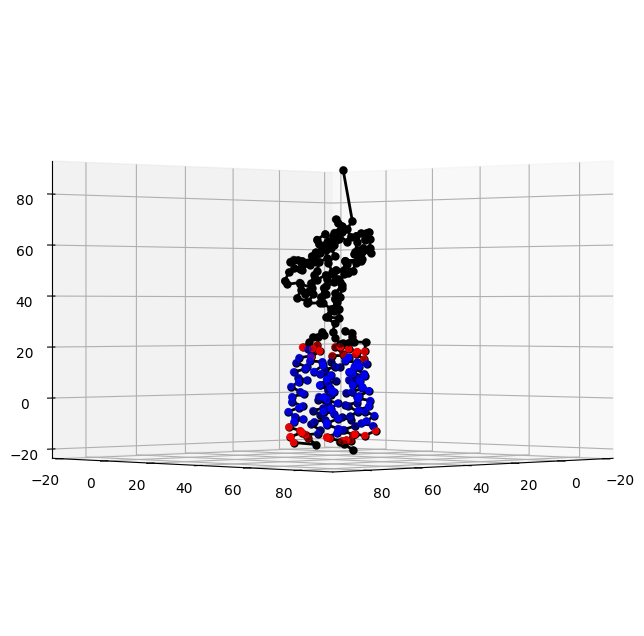

In [51]:
check_dict = {'Correct_outside':'black','Correct_inside':'blue','Membrane_outside':'green','Outside_in_membrane':'red'}

cd47 = all_structs[all_structs['uniprot'] == 'Q08722']
percent = len(cd47[cd47['score']>70]) / len(cd47)
print('Percent:',percent)
plot_all_angles(cd47[cd47['score']>70],'position_check',check_dict)


In [61]:
thick_df = pd.DataFrame(thicknesses,columns=['uniprot','thickness'])
target_df = target_df.set_index('Uniprot').join(thick_df.set_index('uniprot')).reset_index()
target_df

Uniprot   Entry name                                      Protein names  \
0     P21796  VDAC1_HUMAN  Voltage-dependent anion-selective channel prot...   
1     Q9Y277  VDAC3_HUMAN  Voltage-dependent anion-selective channel prot...   
2     Q3E6T0  PT525_ARATH  Probable sugar phosphate/phosphate translocato...   
3     Q8TBG9  SYNPR_HUMAN                                       Synaptoporin   
4     Q9NVA4  T184C_HUMAN  Transmembrane protein 184C (Transmembrane prot...   
...      ...          ...                                                ...   
5617  Q13224  NMDE2_HUMAN  Glutamate receptor ionotropic, NMDA 2B (GluN2B...   
5618  Q14957  NMDE3_HUMAN  Glutamate receptor ionotropic, NMDA 2C (GluN2C...   
5619  O15399  NMDE4_HUMAN  Glutamate receptor ionotropic, NMDA 2D (GluN2D...   
5620  Q05586  NMDZ1_HUMAN  Glutamate receptor ionotropic, NMDA 1 (GluN1) ...   
5621  P0AFA7   NHAB_ECOLI  Na(+)/H(+) antiporter NhaB (Sodium/proton anti...   

                   Gene names                                Organism  Length  \
0                  VDAC1 VDAC                    Homo sapiens (Human)     283   
1                       VDAC3                    Homo sapiens (Human)     283   
2        At5g25400 F18G18.140  Arabidopsis thaliana (Mouse-ear cress)     349   
3                       SYNPR                    Homo sapiens (Human)     265   
4     TMEM184C TMEM34 PRO1355                    Homo sapiens (Human)     438   
...                       ...                                     ...     ...   
5617           GRIN2B NMDAR2B                    Homo sapiens (Human)    1484   
5618           GRIN2C NMDAR2C                    Homo sapiens (Human)    1233   
5619    GRIN2D GluN2D NMDAR2D                    Homo sapiens (Human)    1336   
5620             GRIN1 NMDAR1                    Homo sapiens (Human)     938   
5621        nhaB b1186 JW1175           Escherichia coli (strain K12)     513   

     Gene names  (ordered locus ) Gene encoded by  \
0                           Empty           Empty   
1                           Empty           Empty   
2                       At5g25400           Empty   
3                           Empty           Empty   
4                           Empty           Empty   
...                           ...             ...   
5617                        Empty           Empty   
5618                        Empty           Empty   
5619                        Empty           Empty   
5620                        Empty           Empty   
5621                 b1186 JW1175           Empty   

                Cross-reference (Pfam)  \
0                             PF01459;   
1                             PF01459;   
2                             PF03151;   
3                             PF01284;   
4                             PF03619;   
...                                ...   
5617  PF01094;PF00060;PF10613;PF10565;   
5618  PF01094;PF00060;PF10613;PF10565;   
5619          PF01094;PF00060;PF10613;   
5620  PF01094;PF10562;PF00060;PF10613;   
5621                          PF06450;   

                                               Sequence  ...  \
0     MAVPPTYADLGKSARDVFTKGYGFGLIKLDLKTKSENGLEFTSSGS...  ...   
1     MCNTPTYCDLGKAAKDVFNKGYGFGMVKIDLKTKSCSGVEFSTSGH...  ...   
2     MGKGGSLSEGVIKNIIISYTYVAIWIFLSFTVIVYNKYILDKKMYD...  ...   
3     MCMVIFAPLFAIFAFATCGGYSGGLRLSVDCVNKTESNLSIDIAFA...  ...   
4     MPCTCTWRNWRQWIRPLVAVIYLVSIVVAVPLCVWELQKLEVGIHT...  ...   
...                                                 ...  ...   
5617  MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...  ...   
5618  MGGALGPALLLTSLFGAWAGLGPGQGEQGMTVAVVFSSSGPPQAQF...  ...   
5619  MRGAGGPRGPRGPAKMLLLLALACASPFPEEAPGPGGAGGPGGGLG...  ...   
5620  MSTMRLLTLALLFSCSVARAACDPKIVNIGAVLSTRKHEQMFREAV...  ...   
5621  MEISWGRALWRNFLGQSPDWYKLALIIFLIVNPLIFLISPFVAGWL...  ...   

                                                tm_inds  \
0     [27, 28, 29, 30, 31, 32, 33, 34, 40, 41, 42, 4...   
1     [27, 28, 29, 30, 31, 32, 33, 34, 40,

P0ACY6 UPF0756 membrane protein YeaL 18.468588
Percent: 0.972972972972973


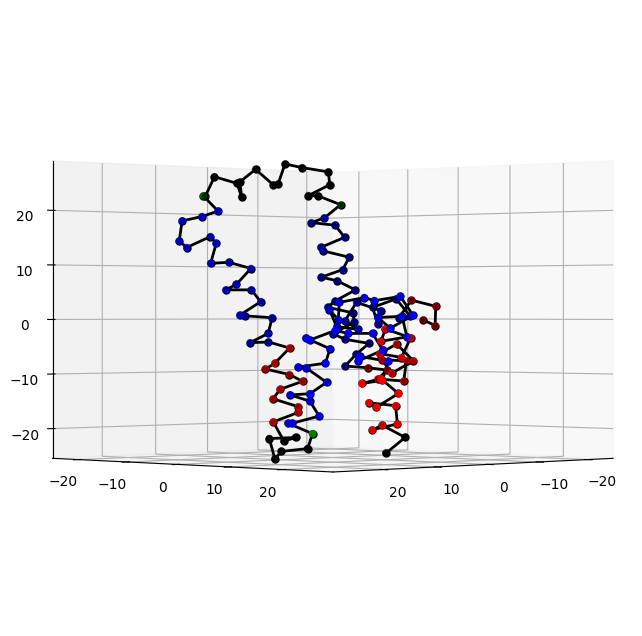

P30926 Neuronal acetylcholine receptor subunit beta-4 29.466457
Percent: 0.7751004016064257


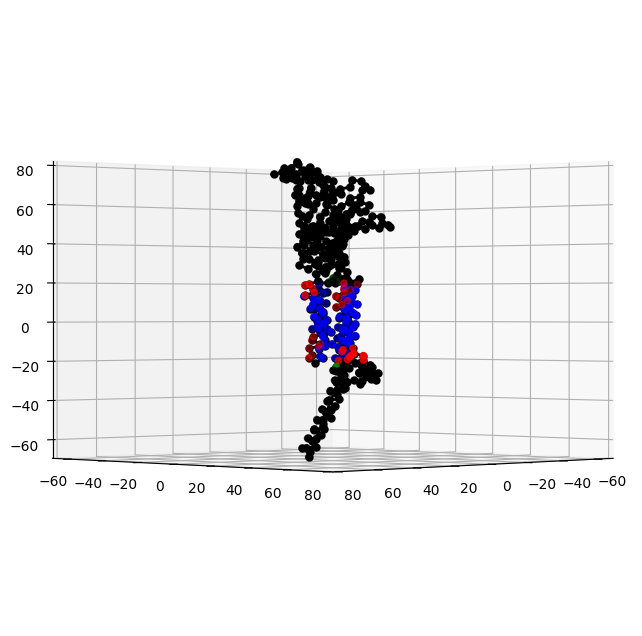

P43531 Inner membrane transport protein YnfM 15.150951
Percent: 0.9160671462829736


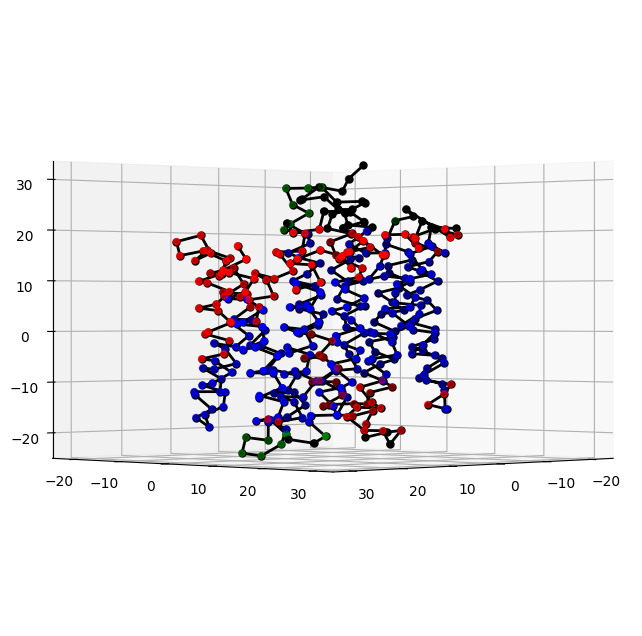

P45394 Inner membrane protein YrbG 24.775314
Percent: 0.9230769230769231


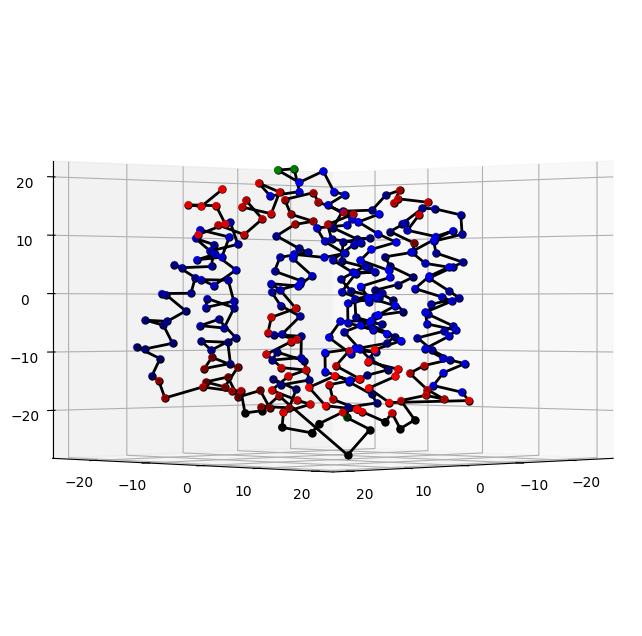

P45468 UPF0718 protein YraQ 3.9098504
Percent: 0.869942196531792


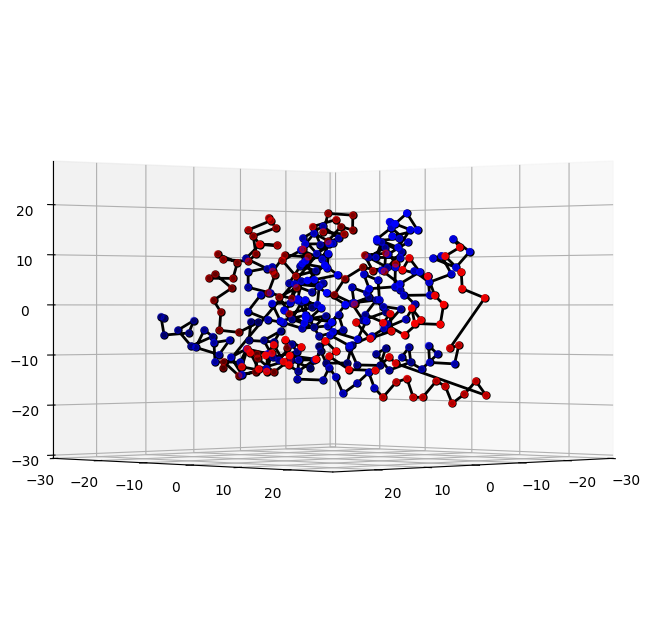

P45537 Uncharacterized protein YhfK 13.127461
Percent: 0.8614285714285714


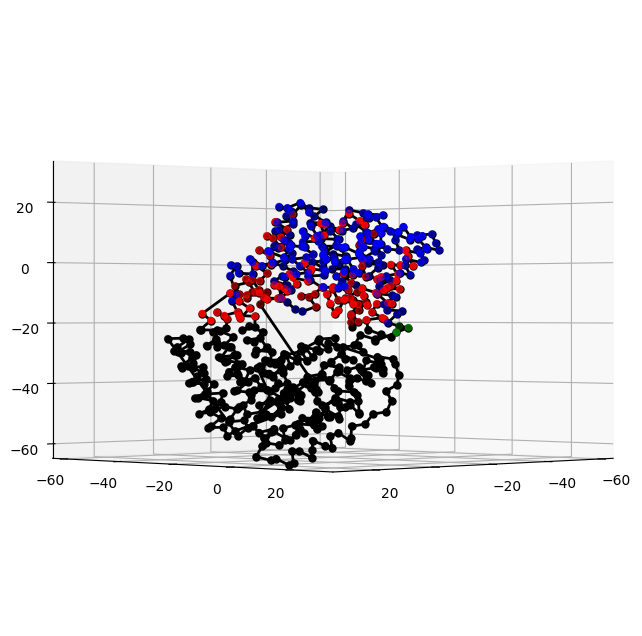

P45546 Uncharacterized protein YhfT 14.715543
Percent: 0.967741935483871


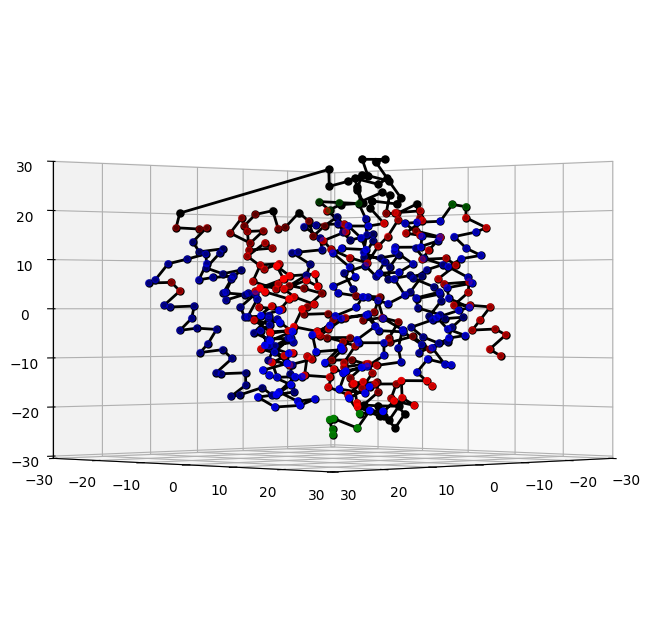

P45767 Putative amino-acid ABC transporter permease protein YhdX 24.355587
Percent: 0.9541984732824428


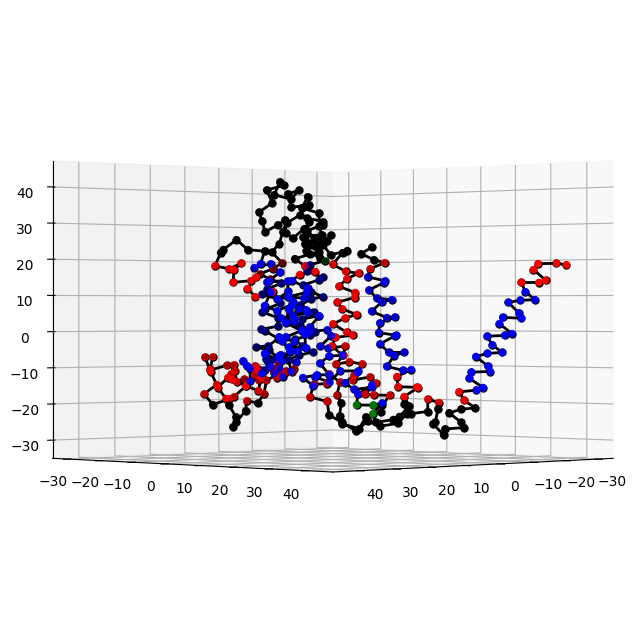

P45768 Inner membrane amino-acid ABC transporter permease protein YhdY 25.395458
Percent: 0.9264305177111717


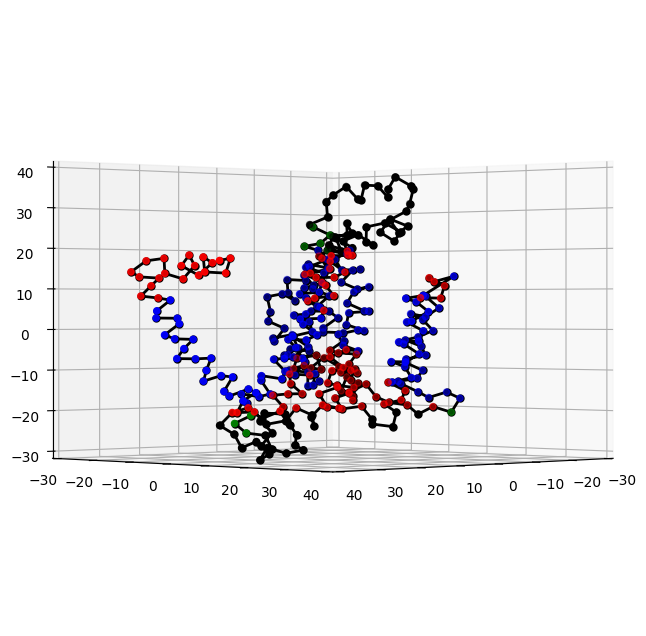

P64622 Uncharacterized protein YhdV 34.18554
Percent: 0.6575342465753424


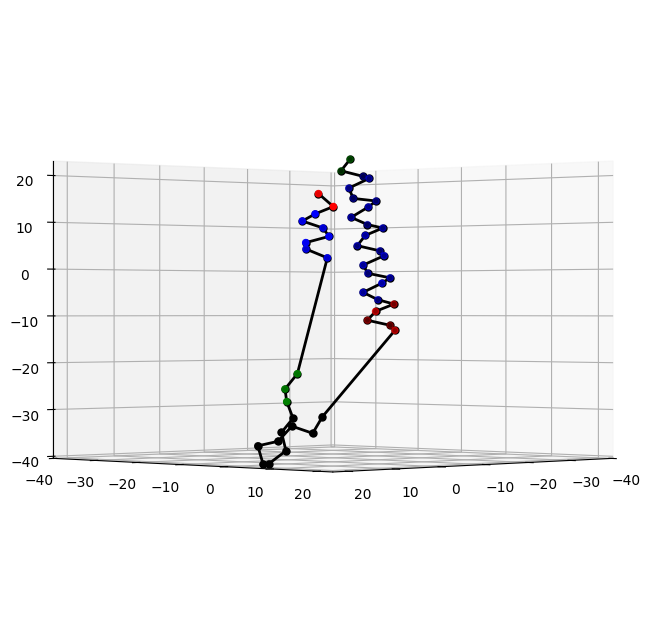

P76173 Anaerobic dimethyl sulfoxide reductase chain YnfH (DMSO reductase anchor subunit YnfH) 27.652292
Percent: 0.9612676056338029


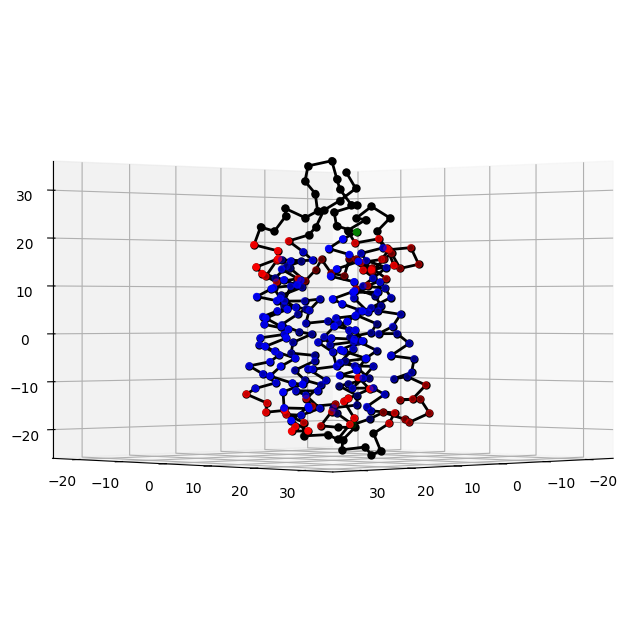

P76208 Uncharacterized protein YniB 27.476759
Percent: 0.8595505617977528


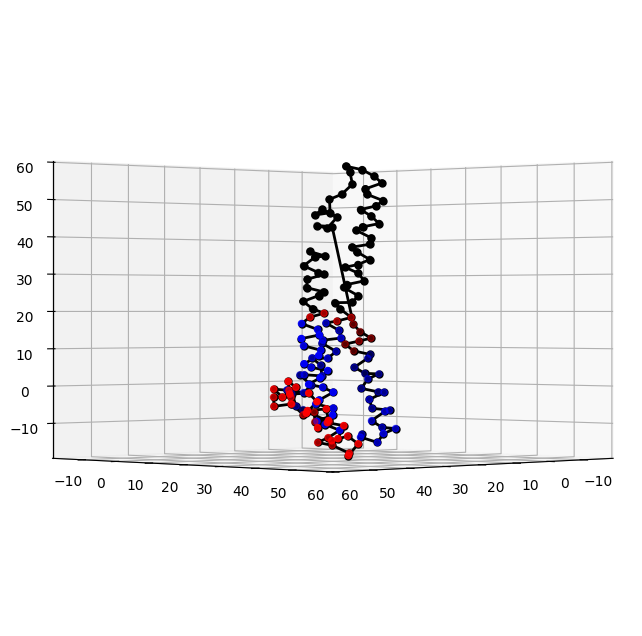

P76224 Inner membrane ABC transporter permease protein YnjC 24.19318
Percent: 0.974559686888454


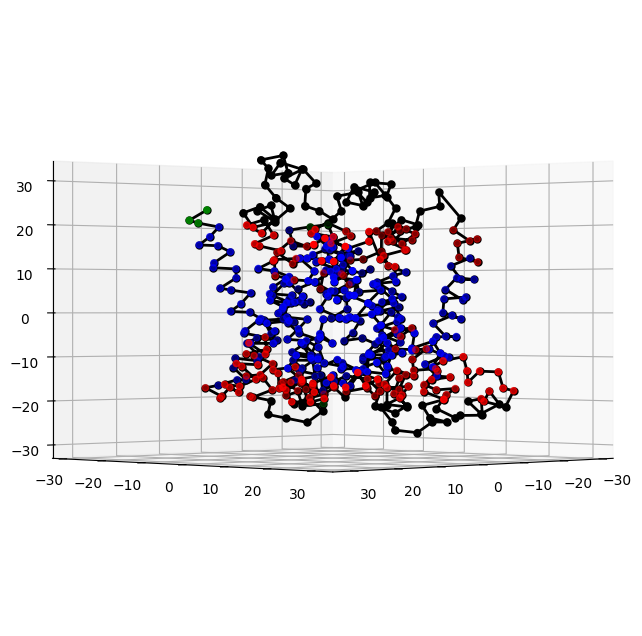

P76226 Inner membrane protein YnjF 25.783693
Percent: 0.8737864077669902


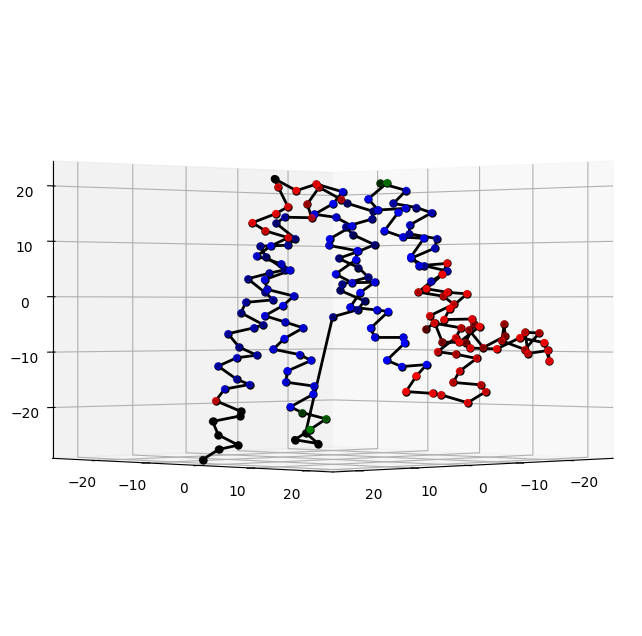

P76228 Inner membrane protein YnjI 20.960161
Percent: 0.9450867052023122


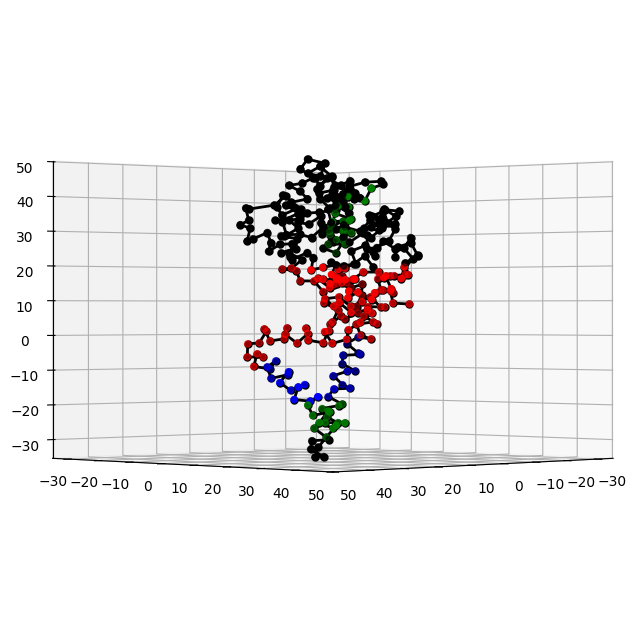

P77228 Putative transporter YdfJ 22.048409
Percent: 0.9016393442622951


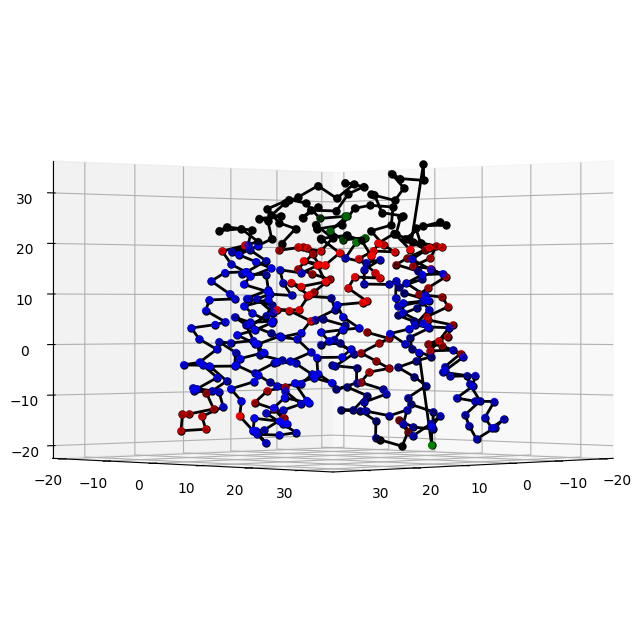

Q8N1M1 Bestrophin-3 (Vitelliform macular dystrophy 2-like protein 3) 6.395266
Percent: 0.5434131736526946


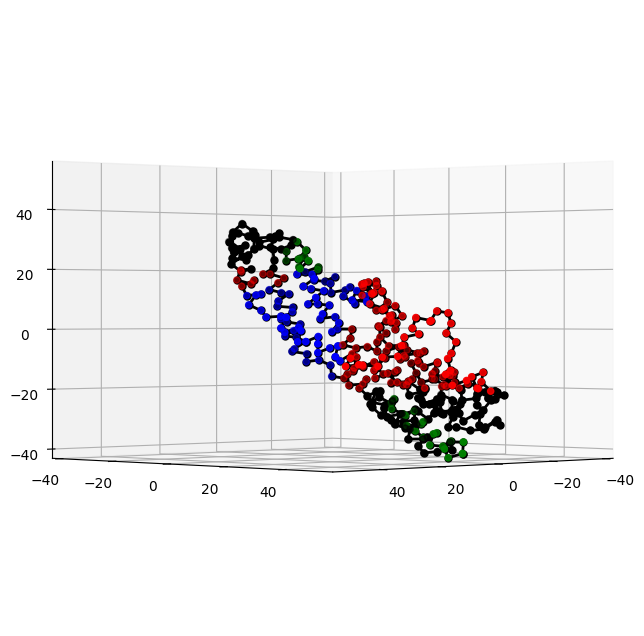

Q8NFU0 Bestrophin-4 (Vitelliform macular dystrophy 2-like protein 2) 6.3995852
Percent: 0.758985200845666


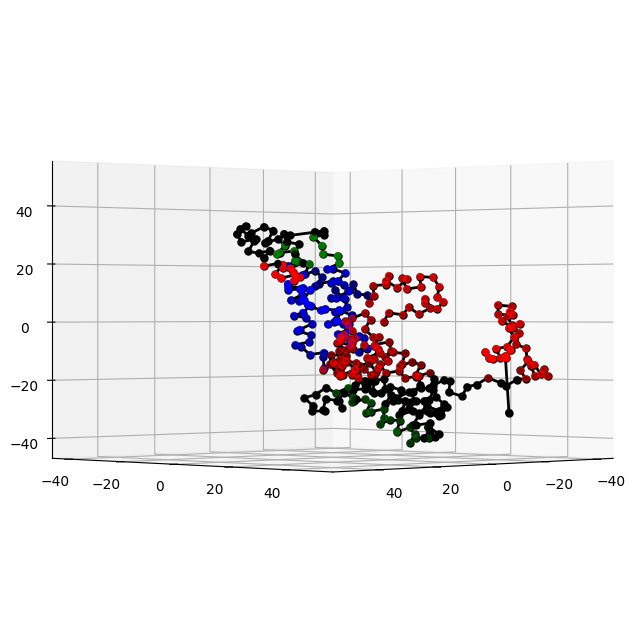

Q8WWZ7 Cholesterol transporter ABCA5 (EC 7.6.2.-) (ATP-binding cassette sub-family A member 5) 9.217265
Percent: 0.5042630937880633


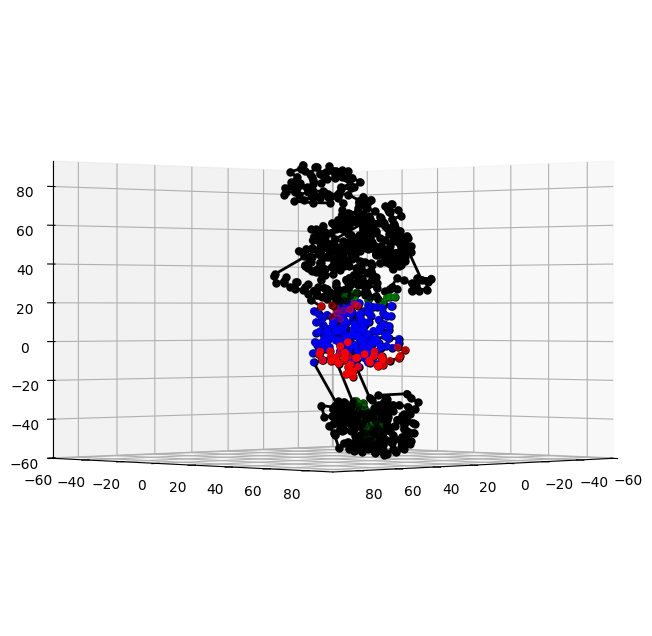

Q9JMS7 Uncharacterized protein YuaM 26.28737
Percent: 0.8528138528138528


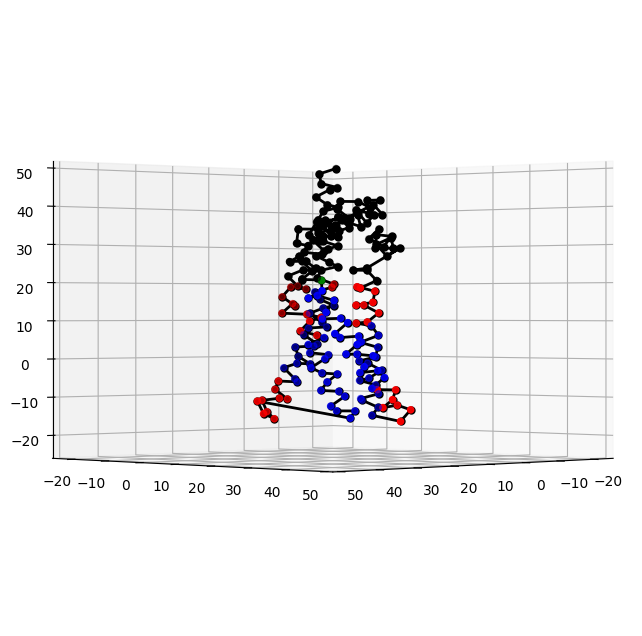

In [62]:
check_dict = {'Correct_outside':'black','Correct_inside':'blue','Membrane_outside':'green','Outside_in_membrane':'red'}

temp_ids = all_structs['uniprot'].unique()[40:60]

for uniprot,df in all_structs[all_structs['uniprot'].isin(temp_ids)].groupby('uniprot'):
    meta = target_df[target_df['Uniprot'] == uniprot]
    print(meta['Uniprot'].iloc[0],meta['Protein names'].iloc[0],meta['thickness'].iloc[0])
    percent = len(df[df['score']>70]) / len(df)
    print('Percent:',percent)
    plot_all_angles(df[df['score']>70],'position_check',check_dict)

### Scoreing and removing proteins based on the accuracy of the annotations
* Calculates the percentage of amino acids labelled correctly
* Sets the cut off for the required percentages as 2 standard deviations from the mean. 
    * Any protein with too many amino acids inside the membrane that shouldn't be are removed
    * Ones with a low overall accuract are removed as well
* The number of removed proteins are noted


In [63]:
temp = pd.DataFrame(all_structs.groupby(['uniprot','position_check']).agg(len)['res_id']).unstack(fill_value=0)
temp.columns = temp.columns.droplevel()
temp['correct'] = temp['Correct_inside'] + temp['Correct_outside']
temp['incorrect'] = temp['Membrane_outside'] + temp['Outside_in_membrane']
temp['total'] = temp['correct'] + temp['incorrect']
temp['percent_correct'] = (temp['correct'] / temp['total']) *100
temp['percent_outside_in'] = (temp['Outside_in_membrane'] / temp['total']) *100
temp = temp.reset_index()

percents = all_structs.set_index(['uniprot']).join(temp.set_index('uniprot')).reset_index()
percents

uniprot  res_id  res code          x          y          z      label  \
0        P21796       1  MET    M   0.049232  16.789335 -18.124241  outside_1   
1        P21796       2  ALA    A   0.383150  14.176707 -15.308717  outside_1   
2        P21796       3  VAL    V  -2.300010  13.590436 -12.620645  outside_1   
3        P21796       4  PRO    P  -0.535261  13.853255  -9.202189  outside_1   
4        P21796       5  PRO    P  -0.616459  10.796687  -6.851308  outside_1   
...         ...     ...  ...  ...        ...        ...        ...        ...   
2686090  P0AFA7     509  TRP    W -18.060099  17.120394  15.451529  outside_2   
2686091  P0AFA7     510  ILE    I -14.642264  16.390491  17.010385  outside_2   
2686092  P0AFA7     511  ALA    A -13.279367  16.953390  20.534854  outside_2   
2686093  P0AFA7     512  THR    T  -9.684977  17.023884  21.825908  outside_2   
2686094  P0AFA7     513  LEU    L  -9.420135  13.816387  23.905684  outside_2   

         score       position_check  Correct_inside  Correct_outside  \
0        58.17  Outside_in_membrane             183                4   
1        83.13  Outside_in_membrane             183                4   
2        89.82  Outside_in_membrane             183                4   
3        93.24  Outside_in_membrane             183                4   
4        94.34  Outside_in_membrane             183                4   
...        ...                  ...             ...              ...   
2686090  89.24  Outside_in_membrane             246               80   
2686091  88.35  Outside_in_membrane             246               80   
2686092  81.71      Correct_outside             246               80   
2686093  73.55      Correct_outside             246               80   
2686094  67.82      Correct_outside             246               80   

         Membrane_outside  Outside_in_membrane  correct  incorrect  total  \
0                       0                   96      187         96    283   
1                       0                   96      187         96    283   
2                       0                   96      187         96    283   
3                       0                   96      187         96    283   
4                       0                   96      187         96    283   
...                   ...                  ...      ...        ...    ...   
2686090                 6                  181      326        187    513   
2686091                 6                  181      326        187    513   
2686092                 6                  181      326        187    513   
2686093                 6                  181      326        187    513   
2686094                 6                  181      326        187    513   

         percent_correct  percent_outside_in  
0              66.077739           33.922261  
1              66.077739           33.922261  
2              66.077739           33.922261  
3              66.077739           33.922261  
4              66.077739           33.922261  
...                  ...                 ...  
2686090        63.547758           35.282651  
2686091        63.547758           35.282651  
2686092        63.547758           35.282651  
2686093        63.547758           35.282651  
2686094        63.547758           35.282651  

[2686095 rows x 19 columns]

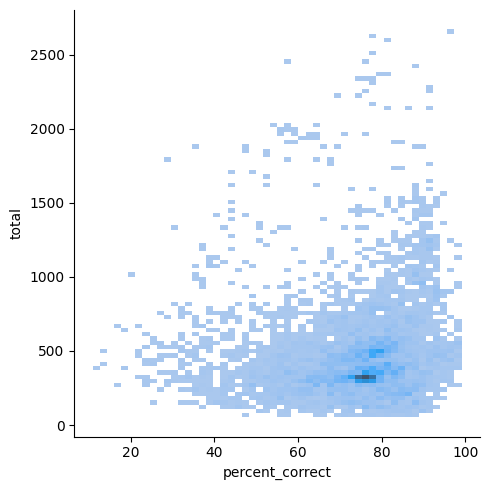

In [64]:
sns.displot(temp,x='percent_correct',y='total')

Passed: 4992 Starting: 5599


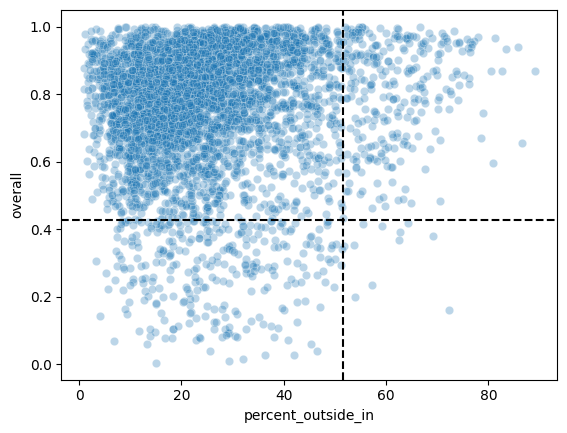

In [65]:
def get_cutoff(series,stdevs):
    return np.mean(series) + stdevs*np.std(series)

outside_cutoff = get_cutoff(percents['percent_outside_in'],2)

overall_scores = percents[percents['score'] > 70].groupby('uniprot').agg(len)['res_id'] / percents.groupby('uniprot').agg(len)['res_id']
overall_scores = overall_scores.reset_index().rename(columns={'res_id':'overall'})
overall_cutoff = get_cutoff(overall_scores['overall'],-2)

stats = percents.set_index('uniprot').join(overall_scores.set_index('uniprot')).reset_index()[['uniprot','percent_outside_in','overall']].drop_duplicates()

sns.scatterplot(data=stats,x='percent_outside_in',y='overall',alpha=0.3)
plt.axhline(overall_cutoff,color='black',ls='--')
plt.axvline(outside_cutoff,color='black',ls='--')

checked_uniprots = stats[(stats['percent_outside_in'] < outside_cutoff) & (stats['overall'] > overall_cutoff)]['uniprot'].unique()
print('Passed:',len(checked_uniprots),'Starting:',len(stats['uniprot'].unique()))

### Removal of proteins based on transmembrane domain thinkness
* Looks at the distance between the center of the termini above and below the membrane
* The theoretical distance should be around 30A
* Proteins with calculated thickness less than 2 standard deviations from the mean were also eliminated

4992 5622
4612 4992


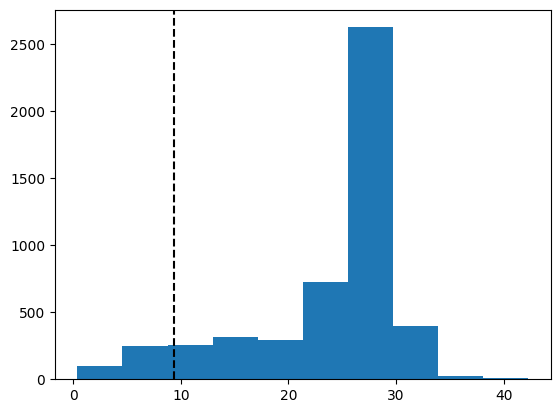

In [66]:
temp = target_df[target_df['Uniprot'].isin(checked_uniprots)]
print(len(temp),len(target_df))
plt.hist(temp['thickness'])

thickness_cutoff = get_cutoff(temp['thickness'],-2)
plt.axvline(thickness_cutoff,color='black',ls='--')
checked_uniprots = temp[temp['thickness'] > thickness_cutoff]['Uniprot'].unique()
print(len(checked_uniprots),len(temp))

checked = percents[percents['uniprot'].isin(checked_uniprots)]

# Calculation of amino acid locations and attributes

### Calculation of the distance between each amino acid and the surrounding lipids
* In order to identify which amino acids are in contact with the membrane I had to define where the membrane is.
* To define the location of the lipids, I calculated an alpha shape (3D convex hull) which contains all alpha carbons of a given protein.
    * The main tunable parameter is the alpha value which dictates how tightly the alpha shape will fit to the protein
    * I found that the alpha shape needs to scale with the size of the protein.
    * The correlation between alpha value and protein length was defined by empirical observations
* The alpha shape will bound the full protein, including on top and bottom, so to avoid having those parts of the alpha shape be considered where lipids are, 
    * the locations of all the associated triangles that make up the alpha shape are moved to far above or below the membrane
* The distance between the convex hull surface and each alpha carbon are calculated to determine the distance to the membrane

In [68]:
def alpha_shape_3D(pos, alpha):
    """
    https://stackoverflow.com/questions/26303878/alpha-shapes-in-3d
    Compute the alpha shape (concave hull) of a set of 3D points.
    Parameters:
        pos - np.array of shape (n,3) points.
        alpha - alpha value.
    return
        outer surface vertex indices, edge indices, and triangle indices
    """
    tetra = Delaunay(pos)
    # Find radius of the circumsphere.
    # By definition, radius of the sphere fitting inside the tetrahedral needs 
    # to be smaller than alpha value
    # http://mathworld.wolfram.com/Circumsphere.html
    tetrapos = np.take(pos,tetra.vertices,axis=0)
    normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
    ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
    a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
    Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
    Dy = -np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
    Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
    c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
    r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a))

    # Find tetrahedrals
    tetras = tetra.vertices[r<alpha,:]
    # triangles
    TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
    Triangles = tetras[:,TriComb].reshape(-1,3)
    Triangles = np.sort(Triangles,axis=1)
    # Remove triangles that occurs twice, because they are within shapes
    TrianglesDict = defaultdict(int)
    for tri in Triangles:TrianglesDict[tuple(tri)] += 1
    Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
    #edges
    EdgeComb=np.array([(0, 1), (0, 2), (1, 2)])
    Edges=Triangles[:,EdgeComb].reshape(-1,2)
    Edges=np.sort(Edges,axis=1)
    Edges=np.unique(Edges,axis=0)

    Vertices = np.unique(Edges)
    return Vertices,Edges,Triangles

def get_surface(coords,length):
    if length < 100:
        alpha = 200
    elif length > 500:
        alpha = 10
    else:
        m = interp1d([100,500],[100,10])
        alpha = m(length)

    pos = np.array(coords)
    vertices,edges,triangles = alpha_shape_3D(pos,alpha)
    surface = np.array([coord for i,coord in enumerate(pos) if i in vertices])
    surface[:,2] = np.where(surface[:,2] > 30, 300, surface[:,2])
    surface[:,2] = np.where(surface[:,2] < -30, -300, surface[:,2])
    return surface

surface = 0
def dist_to_surface(row,surface=surface):
    return min_dist(np.array(row[['x','y','z']]), surface)


### Calculate the depth - the number of amino acids nearby

In [69]:
def get_search_object(structure):
    return NeighborSearch([atom for atom in structure[0].get_atoms()], bucket_size=10)

def find_neighbors(row,radius=6):
    try:
        res = search_obj.search(structure[0]['A'][row['res_id']]['CA'].get_coord(),radius,level='R')
        res = [aa.resname for aa in res]
    except:
        print('missing')
        res = ['']
    return res

def find_length(aas):
    return len(aas)

In [28]:
calcs = []
calc_fail = []
for i,[uniprot,df] in enumerate(checked[checked['score']>70].groupby('uniprot')):
    meta = target_df[target_df['Uniprot'] == uniprot]
    print(i,uniprot)
    try:
        temp = df[(df['z'] < 30) & (df['z'] > -30)]
        surface = get_surface(temp[['x','y','z']],len(df))
        df['mem_dist'] = df.apply(dist_to_surface,surface=surface,axis=1)

        p = PDBParser(QUIET=True)
        structure = p.get_structure("X", meta['pdb_path'].iloc[0])
        search_obj = get_search_object(structure)

        df['neighbors_6'] = df.apply(find_neighbors,axis=1,radius=6)
        df['neighbors_12'] = df.apply(find_neighbors,axis=1,radius=12)
        df['depth_6'] = df['neighbors_6'].apply(find_length)
        df['depth_12'] = df['neighbors_12'].apply(find_length)

        calcs.append(df)
    except:
        print('\nFAILURE: ',uniprot)
        calc_fail.append(uniprot)
    
calcs = pd.concat(calcs)
print(len(calc_fail))
calcs

0 A0A075B734


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1 A0A087WTH1
2 A0A096LPK9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3 A0A0X1KG70


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4 A0A1B0GTI8
5 A0A1B0GVZ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


6 A0A1W2PS18
7 A0A494BZU4
8 A0AV02


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


9 A0AVI4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


10 A0FGR9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


11 A0MFS9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


12 A0PJK1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


13 A0PJW6
14 A0PJX8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


15 A0PK11
16 A1A5B4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


17 A1L157
18 A1L3X0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


19 A1L4X0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


20 A1XJK0
21 A2RU14


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


22 A2RVP7
23 A3KFT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


24 A4D2G3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


25 A4IF30


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


26 A5A605
27 A5A630
28 A5D6W6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


29 A5X5Y0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


30 A6NC51
31 A6NCV1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


32 A6ND48
33 A6NDH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


34 A6NDL8
35 A6NDP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


36 A6NDV4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


37 A6NET4
38 A6NF89


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


39 A6NFC5
40 A6NFX1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


41 A6NGA9
42 A6NGB7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


43 A6NGC4
44 A6NGY5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


45 A6NH00


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


46 A6NH21
47 A6NH52


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


48 A6NHA9
49 A6NHG9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


50 A6NI61
51 A6NIJ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


52 A6NIM6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


53 A6NJY1
54 A6NJY4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


55 A6NJZ3
56 A6NK97


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


57 A6NKF7
58 A6NKK0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


59 A6NKX4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


60 A6NL08
61 A6NL26


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


62 A6NL99
63 A6NM03


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


64 A6NM10
65 A6NM45


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


66 A6NM76
67 A6NMS3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


68 A6NMU1
69 A6NMZ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


70 A6NN92
71 A6NND4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


72 A6NNN8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


73 A7MBM2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


74 A8MPR5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


75 A8MPY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


76 A8MRV9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


77 A8MRY9
78 A8MUP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


79 A8MWK0
80 A8MWL6
81 A8MYU2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


82 B0F9L7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


83 B0YJ81
84 B1AL88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


85 B2RN74
86 B2RXF0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


87 B3DN87
88 B3H6K1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


89 B3H754
90 B3LFA3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


91 B3SHH9
92 B5TYT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


93 B7U540
94 B7ZAQ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


95 B8XCH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


96 B9DFX7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


97 B9DGY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


98 B9DHG0
99 B9EJG8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


100 C9JDP6
101 E9PQX1
102 F4HPH1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


103 F4HPH2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


104 F4HQ05


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


105 F4HVJ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


106 F4HVM3
107 F4HW02


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


108 F4HW17


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


109 F4HW79
110 F4HWB6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


111 F4HXY7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


112 F4HYR3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


113 F4HZH9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


114 F4HZQ7
115 F4I111


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


116 F4I214
117 F4I248


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


118 F4I340
119 F4I4K7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


120 F4I4Q3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


121 F4I5D5
122 F4I5Q2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


123 F4I8I0
124 F4I8K2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


125 F4I8W6
126 F4I8X6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


127 F4I8X8
128 F4I9E1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


129 F4IBD7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


130 F4ICF4
131 F4IHS9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


132 F4IHU9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


133 F4IJ08
134 F4IKF6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


135 F4ILY9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


136 F4IME1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


137 F4IME2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


138 F4IQJ6
139 F4IQV7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


140 F4IQX1
141 F4IR05


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


142 F4ISV9
143 F4ITL6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


144 F4IUE7
145 F4IUW3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


146 F4IYZ0
147 F4IZC4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


148 F4IZW8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


149 F4J158


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


150 F4J1Q9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


151 F4J220
152 F4J4C8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


153 F4J9A3
154 F4JBM4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


155 F4JCY2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


156 F4JE35


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


157 F4JH46


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


158 F4JIE8
159 F4JIN3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


160 F4JIP9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


161 F4JK59
162 F4JKB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


163 F4JKK0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


164 F4JKQ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


165 F4JLZ6
166 F4JMI5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


167 F4JMI7
168 F4JPE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


169 F4JPW1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


170 F4JRE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


171 F4JSH1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


172 F4JTB3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


173 F4JU70
174 F4JUU5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


175 F4JY11
176 F4JZG9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


177 F4JZN6
178 F4K2U8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


179 F4KBM7
180 F4KD68
181 F4KD71


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


182 F4KDA6
183 F4KGN5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


184 F4KHA8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


185 F4KIB2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


186 F4KIL8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


187 G3V0H7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


188 H0YL14
189 H3BS89
190 H7C241


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


191 O00124
192 O00144


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


193 O00155
194 O00180


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


195 O00222


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


196 O00237


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


197 O00254
198 O00258


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


199 O00270
200 O00322


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


201 O00337
202 O00341


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


203 O00398
204 O00400


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


205 O00421
206 O00476


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


207 O00501
208 O00519


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


209 O00574
210 O00590


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


211 O00591
212 O00623


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


213 O00624


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


214 O00767
215 O04034


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


216 O04036


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


217 O04089


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


218 O04200
219 O04249


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


220 O04289


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


221 O04472


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


222 O04508
223 O04514


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


224 O04619


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


225 O04714
226 O04722


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


227 O04928


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


228 O05000


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


229 O14493
230 O14494


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


231 O14495
232 O14521


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


233 O14524
234 O14569


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


235 O14581
236 O14626


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


237 O14678


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


238 O14683
239 O14684
240 O14718


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


241 O14764
242 O14804


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


243 O14817
244 O14828


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


245 O14842
246 O14843


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


247 O14863
248 O14894


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


249 O14983
250 O15118


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


251 O15121
252 O15126


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


253 O15127
254 O15218


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


255 O15229


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


256 O15243
257 O15244


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


258 O15245


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


259 O15258
260 O15260


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


261 O15303


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


262 O15321


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


263 O15342
264 O15374


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


265 O15375


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


266 O15403
267 O15427


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


268 O15431
269 O15432


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


270 O15438


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


271 O15503
272 O15529


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


273 O15547
274 O15551


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


275 O15552
276 O15554


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


277 O22218


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


278 O22261
279 O22267


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


280 O22397


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


281 O22588
282 O22622


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


283 O22719


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


284 O22752


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


285 O22757


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


286 O22780


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


287 O22815


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


288 O22881


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


289 O22920


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


290 O23039
291 O23040


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


292 O23053


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


293 O23086


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


294 O23087


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


295 O23164
296 O23413


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


297 O23492


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


298 O23693
299 O43193


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


300 O43194
301 O43246


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


302 O43292


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


303 O43306


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


304 O43424


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


305 O43490


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


306 O43511


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


307 O43520


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


308 O43603
309 O43613


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


310 O43614
311 O43657


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


312 O43688
313 O43731


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


314 O43749
315 O43759


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


316 O43760
317 O43761


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


318 O43772
319 O43808


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


320 O43826


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


321 O43861


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


322 O43869


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


323 O43934


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


324 O48528
325 O48538


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


326 O48639


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


327 O48670
328 O48671
329 O48780


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


330 O48916
331 O48962


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


332 O49423


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


333 O49447


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


334 O49567


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


335 O49621


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


336 O49636
337 O49639


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


338 O49660


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


339 O49696
340 O49722


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


341 O49725


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


342 O49726


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


343 O49730


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


344 O60266


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


345 O60312


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


346 O60337


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


347 O60353


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


348 O60359
349 O60391


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


350 O60403
351 O60404


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


352 O60412
353 O60423


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


354 O60427


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


355 O60431
356 O60478


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


357 O60503


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


358 O60635
359 O60636


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


360 O60637
361 O60669


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


362 O60706


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


363 O60725
364 O60741


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


365 O60755
366 O60779


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


367 O60830
368 O60831
369 O60883


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


370 O60906
371 O60928


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


372 O60931


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


373 O64474


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


374 O64503
375 O64515


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


376 O64614
377 O64668


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


378 O64738


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


379 O64759


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


380 O64761
381 O64769


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


382 O64792
383 O64806


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


384 O64823
385 O64834


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


386 O64837
387 O64847
388 O64886


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


389 O65023


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


390 O65413


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


391 O65677


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


392 O65708
393 O65717


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


394 O65718


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


395 O75027


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


396 O75084


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


397 O75110


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


398 O75185


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


399 O75204
400 O75311


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


401 O75352
402 O75355


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


403 O75387


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


404 O75388
405 O75425


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


406 O75473
407 O75508
408 O75712


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


409 O75746


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


410 O75762


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


411 O75783
412 O75841


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


413 O75844


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


414 O75845
415 O75899


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


416 O75907


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


417 O75908


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


418 O75915
419 O75949


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


420 O75954
421 O76000


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


422 O76001
423 O76002


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


424 O76024


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


425 O76062


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


426 O76082


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


427 O76099
428 O76100


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


429 O80436


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


430 O80505


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


431 O80580


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


432 O80592


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


433 O80594
434 O80605


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


435 O80612


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


436 O80632
437 O80638


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


438 O80668


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


439 O80685
440 O80695


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


441 O80725


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


442 O80739


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


443 O80813
444 O80832


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


445 O80854
446 O80885


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


447 O80905


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


448 O80946


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


449 O80952
450 O80961


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


451 O81000


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


452 O81006
453 O81062


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


454 O81108


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


455 O81123
456 O81209


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


457 O81210


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


458 O81211


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


459 O81845
460 O81850


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


461 O81898
462 O82226


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


463 O82232
464 O82245
465 O82251


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


466 O82316
467 O82390


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


468 O82485


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


469 O82567


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


470 O82568
471 O82587


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


472 O82598
473 O82643


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


474 O82752


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


475 O82756
476 O82811


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


477 O94759


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


478 O94777
479 O94778
480 O94823


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


481 O94886


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


482 O94910


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


483 O94956


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


484 O95006


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


485 O95007
486 O95013


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


487 O95047
488 O95069


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


489 O95070
490 O95136


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


491 O95140


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


492 O95214
493 O95221


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


494 O95222
495 O95255


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


496 O95258
497 O95259


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


498 O95264


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


499 O95279
500 O95342


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


501 O95371
502 O95377


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


503 O95415
504 O95427


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


505 O95436


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


506 O95452
507 O95471


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


508 O95473
509 O95484


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


510 O95490


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


511 O95500
512 O95528


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


513 O95562
514 O95563
515 O95665


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


516 O95800
517 O95807


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


518 O95832
519 O95838


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


520 O95847
521 O95857


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


522 O95858
523 O95859


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


524 O95864
525 O95907


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


526 O95918


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


527 O95977
528 O96005


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


529 P00156


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


530 P00395


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


531 P00403
532 P00414


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


533 P00550


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


534 P00803
535 P00804


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


536 P02730
537 P02916


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


538 P02920
539 P02921


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


540 P02930


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


541 P02931
542 P02942


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


543 P02943


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


544 P03819


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


545 P03886


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


546 P03891


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


547 P03897
548 P03901
549 P03905


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


550 P03915


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


551 P03923
552 P03959


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


553 P03960


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


554 P03999


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


555 P04000
556 P04001


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


557 P04035


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


558 P04201
559 P04737


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


560 P04778
561 P04839


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


562 P04844


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


563 P05023


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


564 P05141
565 P05496


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


566 P05704
567 P06129


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


568 P06609
569 P06971


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


570 P06996


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


571 P07001


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


572 P07017


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


573 P07018


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


574 P07117


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


575 P07510


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


576 P07550


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


577 P07654
578 P08034


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


579 P08100
580 P08172
581 P08173


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


582 P08183


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


583 P08194


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


584 P08247
585 P08369


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


586 P08400


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


587 P08550
588 P08555


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


589 P08588
590 P08842


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


591 P08908


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


592 P08912
593 P08913


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


594 P08962
595 P09130


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


596 P09131


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


597 P09169
598 P09323


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


599 P09348
600 P09391


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


601 P09836


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


602 P0A6A0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


603 P0A6H8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


604 P0A6J3
605 P0A6M2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


606 P0A6W3
607 P0A710


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


608 P0A712
609 P0A742


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


610 P0A766
611 P0A769
612 P0A7C8
613 P0A830


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


614 P0A8D9
615 P0A8H3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


616 P0A8K8
617 P0A8Q0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


618 P0A8Q3
619 P0A8R7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


620 P0A8S5
621 P0A910


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


622 P0A917
623 P0A921


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


624 P0A924
625 P0A940


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


626 P0AA47


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


627 P0AA49


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


628 P0AA60
629 P0AA63


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


630 P0AA67
631 P0AA70


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


632 P0AA73
633 P0AA76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


634 P0AA78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


635 P0AA80


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


636 P0AA82


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


637 P0AA93


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


638 P0AAA1
639 P0AAA7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


640 P0AAC4
641 P0AAC6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


642 P0AAD2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


643 P0AAD4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


644 P0AAD6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


645 P0AAD8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


646 P0AAE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


647 P0AAE2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


648 P0AAE5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


649 P0AAE8
650 P0AAF1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


651 P0AAG5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


652 P0AAI3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


653 P0AAM1
654 P0AAP7
655 P0AAQ0
656 P0AAR5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


657 P0AAS0
658 P0AAS3
659 P0AAT4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


660 P0AAZ0
661 P0AB01


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


662 P0AB12
663 P0AB67


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


664 P0AB93


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


665 P0ABB8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


666 P0ABC0
667 P0ABC9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


668 P0ABD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


669 P0ABE5
670 P0ABF8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


671 P0ABG1
672 P0ABH4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


673 P0ABI4
674 P0ABI8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


675 P0ABJ1
676 P0ABJ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


677 P0ABJ6
678 P0ABJ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


679 P0ABK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


680 P0ABL8
681 P0ABM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


682 P0ABM9
683 P0ABN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


684 P0ABN5
685 P0ABN9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


686 P0ABP3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


687 P0ABP6
688 P0ABT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


689 P0ABU7
690 P0ABU9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


691 P0AC05
692 P0AC07
693 P0AC23


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


694 P0AC26
695 P0AC30


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


696 P0AC44
697 P0AC78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


698 P0AC94


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


699 P0AC96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


700 P0AC98
701 P0ACB7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


702 P0ACV4
703 P0ACX0
704 P0ACY6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


705 P0AD03


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


706 P0AD14


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


707 P0AD17
708 P0AD19


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


709 P0AD27


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


710 P0AD47
711 P0AD99


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


712 P0ADC3
713 P0ADC6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


714 P0ADD2
715 P0ADD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


716 P0ADE4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


717 P0ADI9
718 P0ADJ8
719 P0ADK4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


720 P0ADL1
721 P0ADL6
722 P0ADM0
723 P0ADP5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


724 P0ADR2
725 P0AE16


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


726 P0AE24


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


727 P0AE26
728 P0AE30


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


729 P0AE34
730 P0AE42
731 P0AE45


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


732 P0AE74


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


733 P0AE82


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


734 P0AEA5
735 P0AEB0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


736 P0AEB5
737 P0AEC0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


738 P0AEC3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


739 P0AEC5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


740 P0AEC8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


741 P0AEG1
742 P0AEH1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


743 P0AEH8
744 P0AEJ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


745 P0AEJ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


746 P0AEK7
747 P0AEL0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


748 P0AEP1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


749 P0AEQ6
750 P0AER0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


751 P0AER3
752 P0AER5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


753 P0AER8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


754 P0AET5
755 P0AEU3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


756 P0AEW1
757 P0AEX3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


758 P0AEX7
759 P0AEY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


760 P0AEY8
761 P0AF01
762 P0AF16


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


763 P0AF32
764 P0AF40


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


765 P0AF52


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


766 P0AF54
767 P0AF73
768 P0AF80
769 P0AF98


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


770 P0AFA2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


771 P0AFA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


772 P0AFA7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


773 P0AFA9
774 P0AFC3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


775 P0AFD4
776 P0AFE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


777 P0AFE4
778 P0AFF0
779 P0AFF2
780 P0AFF4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


781 P0AFH2
782 P0AFH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


783 P0AFJ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


784 P0AFK2
785 P0AFK4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


786 P0AFK6
787 P0AFL1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


788 P0AFL9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


789 P0AFP0
790 P0AFP9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


791 P0AFQ2
792 P0AFR2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


793 P0AFR9
794 P0AFS1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


795 P0AFT2
796 P0AFU0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


797 P0AFU2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


798 P0AFV2
799 P0AFY6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


800 P0AFZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


801 P0AG00
802 P0AG34


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


803 P0AG38
804 P0AG93


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


805 P0AG96
806 P0AGA2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


807 P0AGC0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


808 P0AGE4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


809 P0AGF4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


810 P0AGH1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


811 P0AGH3
812 P0AGH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


813 P0AGH8
814 P0AGI1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


815 P0AGI4
816 P0AGK1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


817 P0AGM2
818 P0AGM7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


819 P0AGM9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


820 P0C0L7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


821 P0C0S1
822 P0C604


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


823 P0C617
824 P0C623


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


825 P0C628
826 P0C629


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


827 P0C645
828 P0C646


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


829 P0C672
830 P0C7N1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


831 P0C7N5
832 P0C7N8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


833 P0C7Q5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


834 P0C7Q6
835 P0C7T2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


836 P0C7T3
837 P0C7T8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


838 P0C7U3
839 P0C8Q9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


840 P0C941
841 P0CB17
842 P0CB39


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


843 P0CC32


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


844 P0CC33


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


845 P0CE44


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


846 P0CE45


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


847 P0CG08


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


848 P0CG16


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


849 P0CI03


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


850 P0CJ48
851 P0CK96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


852 P0CW77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


853 P0CW78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


854 P0CZ21
855 P0DH92


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


856 P0DH93
857 P0DH94
858 P0DI78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


859 P0DMC5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


860 P0DMS8
861 P0DMS9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


862 P0DMU2
863 P0DN77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


864 P0DN78
865 P0DN80


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


866 P0DN81
867 P0DN82


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


868 P0DP42
869 P0DP69
870 P0DQD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


871 P0DSN6
872 P0DTE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


873 P0DTE5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


874 P10620
875 P10903


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


876 P10905
877 P10906


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


878 P11049
879 P11166


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


880 P11168


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


881 P11169


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


882 P11229


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


883 P11230


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


884 P11286
885 P11350
886 P11551


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


887 P11667
888 P11836


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


889 P12235
890 P12236


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


891 P13518


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


892 P13569


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


893 P13637


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


894 P13738


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


895 P13866


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


896 P13945
897 P14377


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


898 P14416
899 P14672


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


900 P14867


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


901 P15029
902 P15068


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


903 P15078
904 P15877


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


905 P15993


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


906 P16260
907 P16389


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


908 P16429


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


909 P16430
910 P16473


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


911 P16615


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


912 P16671


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


913 P16701
914 P17152


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


915 P17302
916 P17334


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


917 P17583


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


918 P17658


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


919 P17787


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


920 P18033
921 P18089


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


922 P18200
923 P18392


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


924 P18405
925 P18505


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


926 P18507
927 P18577


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


928 P18777
929 P18825


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


930 P19075
931 P19397


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


932 P19456


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


933 P19642


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


934 P20020


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


935 P20292
936 P20309


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


937 P20431


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


938 P20648


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


939 P20649


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


940 P21145
941 P21345


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


942 P21365
943 P21439


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


944 P21452
945 P21453


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


946 P21462
947 P21503


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


948 P21554
949 P21728


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


950 P21730
951 P21731


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


952 P21796
953 P21865


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


954 P21917
955 P21918


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


956 P21926


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


957 P22001


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


958 P22459


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


959 P22460


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


960 P22729


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


961 P22732


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


962 P22888


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


963 P23173


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


964 P23200
965 P23415


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


966 P23416


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


967 P23586


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


968 P23634


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


969 P23837
970 P23842


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


971 P23849


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


972 P23876
973 P23877


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


974 P23886


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


975 P23894
976 P23895


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


977 P23910


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


978 P23930


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


979 P23942
980 P23945


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


981 P23975


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


982 P24046


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


983 P24077


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


984 P24177


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


985 P24181


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


986 P24207


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


987 P24241


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


988 P24390
989 P24530


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


990 P25021
991 P25024


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


992 P25025
993 P25089


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


994 P25090
995 P25100


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


996 P25101


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


997 P25103
998 P25105


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


999 P25106


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1000 P25116


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1001 P25396
1002 P25527


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1003 P25714


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1004 P25737


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1005 P25743
1006 P25744


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1007 P25747


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1008 P25798


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1009 P25818
1010 P25874


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1011 P25929
1012 P26266


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1013 P26288


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1014 P26289
1015 P26458


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1016 P26459


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1017 P26587
1018 P27125


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1019 P27243


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1020 P27449
1021 P27521


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1022 P27544
1023 P27701


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1024 P27835
1025 P27837


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1026 P27843
1027 P27844


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1028 P27896


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1029 P28221
1030 P28222


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1031 P28223


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1032 P28246


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1033 P28303


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1034 P28335
1035 P28336


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1036 P28472


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1037 P28476
1038 P28566


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1039 P29018


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1040 P29033
1041 P29274


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1042 P29275
1043 P29371


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1044 P29972
1045 P29973


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1046 P30143


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1047 P30149
1048 P30301


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1049 P30302
1050 P30408


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1051 P30411
1052 P30518


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1053 P30531


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1054 P30532


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1055 P30542


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1056 P30550


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1057 P30556
1058 P30559


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1059 P30825


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1060 P30844
1061 P30845


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1062 P30847


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1063 P30855


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1064 P30872
1065 P30874


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1066 P30926


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1067 P30939


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1068 P30953
1069 P30954


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1070 P30968
1071 P30988


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1072 P30989
1073 P31064


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1074 P31069


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1075 P31122


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1076 P31125
1077 P31126


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1078 P31135
1079 P31167


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1080 P31224


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1081 P31391
1082 P31414


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1083 P31436
1084 P31437


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1085 P31440


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1086 P31446
1087 P31448


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1088 P31452


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1089 P31462


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1090 P31466


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1091 P31468
1092 P31474


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1093 P31547
1094 P31549


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1095 P31553


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1096 P31641


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1097 P31644
1098 P31645


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1099 P31675


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1100 P31679


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1101 P31801


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1102 P31826


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1103 P32135


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1104 P32136


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1105 P32137
1106 P32154


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1107 P32166
1108 P32238


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1109 P32239
1110 P32241


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1111 P32245
1112 P32246


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1113 P32247


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1114 P32248
1115 P32249


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1116 P32297


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1117 P32302


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1118 P32418


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1119 P32696
1120 P32701


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1121 P32705


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1122 P32709


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1123 P32710


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1124 P32715


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1125 P32720


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1126 P32745


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1127 P33011
1128 P33015


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1129 P33021


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1130 P33024


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1131 P33026
1132 P33032


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1133 P33135
1134 P33359


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1135 P33361


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1136 P33366
1137 P33527


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1138 P33591
1139 P33607


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1140 P33650


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1141 P33790


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1142 P33915


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1143 P33927


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1144 P33934
1145 P33941


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1146 P33947
1147 P34903


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1148 P34969
1149 P34972


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1150 P34981
1151 P34982


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1152 P34995
1153 P34998


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1154 P35212
1155 P35346


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1156 P35348


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1157 P35367
1158 P35368


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1159 P35372
1160 P35402


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1161 P35408
1162 P35410


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1163 P35414
1164 P35462


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1165 P35575
1166 P35610


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1167 P35670


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1168 P36021


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1169 P36382
1170 P36383


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1171 P36544


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1172 P36554


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1173 P36561
1174 P36646


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1175 P36655


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1176 P36672


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1177 P36837


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1178 P37002
1179 P37019


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1180 P37088


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1181 P37180
1182 P37288


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1183 P37327
1184 P37340


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1185 P37443


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1186 P37597


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1187 P37617


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1188 P37619
1189 P37621


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1190 P37624


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1191 P37630


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1192 P37637


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1193 P37642
1194 P37643


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1195 P37649


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1196 P37653


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1197 P37659


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1198 P37660


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1199 P37661


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1200 P37662


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1201 P37665
1202 P37669


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1203 P37674
1204 P37746


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1205 P37758


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1206 P37908
1207 P38054


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1208 P38055


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1209 P38097


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1210 P38101
1211 P38134


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1212 P38392
1213 P38435


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1214 P39086


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1215 P39196
1216 P39210


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1217 P39263
1218 P39276


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1219 P39277


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1220 P39282


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1221 P39284
1222 P39285


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1223 P39314


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1224 P39328
1225 P39338


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1226 P39344


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1227 P39352


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1228 P39355
1229 P39357


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1230 P39365


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1231 P39379
1232 P39381


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1233 P39385
1234 P39386


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1235 P39396


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1236 P39398


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1237 P39401


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1238 P39453


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1239 P39830


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1240 P39835


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1241 P39838


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1242 P40145


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1243 P40719


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1244 P40879


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1245 P40941
1246 P41143


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1247 P41145
1248 P41146


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1249 P41180


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1250 P41231
1251 P41440


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1252 P41441


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1253 P41586


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1254 P41587
1255 P41594


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1256 P41595
1257 P41597


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1258 P41732
1259 P41968


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1260 P42261


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1261 P42262


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1262 P42263


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1263 P42601
1264 P42619


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1265 P42640
1266 P42792
1267 P42910


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1268 P42911
1269 P43003


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1270 P43004


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1271 P43005


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1272 P43007


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1273 P43088
1274 P43115


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1275 P43116


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1276 P43119


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1277 P43220


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1278 P43256


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1279 P43286
1280 P43287


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1281 P43531


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1282 P43657


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1283 P43676


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1284 P43681


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1285 P45394
1286 P45428


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1287 P45522


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1288 P45537


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1289 P45539


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1290 P45546


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1291 P45562


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1292 P45566
1293 P45570
1294 P45767


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1295 P45768


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1296 P45800


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1297 P45804


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1298 P45844


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1299 P45880
1300 P46032


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1301 P46059


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1302 P46089
1303 P46091


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1304 P46092
1305 P46093


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1306 P46094
1307 P46095


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1308 P46098


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1309 P46125
1310 P46133


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1311 P46136
1312 P46139


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1313 P46141
1314 P46187
1315 P46312


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1316 P46478
1317 P46663


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1318 P46721


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1319 P46977


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1320 P47211
1321 P47775


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1322 P47804
1323 P47869


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1324 P47870


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1325 P47871


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1326 P47872
1327 P47881


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1328 P47883
1329 P47884


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1330 P47887
1331 P47888


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1332 P47890
1333 P47893


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1334 P47898
1335 P47900


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1336 P47901
1337 P48029


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1338 P48039
1339 P48048


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1340 P48050
1341 P48051


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1342 P48058


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1343 P48065


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1344 P48066


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1345 P48067


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1346 P48145
1347 P48146


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1348 P48165
1349 P48167


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1350 P48169
1351 P48201


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1352 P48230
1353 P48509
1354 P48544
1355 P48546


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1356 P48547


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1357 P48549
1358 P48622


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1359 P48623


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1360 P48664


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1361 P48960


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1362 P48995


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1363 P49019
1364 P49146


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1365 P49190


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1366 P49238
1367 P49279


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1368 P49281


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1369 P49286
1370 P49333


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1371 P49447
1372 P49682


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1373 P49683


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1374 P49685
1375 P49768


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1376 P49810
1377 P49961


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1378 P50052
1379 P50391


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1380 P50406
1381 P50416


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1382 P50466


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1383 P50993


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1384 P51168


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1385 P51170


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1386 P51172


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1387 P51572
1388 P51575


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1389 P51582
1390 P51674


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1391 P51677
1392 P51679
1393 P51681


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1394 P51684
1395 P51685


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1396 P51686


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1397 P51787


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1398 P51788


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1399 P51790


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1400 P51793


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1401 P51795


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1402 P51797


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1403 P51798


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1404 P51800


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1405 P51810
1406 P51828


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1407 P52067


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1408 P52094
1409 P52101


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1410 P52138


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1411 P52569


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1412 P52600


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1413 P52636


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1414 P53007
1415 P53985


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1416 P54144


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1417 P54219


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1418 P54707


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1419 P54849
1420 P54851


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1421 P54852
1422 P55011


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1423 P55017


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1424 P55061
1425 P55085


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1426 P55140
1427 P55344


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1428 P55734
1429 P56180


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1430 P56373
1431 P56557


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1432 P56580
1433 P56589


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1434 P56696


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1435 P56746
1436 P56747


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1437 P56748
1438 P56749


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1439 P56750
1440 P56751
1441 P56752


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1442 P56760
1443 P56761


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1444 P56766


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1445 P56767


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1446 P56770
1447 P56773


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1448 P56774
1449 P56777


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1450 P56783
1451 P56788
1452 P56790


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\U

1453 P56856
1454 P56880
1455 P56962
1456 P57054
1457 P57057


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1458 P57738
1459 P57739
1460 P57758


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1461 P57764


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1462 P57773
1463 P57789


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1464 P57792


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1465 P58034
1466 P58170
1467 P58173


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1468 P58180
1469 P58181


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1470 P58182
1471 P58418


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1472 P58684
1473 P58743


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1474 P58872
1475 P59228


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1476 P59229
1477 P59533


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1478 P59534
1479 P59535


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1480 P59536


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1481 P59537
1482 P59538


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1483 P59539
1484 P59540


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1485 P59541
1486 P59542


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1487 P59543
1488 P59544


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1489 P59551
1490 P59922


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1491 P60033
1492 P60061


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1493 P60112
1494 P60201
1495 P60497


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1496 P60620
1497 P60632
1498 P60752


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1499 P60778


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1500 P60782
1501 P60844


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1502 P60869


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1503 P60872


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1504 P60893
1505 P60932


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1506 P60955
1507 P61073


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1508 P61165
1509 P61619


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1510 P61803
1511 P61837


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1512 P62079
1513 P62517


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1514 P62723


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1515 P62955
1516 P63183


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1517 P63235


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1518 P63252
1519 P63340


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1520 P64423


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1521 P64432
1522 P64439


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1523 P64445
1524 P64471
1525 P64485
1526 P64564


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1527 P64585
1528 P64590
1529 P64592


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1530 P64606
1531 P64622


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1532 P67127
1533 P67143


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1534 P67153
1535 P67244


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1536 P67444


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1537 P67601
1538 P68183


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1539 P68699
1540 P69054
1541 P69210


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1542 P69212
1543 P69367


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1544 P69380
1545 P69423


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1546 P69432
1547 P69681


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1548 P69786


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1549 P69801
1550 P69805


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1551 P69826


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1552 P69856
1553 P69937


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1554 P71238


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1555 P71241


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1556 P75681
1557 P75683


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1558 P75685
1559 P75693


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1560 P75712


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1561 P75742


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1562 P75747


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1563 P75757
1564 P75763


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1565 P75769
1566 P75783


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1567 P75785


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1568 P75798
1569 P75799


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1570 P75800


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1571 P75810


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1572 P75826


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1573 P75831


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1574 P75835


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1575 P75839
1576 P75870


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1577 P75892


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1578 P75905


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1579 P75908


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1580 P75910


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1581 P75916
1582 P75920


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1583 P75955
1584 P75958


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1585 P75961
1586 P75962
1587 P75968


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1588 P75979
1589 P75995


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1590 P76007


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1591 P76011
1592 P76037


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1593 P76045
1594 P76090


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1595 P76091
1596 P76093


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1597 P76111
1598 P76146


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1599 P76147
1600 P76169


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1601 P76173
1602 P76180


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1603 P76182
1604 P76186


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1605 P76197
1606 P76198


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1607 P76208
1608 P76219


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1609 P76221
1610 P76224


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1611 P76226
1612 P76228


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1613 P76230


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1614 P76236


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1615 P76237


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1616 P76242


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1617 P76249
1618 P76261


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1619 P76264
1620 P76269


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1621 P76278


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1622 P76299


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1623 P76330


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1624 P76334
1625 P76339


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1626 P76343
1627 P76350


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1628 P76352


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1629 P76361


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1630 P76372
1631 P76387


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1632 P76398


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1633 P76399


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1634 P76417
1635 P76425


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1636 P76446
1637 P76474
1638 P76521
1639 P76538
1640 P76628


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1641 P76657
1642 P77031


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1643 P77172


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1644 P77179
1645 P77180


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1646 P77219
1647 P77228


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1648 P77265


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1649 P77272


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1650 P77293
1651 P77304


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1652 P77307
1653 P77308


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1654 P77315


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1655 P77338


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1656 P77354
1657 P77377


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1658 P77389


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1659 P77400


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1660 P77409
1661 P77416


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1662 P77463
1663 P77473


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1664 P77485


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1665 P77504


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1666 P77506
1667 P77510


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1668 P77529


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1669 P77549


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1670 P77579


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1671 P77589


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1672 P77610


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1673 P77672
1674 P77682


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1675 P77726
1676 P77733
1677 P77757


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1678 P77858
1679 P78334


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1680 P78348


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1681 P78369
1682 P78381


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1683 P78382
1684 P78508


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1685 P82251


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1686 P83755
1687 P92514


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1688 P92527
1689 P92533


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1690 P92541
1691 P92558


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1692 P92559
1693 P92934


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1694 P92935


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1695 P92939


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1696 P92946


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1697 P92949


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1698 P92960


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1699 P92961


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1700 P92962


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1701 P93004
1702 P93039


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1703 P93042


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1704 P93051


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1705 P93278
1706 P93280


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1707 P93285
1708 P93312


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1709 P93313


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1710 P93825


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1711 P93829
1712 P98194


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1713 P98196


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1714 P98198


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1715 P98204


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1716 P98205


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1717 Q00325
1718 Q01362


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1719 Q01453
1720 Q01650


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1721 Q01667
1722 Q01718


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1723 Q01726
1724 Q01814


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1725 Q01959


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1726 Q02094


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1727 Q02161


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1728 Q02643
1729 Q02978


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1730 Q03395
1731 Q03431


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1732 Q03518


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1733 Q03519


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1734 Q03721


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1735 Q04614
1736 Q04656


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1737 Q04671


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1738 Q04844


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1739 Q04941
1740 Q05085


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1741 Q05807
1742 Q058N4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1743 Q058P6
1744 Q05901


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1745 Q05940


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1746 Q06055
1747 Q06067


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1748 Q06432
1749 Q06495


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1750 Q06611
1751 Q07001


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1752 Q07326
1753 Q07473


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1754 Q08357


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1755 Q08462


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1756 Q08722
1757 Q08733


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1758 Q08828


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1759 Q08AI6
1760 Q09428


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1761 Q09470
1762 Q0D2K0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1763 Q0GE19


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1764 Q0P6H9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1765 Q0WMJ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1766 Q0WML0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1767 Q0WNG6
1768 Q0WP01


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1769 Q0WP36


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1770 Q0WP96
1771 Q0WPE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1772 Q0WPQ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1773 Q0WPS2
1774 Q0WQ63


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1775 Q0WQJ3
1776 Q0WQK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1777 Q0WQX7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1778 Q0WRB9
1779 Q0WRJ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1780 Q0WRW8
1781 Q0WS06


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1782 Q0WSX8
1783 Q0WSZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1784 Q0WT48


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1785 Q0WU02


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1786 Q0WUA3
1787 Q0WUC5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1788 Q0WUU6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1789 Q0WVE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1790 Q0WVN5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1791 Q0WVZ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1792 Q0WW17


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1793 Q0WWW9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1794 Q12767


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1795 Q12791


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1796 Q12809


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1797 Q12887
1798 Q12893


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1799 Q12908


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1800 Q12999
1801 Q13002


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1802 Q13003


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1803 Q13021
1804 Q13255


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1805 Q13258
1806 Q13304


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1807 Q13324


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1808 Q13423


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1809 Q13433


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1810 Q13454
1811 Q13467


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1812 Q13488


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1813 Q13491
1814 Q13507


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1815 Q13520
1816 Q13563


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1817 Q13571
1818 Q13585


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1819 Q13606


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1820 Q13607
1821 Q13621


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1822 Q13635


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1823 Q13639
1824 Q13733


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1825 Q14003


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1826 Q14108


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1827 Q14246


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1828 Q14330
1829 Q14332


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1830 Q14416


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1831 Q14439
1832 Q14542


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1833 Q14654


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1834 Q14656
1835 Q14714


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1836 Q14721
1837 Q14728


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1838 Q14739


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1839 Q14831


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1840 Q14832


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1841 Q14833


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1842 Q14849


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1843 Q14916


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1844 Q14973
1845 Q14CX5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1846 Q15005
1847 Q15012
1848 Q15035


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1849 Q15041


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1850 Q15043
1851 Q15049


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1852 Q15070
1853 Q15077


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1854 Q15125
1855 Q15391


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1856 Q15526
1857 Q15546


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1858 Q15612
1859 Q15615


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1860 Q15617
1861 Q15619


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1862 Q15620


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1863 Q15622
1864 Q15629


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1865 Q15722
1866 Q15743


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1867 Q15758


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1868 Q15760
1869 Q15761


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1870 Q15822


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1871 Q15825


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1872 Q15842


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1873 Q15849


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1874 Q16099


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1875 Q16322
1876 Q16348


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1877 Q16445
1878 Q16478


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1879 Q16515


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1880 Q16538


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1881 Q16558
1882 Q16563


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1883 Q16570
1884 Q16572


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1885 Q16581


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1886 Q16602


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1887 Q16617
1888 Q16625


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1889 Q16653
1890 Q16720


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1891 Q16873
1892 Q17RQ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1893 Q1ACB3
1894 Q1EBV7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1895 Q1EC69
1896 Q1EHB4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1897 Q1H5D2
1898 Q1HDT2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1899 Q1HDT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1900 Q1HG43
1901 Q1HG44


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1902 Q1KPV0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1903 Q1PDI1
1904 Q1PDX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1905 Q1PE15
1906 Q1PE39


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1907 Q1PE48


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1908 Q1PEH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1909 Q1PER9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1910 Q1PFB8
1911 Q1PFG9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1912 Q1PFJ4
1913 Q24JQ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1914 Q27GI3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1915 Q2HIM5
1916 Q2KHT4
1917 Q2M3G0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1918 Q2M3M2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1919 Q2M3R5
1920 Q2M3T9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1921 Q2M5U1
1922 Q2UVJ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1923 Q2V3H2
1924 Q2V4B9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1925 Q2V4F9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1926 Q2WGJ8
1927 Q304A0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1928 Q32M45


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1929 Q32ZL2
1930 Q33884


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1931 Q37145


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1932 Q37165
1933 Q38820


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1934 Q38833
1935 Q38846


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1936 Q38849


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1937 Q38856
1938 Q38860


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1939 Q38885
1940 Q38898


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1941 Q38944
1942 Q38954


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1943 Q38956


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1944 Q38967


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1945 Q38998


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1946 Q39080
1947 Q39128


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1948 Q39134


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1949 Q39165
1950 Q39196
1951 Q39228


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1952 Q39231


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1953 Q39232


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1954 Q39253


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1955 Q39254
1956 Q3E6T0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1957 Q3E7D0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1958 Q3E8X3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1959 Q3E912
1960 Q3E954


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1961 Q3E9A0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1962 Q3E9B5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1963 Q3E9B8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1964 Q3EA54
1965 Q3EAQ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1966 Q3EB59
1967 Q3EBC2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1968 Q3EBF7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1969 Q3EC11


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1970 Q3ECP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1971 Q3ECT8
1972 Q3ED15


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1973 Q3EDD7
1974 Q3KNS1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1975 Q3KNW5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1976 Q3KQZ1
1977 Q3KTM0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1978 Q3MIR4
1979 Q3MUY2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1980 Q3SY17
1981 Q3T906


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1982 Q3YBM2
1983 Q3YL57


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1984 Q3ZAQ7
1985 Q401N2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1986 Q41951
1987 Q41963


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1988 Q41975
1989 Q42093


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1990 Q42191


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1991 Q42400


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1992 Q42431
1993 Q42556


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1994 Q43128


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1995 Q46755
1996 Q46817


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1997 Q46821


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


1998 Q46824
1999 Q46836


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2000 Q46839


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2001 Q46841
2002 Q46867


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2003 Q46909
2004 Q46916


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2005 Q47142


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2006 Q47153


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2007 Q47377
2008 Q47539


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2009 Q47689


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2010 Q494P0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2011 Q494W8
2012 Q495M3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2013 Q495N2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2014 Q496J9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2015 Q49SQ1
2016 Q4F7G0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2017 Q4KMQ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2018 Q4KMZ8
2019 Q4PSF4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2020 Q4PT23
2021 Q4U2R8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2022 Q4V3B8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2023 Q4V3C7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2024 Q4V3C9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2025 Q4VNC0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2026 Q4VNC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2027 Q4ZIN3
2028 Q500V2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2029 Q500W7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2030 Q500Z2
2031 Q500Z4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2032 Q501F8
2033 Q501G6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2034 Q52T38
2035 Q53EU6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2036 Q53F39
2037 Q53FP2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2038 Q53FV1
2039 Q53GD3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2040 Q53HI1
2041 Q53R12


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2042 Q53RY4
2043 Q53S58


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2044 Q53TN4
2045 Q567V2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2046 Q56WD3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2047 Q56X46


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2048 Q56X75
2049 Q56X95


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2050 Q56XQ0
2051 Q56XQ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2052 Q56Y01
2053 Q56ZZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2054 Q570B4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2055 Q570S7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2056 Q58G35
2057 Q58HT5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2058 Q58P69


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2059 Q59385


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2060 Q5BJD5
2061 Q5BJF2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2062 Q5BJH2
2063 Q5BJH7
2064 Q5BKX6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2065 Q5BQ04
2066 Q5E930


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2067 Q5FV41


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2068 Q5FYA8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2069 Q5H8A4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2070 Q5H9E4
2071 Q5HYA8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2072 Q5HYL7
2073 Q5J8X5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2074 Q5JQS5
2075 Q5JRS4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2076 Q5JRV8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2077 Q5JUK3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2078 Q5JW98
2079 Q5JXX7
2080 Q5M757


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2081 Q5M8T2
2082 Q5MK23


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2083 Q5MY95
2084 Q5NUL3
2085 Q5PNZ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2086 Q5PP23
2087 Q5PP32


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2088 Q5PT55
2089 Q5QJU3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2090 Q5R3K3
2091 Q5RI15


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2092 Q5SR56


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2093 Q5SVS4
2094 Q5SWH9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2095 Q5T0T0
2096 Q5T197


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2097 Q5T1A1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2098 Q5T1Q4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2099 Q5T3F8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2100 Q5T3U5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2101 Q5T442
2102 Q5T4F4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2103 Q5T4T1
2104 Q5T601


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2105 Q5T6X5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2106 Q5T9L3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2107 Q5T9Z0
2108 Q5TAH2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2109 Q5TF39


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2110 Q5TGU0
2111 Q5TZ20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2112 Q5U3C3
2113 Q5UAW9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2114 Q5VTY9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2115 Q5VVB8
2116 Q5VW38


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2117 Q5VWC8
2118 Q5VXT5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2119 Q5VXU1
2120 Q5VZI3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2121 Q5VZY2
2122 Q5W0B7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2123 Q5W0Z9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2124 Q5XEP9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2125 Q5XEZ0
2126 Q5XEZ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2127 Q5XF09


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2128 Q5XV67
2129 Q5XXA6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2130 Q63ZE4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2131 Q658P3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2132 Q66GI1
2133 Q66GI9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2134 Q66K66
2135 Q67XQ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2136 Q67YF8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2137 Q67YS6
2138 Q67YT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2139 Q67ZE1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2140 Q67ZF6
2141 Q67ZM7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2142 Q681K7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2143 Q682H0
2144 Q687X5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2145 Q68CP4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2146 Q68DH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2147 Q695T7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2148 Q69YG0
2149 Q6A329


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2150 Q6AWW5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2151 Q6AWX0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2152 Q6DBH0
2153 Q6DBM8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2154 Q6DBN4
2155 Q6DBP3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2156 Q6DD88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2157 Q6DN12


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2158 Q6DN14


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2159 Q6DR03
2160 Q6DR04


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2161 Q6DWJ6
2162 Q6DYE5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2163 Q6E240
2164 Q6GV28


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2165 Q6IC98


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2166 Q6ICI0
2167 Q6ICL7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2168 Q6ICY4
2169 Q6ID99


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2170 Q6IEU7
2171 Q6IEV9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2172 Q6IEY1
2173 Q6IEZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2174 Q6IF00
2175 Q6IF36


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2176 Q6IF42
2177 Q6IF63


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2178 Q6IF82


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2179 Q6IF99
2180 Q6IFG1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2181 Q6IFH4
2182 Q6IFN5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2183 Q6IWH7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2184 Q6KCM7
2185 Q6N075


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2186 Q6NKS4
2187 Q6NKU9
2188 Q6NLA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2189 Q6NLC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2190 Q6NMB7
2191 Q6NMM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2192 Q6NMN6
2193 Q6NPF8
2194 Q6NQI8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2195 Q6NQK9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2196 Q6NQL6
2197 Q6NQN5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2198 Q6NSJ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2199 Q6NT16


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2200 Q6NUK1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2201 Q6NUK4
2202 Q6NUQ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2203 Q6NUT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2204 Q6NV75


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2205 Q6NVV3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2206 Q6NXN4
2207 Q6NXT4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2208 Q6NXT6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2209 Q6NZ63
2210 Q6P1K1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2211 Q6P499


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2212 Q6P4Q7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2213 Q6P5W5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2214 Q6P9F7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2215 Q6PEY0
2216 Q6PEY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2217 Q6PI78
2218 Q6PIU1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2219 Q6PIV7
2220 Q6PJF5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2221 Q6PL45
2222 Q6PML9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2223 Q6PXP3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2224 Q6Q0C1
2225 Q6QAJ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2226 Q6QNK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2227 Q6R2K3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2228 Q6R3K6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2229 Q6R3K8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2230 Q6R3L0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2231 Q6R8G0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2232 Q6R8G2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2233 Q6R8G3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2234 Q6R8G4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2235 Q6R8G5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2236 Q6R8G6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2237 Q6R8G7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2238 Q6R8G8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2239 Q6RW13
2240 Q6SZ87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2241 Q6T423


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2242 Q6TCH7
2243 Q6U736


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2244 Q6U841


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2245 Q6UE05
2246 Q6UVM3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2247 Q6UW68
2248 Q6UWH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2249 Q6UWJ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2250 Q6UWP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2251 Q6UX01


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2252 Q6UX40
2253 Q6UX65


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2254 Q6UX98
2255 Q6UXD7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2256 Q6UXU4
2257 Q6W3E5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2258 Q6W5P4
2259 Q6XPS3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2260 Q6XR72
2261 Q6Y1H2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2262 Q6YBV0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2263 Q6ZMB5
2264 Q6ZMD2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2265 Q6ZMH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2266 Q6ZNA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2267 Q6ZP29
2268 Q6ZP80


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2269 Q6ZQN7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2270 Q6ZRR5
2271 Q6ZSM3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2272 Q6ZSS7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2273 Q6ZT21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2274 Q6ZT89
2275 Q6ZUK4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2276 Q6ZUX7
2277 Q6ZVE7
2278 Q6ZVK1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2279 Q6ZVX9
2280 Q6ZW05


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2281 Q6ZXV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2282 Q70HW3
2283 Q71RH2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2284 Q75T13


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2285 Q75V66


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2286 Q76EJ3
2287 Q7DNC3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2288 Q7FB56


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2289 Q7GB25


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2290 Q7KZN9
2291 Q7L0J3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2292 Q7L1I2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2293 Q7L1W4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2294 Q7L5A8
2295 Q7L5L3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2296 Q7PC81


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2297 Q7PC82


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2298 Q7PC83


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2299 Q7PC85


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2300 Q7PC87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2301 Q7PC88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2302 Q7RTM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2303 Q7RTP0
2304 Q7RTR8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2305 Q7RTS5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2306 Q7RTS6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2307 Q7RTX0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2308 Q7RTX1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2309 Q7RTX7
2310 Q7RTX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2311 Q7RTY0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2312 Q7RTY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2313 Q7X911


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2314 Q7XA64
2315 Q7XA72


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2316 Q7XA86
2317 Q7XA87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2318 Q7XJR2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2319 Q7Z2H8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2320 Q7Z2K6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2321 Q7Z2W7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2322 Q7Z388


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2323 Q7Z3C6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2324 Q7Z3F1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2325 Q7Z3Q1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2326 Q7Z3T1
2327 Q7Z402


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2328 Q7Z403


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2329 Q7Z404


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2330 Q7Z429
2331 Q7Z4N2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2332 Q7Z5H5
2333 Q7Z5S9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2334 Q7Z601
2335 Q7Z602


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2336 Q7Z769
2337 Q7Z7B1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2338 Q7Z7J7
2339 Q7Z7M1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2340 Q7Z7N9
2341 Q84JB8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2342 Q84K47


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2343 Q84K71


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2344 Q84L08
2345 Q84M97


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2346 Q84MA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2347 Q84MB5
2348 Q84N34


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2349 Q84R21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2350 Q84TH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2351 Q84TI7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2352 Q84UC7
2353 Q84W06


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2354 Q84W54


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2355 Q84WB7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2356 Q84WE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2357 Q84WF6
2358 Q84WG0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2359 Q84WG3
2360 Q84WN3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2361 Q84WP5
2362 Q84XI3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2363 Q84XU2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2364 Q86SK9
2365 Q86SM5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2366 Q86SM8
2367 Q86SQ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2368 Q86SQ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2369 Q86SQ6
2370 Q86T03


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2371 Q86TG1
2372 Q86TL2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2373 Q86UD3
2374 Q86UD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2375 Q86UF1
2376 Q86UG4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2377 Q86UL3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2378 Q86UP9
2379 Q86UW1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2380 Q86V24
2381 Q86V85


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2382 Q86VD7
2383 Q86VD9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2384 Q86VE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2385 Q86VF5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2386 Q86VI4
2387 Q86VL8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2388 Q86VW1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2389 Q86VZ1
2390 Q86VZ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2391 Q86W33


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2392 Q86W47
2393 Q86WA9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2394 Q86WB7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2395 Q86WI0
2396 Q86WV6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2397 Q86X19
2398 Q86XJ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2399 Q86XQ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2400 Q86Y34


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2401 Q86YJ5
2402 Q86YN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2403 Q8GT74
2404 Q8GT75


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2405 Q8GUH2
2406 Q8GUH7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2407 Q8GUJ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2408 Q8GUK1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2409 Q8GUM3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2410 Q8GUN6
2411 Q8GUU2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2412 Q8GW16
2413 Q8GW20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2414 Q8GW61


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2415 Q8GWB7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2416 Q8GWC3
2417 Q8GWD2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2418 Q8GWD5
2419 Q8GWG6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2420 Q8GWH5
2421 Q8GWX2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2422 Q8GX78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2423 Q8GX92


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2424 Q8GXB4
2425 Q8GXE6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2426 Q8GXK5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2427 Q8GXM8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2428 Q8GXN2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2429 Q8GXR2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2430 Q8GYB4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2431 Q8GYC7
2432 Q8GYF4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2433 Q8GYH5
2434 Q8GYH8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2435 Q8GYK7
2436 Q8GYP8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2437 Q8GYS1
2438 Q8GYS4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2439 Q8GYT9
2440 Q8GZ79


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2441 Q8GZD4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2442 Q8H112
2443 Q8H157


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2444 Q8H184
2445 Q8H1F2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2446 Q8H1G3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2447 Q8H1Z0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2448 Q8IU68


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2449 Q8IU89


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2450 Q8IU99
2451 Q8IUH4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2452 Q8IUH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2453 Q8IUH8
2454 Q8IUR5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2455 Q8IUX1
2456 Q8IV77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2457 Q8IVB4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2458 Q8IVJ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2459 Q8IVM8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2460 Q8IVP5
2461 Q8IVQ6
2462 Q8IVV8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2463 Q8IVW8
2464 Q8IW70
2465 Q8IWA4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2466 Q8IWA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2467 Q8IWD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2468 Q8IWK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2469 Q8IWT6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2470 Q8IWU4
2471 Q8IWX5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2472 Q8IXE1
2473 Q8IXF9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2474 Q8IXM6
2475 Q8IXU6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2476 Q8IY34


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2477 Q8IY49
2478 Q8IY50


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2479 Q8IY95
2480 Q8IYL9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2481 Q8IYP9
2482 Q8IZ08


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2483 Q8IZ57
2484 Q8IZ96
2485 Q8IZA0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2486 Q8IZD6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2487 Q8IZF2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2488 Q8IZF3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2489 Q8IZF4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2490 Q8IZF5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2491 Q8IZF7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2492 Q8IZK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2493 Q8IZM9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2494 Q8IZN3
2495 Q8IZP9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2496 Q8IZR5
2497 Q8IZU8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2498 Q8IZV2
2499 Q8L4R0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2500 Q8L4X4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2501 Q8L540
2502 Q8L586


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2503 Q8L615
2504 Q8L616


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2505 Q8L636


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2506 Q8L638


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2507 Q8L6Z8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2508 Q8L709


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2509 Q8L718


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2510 Q8L725


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2511 Q8L731


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2512 Q8L783


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2513 Q8L7A0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2514 Q8L7C8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2515 Q8L7H8
2516 Q8L7N4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2517 Q8L7R5
2518 Q8L7R8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2519 Q8L7W1
2520 Q8L7W5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2521 Q8L7Z0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2522 Q8L856
2523 Q8L8U9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2524 Q8L8W0
2525 Q8L8Z1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2526 Q8L924
2527 Q8L928
2528 Q8L9B5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2529 Q8L9G7
2530 Q8L9J7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2531 Q8LAA6
2532 Q8LAI1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2533 Q8LB08
2534 Q8LB17


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2535 Q8LBA0
2536 Q8LBF7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2537 Q8LBI9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2538 Q8LCQ4
2539 Q8LD38


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2540 Q8LDB8
2541 Q8LDS3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2542 Q8LE26
2543 Q8LE59


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2544 Q8LEK2
2545 Q8LEQ4
2546 Q8LES0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2547 Q8LF05
2548 Q8LFD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2549 Q8LFH5
2550 Q8LFP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2551 Q8LFP9
2552 Q8LG50


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2553 Q8LG53


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2554 Q8LG88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2555 Q8LPF4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2556 Q8LPK0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2557 Q8LPK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2558 Q8LPL2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2559 Q8LPL8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2560 Q8LPQ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2561 Q8LPT1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2562 Q8MH63
2563 Q8N0U8
2564 Q8N0W7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2565 Q8N0Y3
2566 Q8N0Y5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2567 Q8N127
2568 Q8N130


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2569 Q8N144
2570 Q8N146


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2571 Q8N148
2572 Q8N162


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2573 Q8N1C3
2574 Q8N271


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2575 Q8N2H4
2576 Q8N2U9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2577 Q8N349
2578 Q8N357


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2579 Q8N370


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2580 Q8N394


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2581 Q8N3F9
2582 Q8N3S3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2583 Q8N413
2584 Q8N468


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2585 Q8N4F4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2586 Q8N4F7
2587 Q8N4L1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2588 Q8N4L2
2589 Q8N4M1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2590 Q8N4S7
2591 Q8N4V1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2592 Q8N4V2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2593 Q8N511
2594 Q8N5B7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2595 Q8N5C1
2596 Q8N5G2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2597 Q8N5M9
2598 Q8N5S1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2599 Q8N5U1
2600 Q8N609


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2601 Q8N628
2602 Q8N682


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2603 Q8N695


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2604 Q8N697


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2605 Q8N6C5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2606 Q8N6D2
2607 Q8N6F1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2608 Q8N6L1
2609 Q8N6L7
2610 Q8N6M3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2611 Q8N6U8
2612 Q8N7C4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2613 Q8N7P3
2614 Q8N808


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2615 Q8N8D7
2616 Q8N8F6
2617 Q8N8Q1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2618 Q8N8Q8
2619 Q8N8Q9
2620 Q8N8R3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2621 Q8N966
2622 Q8N9A8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2623 Q8N9F7
2624 Q8NA29


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2625 Q8NB49


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2626 Q8NBD8
2627 Q8NBI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2628 Q8NBI5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2629 Q8NBL3
2630 Q8NBM4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2631 Q8NBN3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2632 Q8NBP5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2633 Q8NBQ7
2634 Q8NBS3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2635 Q8NBT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2636 Q8NBW4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2637 Q8NC56


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2638 Q8NCC5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2639 Q8NCG7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2640 Q8NCK7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2641 Q8NCL8
2642 Q8NCM2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2643 Q8NCR9
2644 Q8NCS4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2645 Q8NCS7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2646 Q8NDV2
2647 Q8NDX2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2648 Q8NDZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2649 Q8NE00


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2650 Q8NE01


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2651 Q8NE79
2652 Q8NE86


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2653 Q8NEB5
2654 Q8NER1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2655 Q8NET8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2656 Q8NEW0
2657 Q8NFB2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2658 Q8NFF2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2659 Q8NFJ5
2660 Q8NFJ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2661 Q8NFK1
2662 Q8NFM4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2663 Q8NFR3
2664 Q8NFT2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2665 Q8NG04


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2666 Q8NG11
2667 Q8NG75


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2668 Q8NG76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2669 Q8NG77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2670 Q8NG78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2671 Q8NG80
2672 Q8NG81


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2673 Q8NG83
2674 Q8NG84


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2675 Q8NG85
2676 Q8NG92


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2677 Q8NG94


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2678 Q8NG95
2679 Q8NG97


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2680 Q8NG98


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2681 Q8NG99
2682 Q8NGA0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2683 Q8NGA1
2684 Q8NGA2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2685 Q8NGA4
2686 Q8NGA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2687 Q8NGA6
2688 Q8NGA8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2689 Q8NGB2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2690 Q8NGB4
2691 Q8NGB6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2692 Q8NGB8
2693 Q8NGB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2694 Q8NGC0
2695 Q8NGC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2696 Q8NGC2
2697 Q8NGC3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2698 Q8NGC4
2699 Q8NGC5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2700 Q8NGC6
2701 Q8NGC7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2702 Q8NGC8
2703 Q8NGC9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2704 Q8NGD0
2705 Q8NGD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2706 Q8NGD2
2707 Q8NGD3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2708 Q8NGD4
2709 Q8NGD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2710 Q8NGE0
2711 Q8NGE1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2712 Q8NGE2
2713 Q8NGE3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2714 Q8NGE5
2715 Q8NGE7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2716 Q8NGE8
2717 Q8NGE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2718 Q8NGF0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2719 Q8NGF1
2720 Q8NGF3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2721 Q8NGF4
2722 Q8NGF6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2723 Q8NGF7
2724 Q8NGF8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2725 Q8NGF9
2726 Q8NGG0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2727 Q8NGG1
2728 Q8NGG2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2729 Q8NGG3
2730 Q8NGG4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2731 Q8NGG5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2732 Q8NGG6
2733 Q8NGG7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2734 Q8NGG8
2735 Q8NGH3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2736 Q8NGH5
2737 Q8NGH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2738 Q8NGH7
2739 Q8NGH8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2740 Q8NGH9
2741 Q8NGI0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2742 Q8NGI1
2743 Q8NGI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2744 Q8NGI3
2745 Q8NGI4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2746 Q8NGI6
2747 Q8NGI7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2748 Q8NGI8
2749 Q8NGI9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2750 Q8NGJ0
2751 Q8NGJ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2752 Q8NGJ2
2753 Q8NGJ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2754 Q8NGJ4
2755 Q8NGJ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2756 Q8NGJ6
2757 Q8NGJ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2758 Q8NGJ8
2759 Q8NGJ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2760 Q8NGK0
2761 Q8NGK1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2762 Q8NGK2
2763 Q8NGK3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2764 Q8NGK4
2765 Q8NGK5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2766 Q8NGK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2767 Q8NGK9
2768 Q8NGL0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2769 Q8NGL1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2770 Q8NGL2
2771 Q8NGL3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2772 Q8NGL4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2773 Q8NGL6
2774 Q8NGL7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2775 Q8NGL9
2776 Q8NGM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2777 Q8NGM8
2778 Q8NGM9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2779 Q8NGN0
2780 Q8NGN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2781 Q8NGN2
2782 Q8NGN3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2783 Q8NGN4
2784 Q8NGN5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2785 Q8NGN6
2786 Q8NGN7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2787 Q8NGN8
2788 Q8NGP0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2789 Q8NGP2
2790 Q8NGP3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2791 Q8NGP4
2792 Q8NGP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2793 Q8NGP8
2794 Q8NGP9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2795 Q8NGQ1
2796 Q8NGQ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2797 Q8NGQ3
2798 Q8NGQ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2799 Q8NGQ5
2800 Q8NGQ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2801 Q8NGR1
2802 Q8NGR2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2803 Q8NGR3
2804 Q8NGR4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2805 Q8NGR5
2806 Q8NGR6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2807 Q8NGR8
2808 Q8NGR9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2809 Q8NGS0
2810 Q8NGS1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2811 Q8NGS2
2812 Q8NGS3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2813 Q8NGS4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2814 Q8NGS5
2815 Q8NGS6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2816 Q8NGS7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2817 Q8NGS8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2818 Q8NGS9
2819 Q8NGT0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2820 Q8NGT1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2821 Q8NGT2
2822 Q8NGT5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2823 Q8NGT7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2824 Q8NGT9
2825 Q8NGU1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2826 Q8NGU2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2827 Q8NGU4
2828 Q8NGU9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2829 Q8NGV0
2830 Q8NGV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2831 Q8NGV6
2832 Q8NGV7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2833 Q8NGW1
2834 Q8NGW6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2835 Q8NGX0
2836 Q8NGX1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2837 Q8NGX2
2838 Q8NGX3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2839 Q8NGX5
2840 Q8NGX6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2841 Q8NGX8
2842 Q8NGX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2843 Q8NGY0
2844 Q8NGY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2845 Q8NGY2
2846 Q8NGY3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2847 Q8NGY5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2848 Q8NGY6
2849 Q8NGY7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2850 Q8NGY9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2851 Q8NGZ0
2852 Q8NGZ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2853 Q8NGZ3
2854 Q8NGZ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2855 Q8NGZ5
2856 Q8NGZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2857 Q8NGZ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2858 Q8NH00


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2859 Q8NH01
2860 Q8NH02


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2861 Q8NH03
2862 Q8NH04


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2863 Q8NH05
2864 Q8NH06


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2865 Q8NH07
2866 Q8NH08


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2867 Q8NH09
2868 Q8NH10


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2869 Q8NH16
2870 Q8NH18


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2871 Q8NH19
2872 Q8NH21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2873 Q8NH37
2874 Q8NH40


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2875 Q8NH42
2876 Q8NH43


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2877 Q8NH48


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2878 Q8NH49
2879 Q8NH50


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2880 Q8NH51
2881 Q8NH53


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2882 Q8NH54


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2883 Q8NH55
2884 Q8NH56


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2885 Q8NH57
2886 Q8NH59


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2887 Q8NH60
2888 Q8NH61


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2889 Q8NH63


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2890 Q8NH64
2891 Q8NH67


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2892 Q8NH69
2893 Q8NH70


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2894 Q8NH72


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2895 Q8NH73


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2896 Q8NH74
2897 Q8NH76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2898 Q8NH79


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2899 Q8NH80
2900 Q8NH81


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2901 Q8NH83
2902 Q8NH85


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2903 Q8NH87
2904 Q8NH89


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2905 Q8NH90
2906 Q8NH92


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2907 Q8NH93
2908 Q8NH94


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2909 Q8NH95
2910 Q8NHA4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2911 Q8NHA6
2912 Q8NHA8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2913 Q8NHB1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2914 Q8NHB7
2915 Q8NHB8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2916 Q8NHC4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2917 Q8NHC5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2918 Q8NHC6
2919 Q8NHC7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2920 Q8NHC8
2921 Q8NHE4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2922 Q8NHH9
2923 Q8NHS1
2924 Q8NHS3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2925 Q8NHU3
2926 Q8NHV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2927 Q8RUS5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2928 Q8RWA5
2929 Q8RWE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2930 Q8RWF4
2931 Q8RWF5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2932 Q8RWG3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2933 Q8RWH8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2934 Q8RWI9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2935 Q8RWL5
2936 Q8RWM7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2937 Q8RWN2
2938 Q8RWQ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2939 Q8RWS1
2940 Q8RWS6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2941 Q8RWS9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2942 Q8RWW1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2943 Q8RWW7
2944 Q8RWZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2945 Q8RWZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2946 Q8RX67


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2947 Q8RX77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2948 Q8RX88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2949 Q8RXE8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2950 Q8RXK1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2951 Q8RXL8
2952 Q8RXN0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2953 Q8RXN3
2954 Q8RXQ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2955 Q8RXW0
2956 Q8RXZ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2957 Q8RY46


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2958 Q8RY60
2959 Q8RY74


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2960 Q8RY83


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2961 Q8S3W4
2962 Q8S403


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2963 Q8S8K9
2964 Q8S8Q6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2965 Q8S9J0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2966 Q8TAA9
2967 Q8TAC9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2968 Q8TAD4
2969 Q8TAE7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2970 Q8TAF8
2971 Q8TAZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2972 Q8TB61
2973 Q8TBE7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2974 Q8TBG9
2975 Q8TBJ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2976 Q8TBM7
2977 Q8TBP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2978 Q8TBR7
2979 Q8TC26


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2980 Q8TCB6
2981 Q8TCC7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2982 Q8TCG5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2983 Q8TCJ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2984 Q8TCQ1
2985 Q8TCT6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2986 Q8TCT7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2987 Q8TCT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2988 Q8TCT9
2989 Q8TCU3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2990 Q8TCU5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2991 Q8TCW9
2992 Q8TD20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2993 Q8TD22


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2994 Q8TD43


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2995 Q8TDB8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2996 Q8TDD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2997 Q8TDI7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2998 Q8TDI8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


2999 Q8TDN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3000 Q8TDN2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3001 Q8TDN7
3002 Q8TDS4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3003 Q8TDS5
3004 Q8TDS7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3005 Q8TDT2
3006 Q8TDU5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3007 Q8TDU6
3008 Q8TDU9
3009 Q8TDV0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3010 Q8TDV2
3011 Q8TDV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3012 Q8TDW0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3013 Q8TDW4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3014 Q8TE23


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3015 Q8TED4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3016 Q8TEZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3017 Q8TF62


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3018 Q8TF71


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3019 Q8VWI1
3020 Q8VWJ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3021 Q8VWZ8
3022 Q8VXY7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3023 Q8VY13


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3024 Q8VY49
3025 Q8VY63


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3026 Q8VYD8
3027 Q8VYE4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3028 Q8VYH2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3029 Q8VYH6
3030 Q8VYL8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3031 Q8VYM2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3032 Q8VYP5
3033 Q8VYR0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3034 Q8VYR7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3035 Q8VYS8
3036 Q8VYY4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3037 Q8VYZ7
3038 Q8VZ48


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3039 Q8VZ80


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3040 Q8VZ87
3041 Q8VZ96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3042 Q8VZB2
3043 Q8VZE2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3044 Q8VZI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3045 Q8VZK9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3046 Q8VZL4
3047 Q8VZM5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3048 Q8VZM7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3049 Q8VZP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3050 Q8VZQ3
3051 Q8VZQ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3052 Q8VZR6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3053 Q8VZR7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3054 Q8VZS0
3055 Q8VZT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3056 Q8VZU9
3057 Q8VZW1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3058 Q8VZZ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3059 Q8W036
3060 Q8W037


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3061 Q8W110


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3062 Q8W115
3063 Q8W245


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3064 Q8W246


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3065 Q8W469


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3066 Q8W488


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3067 Q8W496


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3068 Q8W4E7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3069 Q8W4G3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3070 Q8W4I4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3071 Q8W4K3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3072 Q8W4R9
3073 Q8W4S4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3074 Q8WTR4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3075 Q8WTV0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3076 Q8WTX9
3077 Q8WUG5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3078 Q8WUT9
3079 Q8WUX1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3080 Q8WV15
3081 Q8WV19


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3082 Q8WV83


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3083 Q8WVE7
3084 Q8WVP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3085 Q8WVZ1
3086 Q8WW34


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3087 Q8WW43
3088 Q8WWX8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3089 Q8WWZ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3090 Q8WXA8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3091 Q8WXD0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3092 Q8WXF7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3093 Q8WXS4
3094 Q8WY07


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3095 Q8WY98
3096 Q8WZ84


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3097 Q8WZ92
3098 Q8WZ94


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3099 Q8WZA6
3100 Q92504


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3101 Q92521


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3102 Q92523


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3103 Q92535


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3104 Q92536


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3105 Q92544


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3106 Q92633


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3107 Q92806


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3108 Q92819


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3109 Q92847
3110 Q92887


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3111 Q92911


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3112 Q92952


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3113 Q92953


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3114 Q92959


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3115 Q92982
3116 Q93050


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3117 Q93084


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3118 Q93086


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3119 Q93V66
3120 Q93V85


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3121 Q93VH1
3122 Q93VM8
3123 Q93VV0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3124 Q93VV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3125 Q93W54
3126 Q93XM7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3127 Q93XX4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3128 Q93XY5
3129 Q93Y38


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3130 Q93Y91


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3131 Q93YP9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3132 Q93YR2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3133 Q93YS4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3134 Q93YW7
3135 Q93Z16


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3136 Q93Z20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3137 Q93Z29


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3138 Q93Z32


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3139 Q93Z75


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3140 Q93Z80


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3141 Q93Z81


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3142 Q93Z92
3143 Q93ZA0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3144 Q93ZD7
3145 Q93ZF5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3146 Q93ZH9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3147 Q93ZQ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3148 Q93ZY3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3149 Q940G0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3150 Q940M4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3151 Q940N9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3152 Q940P5
3153 Q940Q3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3154 Q940S0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3155 Q940Y5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3156 Q940Y9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3157 Q941L0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3158 Q944G5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3159 Q944H2
3160 Q944H5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3161 Q944J0
3162 Q944M5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3163 Q944N8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3164 Q944P0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3165 Q945F0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3166 Q945L4
3167 Q945M8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3168 Q945S5
3169 Q948R8
3170 Q949R9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3171 Q94A03
3172 Q94A15


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3173 Q94A18


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3174 Q94A20
3175 Q94A76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3176 Q94A87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3177 Q94AA1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3178 Q94AF9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3179 Q94AH1
3180 Q94AH3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3181 Q94AL1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3182 Q94AN2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3183 Q94AP3
3184 Q94AS9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3185 Q94AX5
3186 Q94AZ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3187 Q94B65
3188 Q94BP3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3189 Q94BZ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3190 Q94C49
3191 Q94C70


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3192 Q94CI6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3193 Q94CI7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3194 Q94CJ5
3195 Q94EG9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3196 Q94EH2
3197 Q94EI9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3198 Q94FB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3199 Q94GB1
3200 Q94HV7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3201 Q94IB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3202 Q94JU2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3203 Q94KB1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3204 Q94KB2
3205 Q94KB4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3206 Q94KB7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3207 Q94KB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3208 Q94KE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3209 Q94LW6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3210 Q95695
3211 Q96243


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3212 Q96247


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3213 Q96290


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3214 Q96303


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3215 Q96328


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3216 Q969E2
3217 Q969F8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3218 Q969I6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3219 Q969K7
3220 Q969L2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3221 Q969M3
3222 Q969N4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3223 Q969S0
3224 Q969S6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3225 Q969V1
3226 Q969V5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3227 Q969W0
3228 Q969W1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3229 Q969X1
3230 Q969X5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3231 Q96A29
3232 Q96A46


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3233 Q96A54
3234 Q96A57


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3235 Q96A59
3236 Q96AA3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3237 Q96AG3
3238 Q96AM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3239 Q96AN5
3240 Q96AQ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3241 Q96AQ8
3242 Q96B21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3243 Q96B33
3244 Q96B42


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3245 Q96BD0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3246 Q96BI3
3247 Q96CC6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3248 Q96CE8
3249 Q96CH1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3250 Q96CQ1
3251 Q96D31


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3252 Q96D96
3253 Q96DS6
3254 Q96DW6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3255 Q96DZ7
3256 Q96EC8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3257 Q96ES6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3258 Q96EX2
3259 Q96F81


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3260 Q96FL8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3261 Q96FM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3262 Q96FT7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3263 Q96FV3
3264 Q96FX8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3265 Q96FZ5
3266 Q96G23


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3267 Q96G79


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3268 Q96G91


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3269 Q96G97
3270 Q96GF1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3271 Q96GM1
3272 Q96GR4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3273 Q96GZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3274 Q96H78
3275 Q96H96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3276 Q96HD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3277 Q96HE8
3278 Q96HH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3279 Q96HJ5
3280 Q96HP8
3281 Q96HR9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3282 Q96IK0
3283 Q96IV6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3284 Q96IW7
3285 Q96IZ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3286 Q96J65
3287 Q96J66


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3288 Q96JQ5
3289 Q96JT2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3290 Q96JW4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3291 Q96K19
3292 Q96K37


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3293 Q96K49


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3294 Q96K78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3295 Q96KA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3296 Q96KK3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3297 Q96KK4
3298 Q96KN9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3299 Q96KR6
3300 Q96KT7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3301 Q96L42


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3302 Q96LA9
3303 Q96LB0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3304 Q96LB1
3305 Q96LB2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3306 Q96LT4
3307 Q96MC6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3308 Q96MT1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3309 Q96MV8
3310 Q96MX0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3311 Q96N19
3312 Q96N87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3313 Q96NB2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3314 Q96NR3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3315 Q96NT5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3316 Q96P56


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3317 Q96P65


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3318 Q96P66


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3319 Q96P67
3320 Q96P68


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3321 Q96P69


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3322 Q96P88
3323 Q96PB1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3324 Q96PD7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3325 Q96PE1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3326 Q96PG2
3327 Q96PH1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3328 Q96PR1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3329 Q96Q91


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3330 Q96QD8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3331 Q96QE2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3332 Q96QS1
3333 Q96QZ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3334 Q96R08
3335 Q96R09


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3336 Q96R27
3337 Q96R28


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3338 Q96R30
3339 Q96R45


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3340 Q96R47
3341 Q96R48


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3342 Q96R54
3343 Q96R67


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3344 Q96R69
3345 Q96R72


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3346 Q96R84
3347 Q96RA2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3348 Q96RB7
3349 Q96RC9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3350 Q96RD0
3351 Q96RD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3352 Q96RD2
3353 Q96RD3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3354 Q96RD7
3355 Q96RI0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3356 Q96RI8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3357 Q96RI9
3358 Q96RJ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3359 Q96RN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3360 Q96RP8
3361 Q96RQ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3362 Q96S06


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3363 Q96S37


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3364 Q96S52


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3365 Q96S97
3366 Q96SA4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3367 Q96SJ8
3368 Q96SK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3369 Q96SL1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3370 Q96SN7
3371 Q96T53


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3372 Q96T83


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3373 Q99437
3374 Q99442


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3375 Q99463
3376 Q99500


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3377 Q99527
3378 Q99571


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3379 Q99572


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3380 Q99595
3381 Q99643


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3382 Q99677


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3383 Q99678
3384 Q99679


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3385 Q99680


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3386 Q99705


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3387 Q99712


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3388 Q99726
3389 Q99788


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3390 Q99805


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3391 Q99808


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3392 Q99835


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3393 Q99884


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3394 Q99928


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3395 Q99942
3396 Q9ASQ2
3397 Q9ASQ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3398 Q9ASS7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3399 Q9AST6
3400 Q9ASU1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3401 Q9BPV8
3402 Q9BQ31


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3403 Q9BQB6
3404 Q9BQJ4
3405 Q9BQT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3406 Q9BR26


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3407 Q9BRB3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3408 Q9BRI3
3409 Q9BRL7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3410 Q9BRN9
3411 Q9BRQ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3412 Q9BRR3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3413 Q9BRV3
3414 Q9BRY0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3415 Q9BS91
3416 Q9BSA4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3417 Q9BSA9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3418 Q9BSK0
3419 Q9BSK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3420 Q9BSN7
3421 Q9BSR8
3422 Q9BTD3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3423 Q9BTV4
3424 Q9BTX1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3425 Q9BTX3
3426 Q9BU79
3427 Q9BUB7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3428 Q9BUM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3429 Q9BUN8
3430 Q9BUV8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3431 Q9BV35


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3432 Q9BV81
3433 Q9BVC6
3434 Q9BVK8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3435 Q9BVT8
3436 Q9BVX2
3437 Q9BW60


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3438 Q9BWH2
3439 Q9BWM7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3440 Q9BWQ6
3441 Q9BWQ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3442 Q9BX73
3443 Q9BX74


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3444 Q9BX79


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3445 Q9BX95


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3446 Q9BXA5
3447 Q9BXB1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3448 Q9BXC0
3449 Q9BXC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3450 Q9BXE9
3451 Q9BXI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3452 Q9BXJ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3453 Q9BXP2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3454 Q9BXT2
3455 Q9BY07


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3456 Q9BY08
3457 Q9BY10


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3458 Q9BY15


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3459 Q9BY19
3460 Q9BY21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3461 Q9BYT1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3462 Q9BYT9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3463 Q9BYW1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3464 Q9BZD2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3465 Q9BZJ4
3466 Q9BZJ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3467 Q9BZJ7
3468 Q9BZJ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3469 Q9BZV2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3470 Q9BZW4
3471 Q9BZW5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3472 Q9C0E8
3473 Q9C0H2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3474 Q9C0K1
3475 Q9C508


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3476 Q9C521
3477 Q9C533


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3478 Q9C540


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3479 Q9C5G5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3480 Q9C5L3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3481 Q9C5M0
3482 Q9C5N2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3483 Q9C5U0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3484 Q9C5U1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3485 Q9C5U2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3486 Q9C5W7
3487 Q9C654


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3488 Q9C6B2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3489 Q9C6B8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3490 Q9C6L5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3491 Q9C6L8
3492 Q9C6M1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3493 Q9C6M2
3494 Q9C6T0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3495 Q9C6T7
3496 Q9C6W5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3497 Q9C6X2
3498 Q9C720


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3499 Q9C733


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3500 Q9C757


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3501 Q9C7A2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3502 Q9C7C1
3503 Q9C7F2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3504 Q9C7F8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3505 Q9C7S5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3506 Q9C7U1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3507 Q9C889
3508 Q9C8C1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3509 Q9C8G9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3510 Q9C8H0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3511 Q9C8H3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3512 Q9C8J8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3513 Q9C8K2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3514 Q9C8M1
3515 Q9C8X2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3516 Q9C994


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3517 Q9C999
3518 Q9C9J0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3519 Q9C9K1
3520 Q9C9K4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3521 Q9C9K5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3522 Q9C9M8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3523 Q9C9M9
3524 Q9C9R4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3525 Q9C9U1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3526 Q9C9Z1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3527 Q9C9Z2
3528 Q9C9Z3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3529 Q9CA25


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3530 Q9CA79
3531 Q9CA93
3532 Q9CAC5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3533 Q9CAN1
3534 Q9CAT6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3535 Q9CAX3
3536 Q9FDZ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3537 Q9FE29
3538 Q9FE38


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3539 Q9FE59


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3540 Q9FE70
3541 Q9FED2
3542 Q9FEG2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3543 Q9FEP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3544 Q9FF46


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3545 Q9FF53
3546 Q9FF99


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3547 Q9FFB8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3548 Q9FFD0
3549 Q9FFD9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3550 Q9FFL1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3551 Q9FFS0
3552 Q9FFT2
3553 Q9FFU6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3554 Q9FFX0
3555 Q9FFZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3556 Q9FG00


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3557 Q9FG70
3558 Q9FG87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3559 Q9FGG3
3560 Q9FGH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3561 Q9FGK4
3562 Q9FGL0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3563 Q9FGL2
3564 Q9FGN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3565 Q9FGP9
3566 Q9FGQ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3567 Q9FH16
3568 Q9FH21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3569 Q9FHB6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3570 Q9FHF1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3571 Q9FHT4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3572 Q9FHX2
3573 Q9FI00


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3574 Q9FI10
3575 Q9FI43


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3576 Q9FI73
3577 Q9FIH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3578 Q9FIJ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3579 Q9FIM2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3580 Q9FIQ5
3581 Q9FIS2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3582 Q9FIZ9
3583 Q9FJ57


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3584 Q9FJ72
3585 Q9FJ73


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3586 Q9FJ74
3587 Q9FJ76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3588 Q9FJ77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3589 Q9FJ81
3590 Q9FJ87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3591 Q9FJB4
3592 Q9FJD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3593 Q9FJD2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3594 Q9FJD6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3595 Q9FJH7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3596 Q9FJH8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3597 Q9FJV7
3598 Q9FK43


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3599 Q9FKE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3600 Q9FKF2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3601 Q9FKF4
3602 Q9FKH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3603 Q9FKP1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3604 Q9FKP2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3605 Q9FKQ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3606 Q9FKS8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3607 Q9FKT8
3608 Q9FKV1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3609 Q9FKX5
3610 Q9FKY3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3611 Q9FKY4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3612 Q9FKY5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3613 Q9FL08
3614 Q9FL41


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3615 Q9FL59


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3616 Q9FLB6
3617 Q9FLG2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3618 Q9FLG8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3619 Q9FLL4
3620 Q9FLM3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3621 Q9FLN5
3622 Q9FLS8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3623 Q9FLT4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3624 Q9FLT5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3625 Q9FLT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3626 Q9FLT9
3627 Q9FLV9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3628 Q9FLW2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3629 Q9FLX5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3630 Q9FM10
3631 Q9FM20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3632 Q9FM67
3633 Q9FM86


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3634 Q9FME8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3635 Q9FMF7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3636 Q9FMF8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3637 Q9FMU6
3638 Q9FMW9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3639 Q9FMX3
3640 Q9FN15
3641 Q9FN18


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3642 Q9FN51
3643 Q9FNA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3644 Q9FNB5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3645 Q9FNC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3646 Q9FNE8
3647 Q9FNI7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3648 Q9FNL3
3649 Q9FNL7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3650 Q9FNL8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3651 Q9FPD5
3652 Q9FPG2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3653 Q9FRK5
3654 Q9FRL3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3655 Q9FT51


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3656 Q9FUT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3657 Q9FVQ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3658 Q9FVQ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3659 Q9FVV9
3660 Q9FWX7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3661 Q9FWX8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3662 Q9FX01


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3663 Q9FX21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3664 Q9FXG3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3665 Q9FXH5
3666 Q9FXH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3667 Q9FY46


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3668 Q9FY68
3669 Q9FY75


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3670 Q9FY94
3671 Q9FYB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3672 Q9FYC0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3673 Q9FYC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3674 Q9FYE5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3675 Q9FYG3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3676 Q9FYL3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3677 Q9FYQ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3678 Q9FZ45
3679 Q9FZ49


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3680 Q9FZ63
3681 Q9FZ81


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3682 Q9FZ95


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3683 Q9FZ96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3684 Q9GIP4
3685 Q9GZK3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3686 Q9GZK4
3687 Q9GZK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3688 Q9GZK7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3689 Q9GZM5
3690 Q9GZM6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3691 Q9GZN0
3692 Q9GZN6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3693 Q9GZP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3694 Q9GZQ4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3695 Q9GZQ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3696 Q9GZR5
3697 Q9GZU1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3698 Q9GZU3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3699 Q9GZV3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3700 Q9GZW8
3701 Q9GZZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3702 Q9H015


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3703 Q9H061
3704 Q9H0C2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3705 Q9H0C3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3706 Q9H0U3
3707 Q9H0V1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3708 Q9H172


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3709 Q9H1C0
3710 Q9H1C4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3711 Q9H1D0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3712 Q9H1K4
3713 Q9H1N7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3714 Q9H1U9
3715 Q9H1V8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3716 Q9H1Y3
3717 Q9H1Z9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3718 Q9H205
3719 Q9H207


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3720 Q9H208
3721 Q9H209


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3722 Q9H210
3723 Q9H221


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3724 Q9H222


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3725 Q9H228
3726 Q9H244


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3727 Q9H252


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3728 Q9H255
3729 Q9H295


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3730 Q9H2C5
3731 Q9H2C8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3732 Q9H2D1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3733 Q9H2H9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3734 Q9H2J7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3735 Q9H2L4
3736 Q9H2S1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3737 Q9H2V7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3738 Q9H2W1
3739 Q9H2Y9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3740 Q9H300
3741 Q9H310


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3742 Q9H313
3743 Q9H330


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3744 Q9H339
3745 Q9H340


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3746 Q9H341
3747 Q9H342


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3748 Q9H343
3749 Q9H344
3750 Q9H346


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3751 Q9H3H5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3752 Q9H3K2
3753 Q9H3M0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3754 Q9H3N8
3755 Q9H3S5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3756 Q9H3U5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3757 Q9H3V2
3758 Q9H461


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3759 Q9H598


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3760 Q9H5J4
3761 Q9H6H4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3762 Q9H6L2
3763 Q9H6R6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3764 Q9H6U8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3765 Q9H7F0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3766 Q9H813
3767 Q9H841


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3768 Q9H8M5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3769 Q9H8P0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3770 Q9H8X9
3771 Q9H920


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3772 Q9H936
3773 Q9H9B4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3774 Q9H9S3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3775 Q9HA72
3776 Q9HA82


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3777 Q9HAB3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3778 Q9HAR2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3779 Q9HAS3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3780 Q9HB03
3781 Q9HB89


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3782 Q9HBA0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3783 Q9HBG4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3784 Q9HBL7
3785 Q9HBM0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3786 Q9HBU9
3787 Q9HBV1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3788 Q9HBW0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3789 Q9HBW9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3790 Q9HBX8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3791 Q9HBX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3792 Q9HBY0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3793 Q9HC07
3794 Q9HC21


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3795 Q9HC24
3796 Q9HC58


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3797 Q9HC97


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3798 Q9HCC8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3799 Q9HCE9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3800 Q9HCJ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3801 Q9HCN3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3802 Q9HCX4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3803 Q9HD20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3804 Q9HD23
3805 Q9HD45


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3806 Q9JMS7
3807 Q9JMT6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3808 Q9LD18


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3809 Q9LD37


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3810 Q9LD40


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3811 Q9LD45
3812 Q9LD83


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3813 Q9LDF2
3814 Q9LDR2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3815 Q9LDR4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3816 Q9LDU6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3817 Q9LE20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3818 Q9LEQ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3819 Q9LET3
3820 Q9LEV7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3821 Q9LF09


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3822 Q9LF50
3823 Q9LF61


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3824 Q9LF79


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3825 Q9LFB2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3826 Q9LFB8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3827 Q9LFE3
3828 Q9LFG8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3829 Q9LFH0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3830 Q9LFN3
3831 Q9LFP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3832 Q9LFR1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3833 Q9LFX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3834 Q9LFZ8
3835 Q9LH39


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3836 Q9LH74


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3837 Q9LH79
3838 Q9LHD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3839 Q9LHK4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3840 Q9LHN4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3841 Q9LHN7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3842 Q9LHQ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3843 Q9LHS7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3844 Q9LI61


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3845 Q9LI65


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3846 Q9LI83


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3847 Q9LIC2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3848 Q9LIC6
3849 Q9LIC7
3850 Q9LIH7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3851 Q9LIK7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3852 Q9LIR9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3853 Q9LJI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3854 Q9LJK4
3855 Q9LJN2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3856 Q9LJP4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3857 Q9LJW0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3858 Q9LJX0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3859 Q9LJX5
3860 Q9LK16


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3861 Q9LK50


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3862 Q9LK64


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3863 Q9LK65


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3864 Q9LK90


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3865 Q9LKW9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3866 Q9LMI3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3867 Q9LMI4
3868 Q9LMM2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3869 Q9LMU1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3870 Q9LMZ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3871 Q9LN27
3872 Q9LN49


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3873 Q9LN71
3874 Q9LND9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3875 Q9LNH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3876 Q9LNJ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3877 Q9LNK7
3878 Q9LNQ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3879 Q9LNQ4
3880 Q9LNV3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3881 Q9LP74
3882 Q9LPC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3883 Q9LPF1
3884 Q9LPF6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3885 Q9LPG3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3886 Q9LPQ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3887 Q9LPR6
3888 Q9LPU2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3889 Q9LPU9
3890 Q9LPV4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3891 Q9LPV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3892 Q9LQC9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3893 Q9LQL2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3894 Q9LQZ0
3895 Q9LR57


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3896 Q9LR68
3897 Q9LR87


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3898 Q9LRB5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3899 Q9LRP2
3900 Q9LRS5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3901 Q9LS19


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3902 Q9LS22


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3903 Q9LS23


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3904 Q9LS46


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3905 Q9LSE4
3906 Q9LSE7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3907 Q9LSE8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3908 Q9LSF0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3909 Q9LSF6
3910 Q9LSJ2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3911 Q9LSJ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3912 Q9LSJ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3913 Q9LSJ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3914 Q9LSS4
3915 Q9LT02


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3916 Q9LT15


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3917 Q9LT84
3918 Q9LTD8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3919 Q9LTG0
3920 Q9LTH9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3921 Q9LTI3
3922 Q9LTP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3923 Q9LTW0
3924 Q9LTX4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3925 Q9LU41


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3926 Q9LU76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3927 Q9LU77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3928 Q9LUE3
3929 Q9LUH2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3930 Q9LUH3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3931 Q9LUL1
3932 Q9LUR4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3933 Q9LV10


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3934 Q9LV11


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3935 Q9LV20
3936 Q9LV81


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3937 Q9LVD9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3938 Q9LVE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3939 Q9LVE4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3940 Q9LVF1
3941 Q9LVF4
3942 Q9LVK9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3943 Q9LVM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3944 Q9LVR3
3945 Q9LVR4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3946 Q9LVR5
3947 Q9LVZ6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3948 Q9LVZ7
3949 Q9LW86


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3950 Q9LXD4
3951 Q9LXF3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3952 Q9LXF8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3953 Q9LXH0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3954 Q9LXS1
3955 Q9LXV3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3956 Q9LXX8
3957 Q9LY28


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3958 Q9LY32


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3959 Q9LY77


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3960 Q9LYD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3961 Q9LYG1
3962 Q9LYG9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3963 Q9LYK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3964 Q9LYM2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3965 Q9LYN0
3966 Q9LYP1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3967 Q9LYR6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3968 Q9LYS2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3969 Q9LYS9
3970 Q9LYT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3971 Q9LZ20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3972 Q9LZ39


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3973 Q9LZ76
3974 Q9LZB8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3975 Q9LZD0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3976 Q9LZH8
3977 Q9LZJ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3978 Q9LZM5
3979 Q9LZM7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3980 Q9LZN2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3981 Q9LZR3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3982 Q9LZU9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3983 Q9M001
3984 Q9M007


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3985 Q9M008


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3986 Q9M012
3987 Q9M024


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3988 Q9M028


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3989 Q9M038
3990 Q9M095


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3991 Q9M0A4
3992 Q9M0B6
3993 Q9M0B7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3994 Q9M0B8
3995 Q9M0G9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3996 Q9M0L3
3997 Q9M0M2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3998 Q9M0Y1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


3999 Q9M0Y2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4000 Q9M0Y3
4001 Q9M0Z9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4002 Q9M115
4003 Q9M129


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4004 Q9M130
4005 Q9M131


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4006 Q9M171


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4007 Q9M172


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4008 Q9M173


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4009 Q9M174


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4010 Q9M175


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4011 Q9M1B5
4012 Q9M1C7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4013 Q9M1E1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4014 Q9M1E2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4015 Q9M1E7
4016 Q9M1I2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4017 Q9M1K3
4018 Q9M1K5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4019 Q9M1P7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4020 Q9M1Q9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4021 Q9M1V9
4022 Q9M271


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4023 Q9M2A0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4024 Q9M2C0
4025 Q9M2C3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4026 Q9M2D2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4027 Q9M2G7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4028 Q9M2L4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4029 Q9M2P2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4030 Q9M2R0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4031 Q9M2S6
4032 Q9M2U0
4033 Q9M2U2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4034 Q9M2V5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4035 Q9M2V6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4036 Q9M2V7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4037 Q9M2W3
4038 Q9M2Z8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4039 Q9M306


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4040 Q9M325
4041 Q9M331


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4042 Q9M363
4043 Q9M390


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4044 Q9M3B9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4045 Q9M3D6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4046 Q9M3H5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4047 Q9M5P2
4048 Q9M647


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4049 Q9M6N7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4050 Q9M7J9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4051 Q9M7K4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4052 Q9M812
4053 Q9M895


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4054 Q9M897
4055 Q9M8L9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4056 Q9M8S6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4057 Q9M8W5
4058 Q9M9S6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4059 Q9M9V7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4060 Q9MA44


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4061 Q9MA90


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4062 Q9MAG3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4063 Q9MAH4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4064 Q9MAM3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4065 Q9MAX3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4066 Q9NP58


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4067 Q9NP59


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4068 Q9NP78


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4069 Q9NP91


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4070 Q9NP94
4071 Q9NPA1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4072 Q9NPB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4073 Q9NPC1
4074 Q9NPD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4075 Q9NPG1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4076 Q9NPG8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4077 Q9NPH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4078 Q9NPI0
4079 Q9NPI9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4080 Q9NPL8
4081 Q9NPR9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4082 Q9NQ11


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4083 Q9NQ40


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4084 Q9NQ84


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4085 Q9NQ90


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4086 Q9NQA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4087 Q9NQN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4088 Q9NQR9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4089 Q9NQS5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4090 Q9NQZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4091 Q9NR77
4092 Q9NRA2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4093 Q9NRC1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4094 Q9NRD8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4095 Q9NRD9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4096 Q9NRM0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4097 Q9NRP0
4098 Q9NRU3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4099 Q9NRX5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4100 Q9NRZ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4101 Q9NRZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4102 Q9NS40


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4103 Q9NS66


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4104 Q9NS67
4105 Q9NS75


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4106 Q9NS93


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4107 Q9NSA0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4108 Q9NSA2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4109 Q9NSD5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4110 Q9NSD7
4111 Q9NTI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4112 Q9NTJ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4113 Q9NTN3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4114 Q9NTQ9
4115 Q9NUE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4116 Q9NUM3
4117 Q9NUN5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4118 Q9NUN7
4119 Q9NUT2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4120 Q9NV12
4121 Q9NV29
4122 Q9NV64


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4123 Q9NV96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4124 Q9NVC3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4125 Q9NVV0
4126 Q9NVV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4127 Q9NW15


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4128 Q9NWC5
4129 Q9NWD8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4130 Q9NWF4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4131 Q9NWH2
4132 Q9NWR8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4133 Q9NWW5
4134 Q9NX00


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4135 Q9NX47
4136 Q9NX52


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4137 Q9NX61


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4138 Q9NX76
4139 Q9NXB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4140 Q9NXF8
4141 Q9NXI6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4142 Q9NXJ0
4143 Q9NXK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4144 Q9NXL6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4145 Q9NY26
4146 Q9NY35


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4147 Q9NY37


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4148 Q9NY64


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4149 Q9NYB5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4150 Q9NYG2
4151 Q9NYG8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4152 Q9NYM4
4153 Q9NYP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4154 Q9NYV7
4155 Q9NYV8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4156 Q9NYV9
4157 Q9NYW0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4158 Q9NYW1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4159 Q9NYW2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4160 Q9NYW3
4161 Q9NYW4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4162 Q9NYW5
4163 Q9NYW6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4164 Q9NYW7
4165 Q9NYZ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4166 Q9NYZ2
4167 Q9NZ01


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4168 Q9NZ42
4169 Q9NZD1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4170 Q9NZG7
4171 Q9NZH0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4172 Q9NZM6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4173 Q9NZP0
4174 Q9NZP2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4175 Q9NZP5
4176 Q9NZQ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4177 Q9NZV8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4178 Q9P035
4179 Q9P055


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4180 Q9P0I2
4181 Q9P0L9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4182 Q9P0N5
4183 Q9P0N8
4184 Q9P1P4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4185 Q9P1P5
4186 Q9P1Q5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4187 Q9P1W3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4188 Q9P1Z3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4189 Q9P241


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4190 Q9P296


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4191 Q9P298
4192 Q9P2C4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4193 Q9P2K9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4194 Q9P2U7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4195 Q9P2U8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4196 Q9P2X0
4197 Q9S735


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4198 Q9S7J7
4199 Q9S7J8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4200 Q9S7W1
4201 Q9S7Z8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4202 Q9S836


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4203 Q9S837
4204 Q9S845


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4205 Q9S9N4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4206 Q9S9N5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4207 Q9S9N8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4208 Q9SA05


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4209 Q9SA35
4210 Q9SA36


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4211 Q9SA38


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4212 Q9SA63
4213 Q9SA71


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4214 Q9SAB0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4215 Q9SAC0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4216 Q9SAF5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4217 Q9SAH0
4218 Q9SAH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4219 Q9SAH8
4220 Q9SAI4
4221 Q9SAJ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4222 Q9SAJ7
4223 Q9SAK7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4224 Q9SAY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4225 Q9SB41


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4226 Q9SB52


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4227 Q9SB58
4228 Q9SB75


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4229 Q9SBA7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4230 Q9SBI0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4231 Q9SCK3
4232 Q9SCW7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4233 Q9SCX5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4234 Q9SD00


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4235 Q9SD42
4236 Q9SD67


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4237 Q9SE51
4238 Q9SF09


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4239 Q9SFB0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4240 Q9SFE9
4241 Q9SFG0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4242 Q9SGG3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4243 Q9SGY1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4244 Q9SH30


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4245 Q9SH59
4246 Q9SH76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4247 Q9SH93
4248 Q9SHH0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4249 Q9SHJ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4250 Q9SHL8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4251 Q9SHM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4252 Q9SHR7
4253 Q9SHZ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4254 Q9SI03
4255 Q9SI56


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4256 Q9SIA1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4257 Q9SIA3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4258 Q9SIA4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4259 Q9SIA5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4260 Q9SIH4
4261 Q9SIK7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4262 Q9SIT5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4263 Q9SIT6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4264 Q9SIX1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4265 Q9SIY5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4266 Q9SIY7
4267 Q9SJ74


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4268 Q9SJA2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4269 Q9SJA4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4270 Q9SJB3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4271 Q9SJE8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4272 Q9SJK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4273 Q9SJP9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4274 Q9SJT7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4275 Q9SJV5
4276 Q9SJY5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4277 Q9SK50


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4278 Q9SK96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4279 Q9SK99


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4280 Q9SKD3
4281 Q9SKD6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4282 Q9SKD7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4283 Q9SKJ7
4284 Q9SKN3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4285 Q9SKT3
4286 Q9SKZ5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4287 Q9SL29


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4288 Q9SL56


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4289 Q9SL95


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4290 Q9SLA2
4291 Q9SLG3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4292 Q9SLK2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4293 Q9SLK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4294 Q9SLV0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4295 Q9SM02


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4296 Q9SMM5
4297 Q9SN36


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4298 Q9SNV9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4299 Q9SP35
4300 Q9SQH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4301 Q9SQN2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4302 Q9SQU2
4303 Q9SQZ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4304 Q9SR44


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4305 Q9SR64


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4306 Q9SR93


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4307 Q9SRD3
4308 Q9SRE4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4309 Q9SRI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4310 Q9SRM9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4311 Q9SRS3
4312 Q9SRT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4313 Q9SRY4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4314 Q9SS40


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4315 Q9SS86


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4316 Q9SSG5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4317 Q9SSN0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4318 Q9SSR0
4319 Q9STG2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4320 Q9STT5
4321 Q9STT6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4322 Q9STT7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4323 Q9STT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4324 Q9STW3
4325 Q9STX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4326 Q9SU50


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4327 Q9SU58


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4328 Q9SU64


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4329 Q9SUC5
4330 Q9SUD4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4331 Q9SUD5
4332 Q9SUE0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4333 Q9SUF1
4334 Q9SUI0
4335 Q9SUI4
4336 Q9SUP0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4337 Q9SUU1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4338 Q9SUV1
4339 Q9SUV2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4340 Q9SUW4
4341 Q9SUY9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4342 Q9SV07


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4343 Q9SV13


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4344 Q9SV31
4345 Q9SV71


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4346 Q9SV84
4347 Q9SVE7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4348 Q9SVF3
4349 Q9SVG0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4350 Q9SVL6
4351 Q9SVT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4352 Q9SVU4
4353 Q9SW08


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4354 Q9SW17


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4355 Q9SW25
4356 Q9SWS1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4357 Q9SX20


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4358 Q9SX28
4359 Q9SX33


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4360 Q9SX48


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4361 Q9SX83


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4362 Q9SX90
4363 Q9SX93


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4364 Q9SX98


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4365 Q9SXA5
4366 Q9SXB6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4367 Q9SXL4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4368 Q9SXS2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4369 Q9SY29
4370 Q9SY55


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4371 Q9SY97
4372 Q9SYB0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4373 Q9SYB5
4374 Q9SYC8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4375 Q9SYD6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4376 Q9SYG9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4377 Q9SYH3
4378 Q9SYI2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4379 Q9SYI3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4380 Q9SYM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4381 Q9SYQ1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4382 Q9SYW8
4383 Q9SYX1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4384 Q9SYY4
4385 Q9SYZ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4386 Q9SYZ8
4387 Q9SZ13


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4388 Q9SZ42
4389 Q9SZ96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4390 Q9SZC9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4391 Q9SZE2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4392 Q9SZG0
4393 Q9SZR1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4394 Q9SZR9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4395 Q9SZT4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4396 Q9SZW4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4397 Q9SZY4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4398 Q9SZY7
4399 Q9SZZ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4400 Q9T050


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4401 Q9T095


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4402 Q9T0E0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4403 Q9T0H9
4404 Q9T0L2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:24: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a))


4405 Q9UBD6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4406 Q9UBH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4407 Q9UBL9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4408 Q9UBM1
4409 Q9UBN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4410 Q9UBN4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4411 Q9UBR5
4412 Q9UBS5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4413 Q9UBX3
4414 Q9UBY5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4415 Q9UBY8
4416 Q9UDX5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4417 Q9UF02
4418 Q9UGF5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4419 Q9UGF6
4420 Q9UGF7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4421 Q9UGI6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4422 Q9UGM1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4423 Q9UGP8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4424 Q9UGQ3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4425 Q9UHC3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4426 Q9UHC9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4427 Q9UHE8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4428 Q9UHI5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4429 Q9UHJ9
4430 Q9UHM6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4431 Q9UHQ4
4432 Q9UHW9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4433 Q9UHX3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4434 Q9UI14
4435 Q9UI40


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4436 Q9UIG8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4437 Q9UIJ5
4438 Q9UIX4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4439 Q9UJ42
4440 Q9UJ96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4441 Q9UJG1
4442 Q9UJS0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4443 Q9UK17


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4444 Q9UKL2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4445 Q9UKL4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4446 Q9UKP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4447 Q9UKR5
4448 Q9UKR8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4449 Q9UKV5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4450 Q9UKY4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4451 Q9UL01


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4452 Q9UL51


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4453 Q9UL54


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4454 Q9UL62


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4455 Q9ULD8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4456 Q9ULK0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4457 Q9ULK5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4458 Q9ULS5
4459 Q9ULS6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4460 Q9ULV1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4461 Q9ULW2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4462 Q9UM00
4463 Q9UMS5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4464 Q9UMX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4465 Q9UN76


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4466 Q9UNL2
4467 Q9UNQ0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4468 Q9UNW8
4469 Q9UNX9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4470 Q9UP38


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4471 Q9UPC5
4472 Q9UPI3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4473 Q9UPQ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4474 Q9UPY5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4475 Q9UQ05


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4476 Q9XEA1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4477 Q9XES1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4478 Q9XF43


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4479 Q9XF87
4480 Q9XF88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4481 Q9XF91
4482 Q9XFR0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4483 Q9XI23


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4484 Q9XI60
4485 Q9XI72


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4486 Q9XI74
4487 Q9XIA4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4488 Q9XIE6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4489 Q9XIH6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4490 Q9XIH7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4491 Q9XIM7
4492 Q9XIN1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4493 Q9XIP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4494 Q9XIQ7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4495 Q9Y210


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4496 Q9Y226


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4497 Q9Y227


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4498 Q9Y267


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4499 Q9Y271
4500 Q9Y277


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4501 Q9Y282
4502 Q9Y289


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4503 Q9Y2C5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4504 Q9Y2D2
4505 Q9Y2E8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4506 Q9Y2G3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4507 Q9Y2P5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4508 Q9Y2Q0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4509 Q9Y2T5
4510 Q9Y2T6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4511 Q9Y2U2
4512 Q9Y2U8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4513 Q9Y2W3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4514 Q9Y342
4515 Q9Y345


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4516 Q9Y397


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4517 Q9Y3E0
4518 Q9Y3N9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4519 Q9Y3Q4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4520 Q9Y487


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4521 Q9Y4A9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4522 Q9Y4D2


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4523 Q9Y519
4524 Q9Y548


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4525 Q9Y584
4526 Q9Y585


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4527 Q9Y5I7
4528 Q9Y5L3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4529 Q9Y5N1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4530 Q9Y5P0
4531 Q9Y5P1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4532 Q9Y5Q0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4533 Q9Y5S1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4534 Q9Y5S8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4535 Q9Y5U4
4536 Q9Y5U8
4537 Q9Y5X5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4538 Q9Y5Y0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4539 Q9Y5Y3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4540 Q9Y5Y4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4541 Q9Y5Z9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4542 Q9Y619
4543 Q9Y653


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4544 Q9Y666


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4545 Q9Y691
4546 Q9Y693


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4547 Q9Y694


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4548 Q9Y698
4549 Q9Y6A1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4550 Q9Y6C5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4551 Q9Y6H8
4552 Q9Y6L6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4553 Q9Y6M5
4554 Q9Y6R1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4555 Q9Y6U7
4556 Q9ZNQ7
4557 Q9ZNS0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4558 Q9ZNS6
4559 Q9ZPH4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4560 Q9ZPJ8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4561 Q9ZPR4
4562 Q9ZPR6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4563 Q9ZPR7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4564 Q9ZPS7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4565 Q9ZPV7
4566 Q9ZQ88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4567 Q9ZQ89


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4568 Q9ZQB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4569 Q9ZQI2
4570 Q9ZQN8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4571 Q9ZQP6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4572 Q9ZQR4


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4573 Q9ZQX7
4574 Q9ZQZ9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4575 Q9ZR72


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4576 Q9ZRP7


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4577 Q9ZS51
4578 Q9ZS88


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4579 Q9ZT63


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4580 Q9ZT81
4581 Q9ZTP3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4582 Q9ZU35


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4583 Q9ZU49
4584 Q9ZU50


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4585 Q9ZU82
4586 Q9ZU96


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4587 Q9ZUA5
4588 Q9ZUH3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4589 Q9ZUH8
4590 Q9ZUI8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4591 Q9ZUM2
4592 Q9ZUN5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4593 Q9ZUS1
4594 Q9ZUT0


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4595 Q9ZUT3
4596 Q9ZUT8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4597 Q9ZUU9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4598 Q9ZUV9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4599 Q9ZV02
4600 Q9ZV07


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4601 Q9ZV57
4602 Q9ZVH5


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4603 Q9ZVK6


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4604 Q9ZVS8
4605 Q9ZVX8


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4606 Q9ZW22
4607 Q9ZWB9


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4608 Q9ZWD1
4609 Q9ZWG1


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


4610 Q9ZWI7
4611 Q9ZWT3


C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)
C:\Users\conar\AppData\Local\Temp\ipykernel_22704\2721931807.py:56: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  vertices,edges,triangles = alpha_shape_3D(pos,alpha)


0


uniprot  res_id  res code          x         y          z  \
17       A0A075B734      18  SER    S -25.467508 -4.060056  47.074069   
18       A0A075B734      19  TRP    W -25.755044 -6.276365  43.944878   
19       A0A075B734      20  SER    S -27.709850 -3.357141  42.378125   
20       A0A075B734      21  VAL    V -24.612025 -1.086756  42.757269   
21       A0A075B734      22  ILE    I -22.320360 -3.764783  41.185582   
...             ...     ...  ...  ...        ...       ...        ...   
2686078      Q9ZWT3     500  GLU    E   7.006704  0.343467  28.523219   
2686079      Q9ZWT3     501  LEU    L   7.632607  1.429418  24.881362   
2686080      Q9ZWT3     502  SER    S   6.150302  4.938523  25.388613   
2686081      Q9ZWT3     503  GLY    G   8.105909  5.432510  28.666119   
2686082      Q9ZWT3     504  GLU    E   4.786055  6.215330  30.484440   

             label  score   position_check  ...  correct  incorrect  total  \
17       outside_1  78.63  Correct_outside  ...      214        133    347   
18       outside_1  76.22  Correct_outside  ...      214        133    347   
19       outside_1  80.87  Correct_outside  ...      214        133    347   
20       outside_1  82.86  Correct_outside  ...      214        133    347   
21       outside_1  83.34  Correct_outside  ...      214        133    347   
...            ...    ...              ...  ...      ...        ...    ...   
2686078  outside_2  85.68  Correct_outside  ...      422         94    516   
2686079  outside_2  85.07  Correct_outside  ...      422         94    516   
2686080  outside_2  83.15  Correct_outside  ...      422         94    516   
2686081  outside_2  78.19  Correct_outside  ...      422         94    516   
2686082  outside_2  70.46  Correct_outside  ...      422         94    516   

         percent_correct  percent_outside_in   mem_dist  \
17             61.671470           35.446686  18.673165   
18             61.671470           35.446686  16.338420   
19             61.671470           35.446686  15.246920   
20             61.671470           35.446686  14.166338   
21             61.671470           35.446686  12.195275   
...                  ...                 ...        ...   
2686078        81.782946           17.441860   0.000000   
2686079        81.782946           17.441860   3.851515   
2686080        81.782946           17.441860   3.848437   
2686081        81.782946           17.441860   0.000000   
2686082        81.782946           17.441860   3.865298   

                                               neighbors_6  \
17                     [SER, TRP, ILE, SER, VAL, VAL, MET]   
18                     [TRP, SER, ALA, ILE, SER, VAL, VAL]   
19                     [SER, ALA, TRP, SER, ILE, LYS, VAL]   
20           [SER, ALA, TRP, ILE, SER, LYS, VAL, ILE, VAL]   
21       [GLN, SER, ALA, TRP, ILE, SER, LYS, VAL, ILE, ...   
...                                                    ...   
2686078  [THR, LEU, SER, LYS, GLU, GLU, LEU, SER, GLU, ...   
2686079  [GLU, LEU, SER, GLU, GLU, LYS, LEU, SER, ILE, ...   
2686080  [GLU, LEU, GLU, GLU, LEU, PRO, GLU, SER, GLY, ...   
2686081  [GLU, GLU, THR, LEU, SER, GLU, GLU, GLY, HIS, ...   
2686082  [THR, GLU, ARG, GLU, SER, VAL, GLU, GLY, ASP, ...   

                                              neighbors_12  depth_6  depth_12  
17       [GLN, TRP, SER, ALA, ILE, SER, LYS, VAL, ILE, ...        7        13  
18       [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        7        13  
19       [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        7        13  
20       [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        9        15  
21       [GLN, TRP, SER, ALA, ILE, SER, CYS, GLU, LYS, ...       10        16  
...                                                    ...      ...       ...  
2686078  [ASP, ARG, LEU, LYS, GLU, SER, THR, ARG, LYS, ...       10        39  
2686079  [ASP, ARG, GLU, LEU, THR, ARG, ARG, LYS, GLY, ...       10        43  
2686080  [ARG, GLU, LEU,

In [19]:
calcs

uniprot  res_id  res code          x         y          z  \
17       A0A075B734      18  SER    S -25.467508 -4.060056  47.074069   
18       A0A075B734      19  TRP    W -25.755044 -6.276365  43.944878   
19       A0A075B734      20  SER    S -27.709850 -3.357141  42.378125   
20       A0A075B734      21  VAL    V -24.612025 -1.086756  42.757269   
21       A0A075B734      22  ILE    I -22.320360 -3.764783  41.185582   
...             ...     ...  ...  ...        ...       ...        ...   
2686078      Q9ZWT3     500  GLU    E   7.006704  0.343467  28.523219   
2686079      Q9ZWT3     501  LEU    L   7.632607  1.429418  24.881362   
2686080      Q9ZWT3     502  SER    S   6.150302  4.938523  25.388613   
2686081      Q9ZWT3     503  GLY    G   8.105909  5.432510  28.666119   
2686082      Q9ZWT3     504  GLU    E   4.786055  6.215330  30.484440   

             label  score   position_check  ...   mem_dist  \
17       outside_1  78.63  Correct_outside  ...  18.673165   
18       outside_1  76.22  Correct_outside  ...  16.338420   
19       outside_1  80.87  Correct_outside  ...  15.246920   
20       outside_1  82.86  Correct_outside  ...  14.166338   
21       outside_1  83.34  Correct_outside  ...  12.195275   
...            ...    ...              ...  ...        ...   
2686078  outside_2  85.68  Correct_outside  ...   0.000000   
2686079  outside_2  85.07  Correct_outside  ...   3.851515   
2686080  outside_2  83.15  Correct_outside  ...   3.848437   
2686081  outside_2  78.19  Correct_outside  ...   0.000000   
2686082  outside_2  70.46  Correct_outside  ...   3.865298   

                                               neighbors_6  \
17                     [SER, TRP, ILE, SER, VAL, VAL, MET]   
18                     [TRP, SER, ALA, ILE, SER, VAL, VAL]   
19                     [SER, ALA, TRP, SER, ILE, LYS, VAL]   
20           [SER, ALA, TRP, ILE, SER, LYS, VAL, ILE, VAL]   
21       [GLN, SER, ALA, TRP, ILE, SER, LYS, VAL, ILE, ...   
...                                                    ...   
2686078  [THR, LEU, SER, LYS, GLU, GLU, LEU, SER, GLU, ...   
2686079  [GLU, LEU, SER, GLU, GLU, LYS, LEU, SER, ILE, ...   
2686080  [GLU, LEU, GLU, GLU, LEU, PRO, GLU, SER, GLY, ...   
2686081  [GLU, GLU, THR, LEU, SER, GLU, GLU, GLY, HIS, ...   
2686082  [THR, GLU, ARG, GLU, SER, VAL, GLU, GLY, ASP, ...   

                                              neighbors_12  depth_6  depth_12  \
17       [GLN, TRP, SER, ALA, ILE, SER, LYS, VAL, ILE, ...        7        13   
18       [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        7        13   
19       [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        7        13   
20       [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        9        15   
21       [GLN, TRP, SER, ALA, ILE, SER, CYS, GLU, LYS, ...       10        16   
...                                                    ...      ...       ...   
2686078  [ASP, ARG, LEU, LYS, GLU, SER, THR, ARG, LYS, ...       10        39   
2686079  [ASP, ARG, GLU, LEU, THR, ARG, ARG, LYS, GLY, ...       10        43   
2686080  [ARG, GLU, LEU, THR, LYS, LYS, THR, ARG, SER, ...       12        51   
2686081  [GLU, LEU, THR, ARG, LYS, LEU, GLU, ILE, SER, ...       10        40   
2686082  [ARG, LEU, ASP, GLU, THR, ARG, LEU, GLU, ILE, ...       10        41   

         membrane_label  depth_label  layer_label  charge  hydro  
17              outside            9        water       0   0.13  
18              outside            9        water       0  -1.85  
19              outside            9        water       0   0.13  
20              outside            9        water       0   0.07  
21              outside           12        water       0  -0.31  
...                 ...          ...          ...     ...    ...  
2686078         outside           12        polar      -1   2.02  
2686079         outside           12        polar       0  -0.56  
2686080         outside           12        polar       0   0.13  
26

### Setting the cutoff for being in contact with the membrane
* There are two clear peaks on the low end and it was unclear where to set the threshold
* I set it at distances less than 4A because I found that if I set it lower than that it excluded a lot of the amino acids that clearly appeared to be in contact with the membrane
* Might be good to set this dynamically to fit with the size of the protein like I did for the alpha shape

(0.0, 15.0)

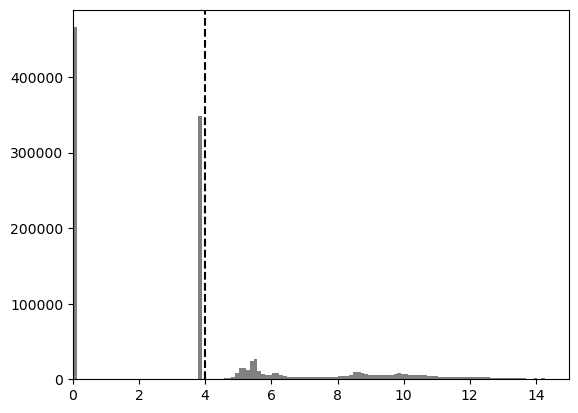

In [15]:
plt.hist(calcs[calcs['layer_label'] != 'water']['mem_dist'],bins=500,color='grey')

membrane_cutoff = 4
# plt.axvline(membrane_cutoff,color='black',ls='--')
# sns.displot(calcs[calcs['layer_label'] != 'water'],x='mem_dist',color='grey')
plt.axvline(membrane_cutoff,color='black',ls='--')
plt.xlim([0,15])

In [26]:
m = interp1d([50,1000],[500,10])


In [ ]:
calcs.to_pickle('./all_aa_metric_calculations.pkl')

In [ ]:
calcs = pd.read_pickle(data_folder+'/all_aa_metric_calculations.pkl')

### Visualizing the proteins and the different metrics

In [72]:
def plot_3d_structure(df,ax,x_angle,y_angle,groupby,color_dict,ax_min=False,ax_max=False):
    all_points = df['x'].tolist() + df['y'].tolist() + df['z'].tolist()
    if not ax_min:
        ax_min = np.min(all_points)
    if not ax_max:
        ax_max = np.max(all_points)
    ax.set_xlim(ax_min,ax_max)
    ax.set_ylim(ax_min,ax_max)
    ax.set_zlim(ax_min,ax_max)

    ax.plot(df['x'],df['y'],df['z'],markerfacecolor='k', markeredgecolor='k', marker='o', markersize=5,linewidth=2,color='black')    
    for label,temp in df.groupby(groupby):
        ax.scatter(temp['x'],temp['y'],temp['z'],marker='o',color=color_dict[label])
    ax.view_init(x_angle, y_angle)
    ax.grid(False)

def plot_all_angles(df,groupby,color_dict,figsize=[6,6],savefig=False,x=0,y=45,ax_min=False,ax_max=False):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111, projection='3d')
    plot_3d_structure(df,ax1,x,y,groupby,color_dict,ax_min=ax_min,ax_max=ax_max)

    if savefig:
        plt.savefig(f'{fig_folder}/{savefig}.svg',format='svg',dpi=300)
    plt.show()

### Fig 5A - Plotting different bins

In [73]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_5_exports'
membrane_dict = {'membrane':'aqua','outside':'blue','inside':'darkorchid'}


In [13]:
def assign_membrane_label(row):
    if abs(row['z']) > 20:
        return 'outside'
    elif row['mem_dist'] < membrane_cutoff:
        return 'membrane'
    else:
        return 'inside'

membrane_cutoff = 4

calcs['membrane_label'] = calcs.apply(assign_membrane_label,axis=1)
    

In [74]:
tested = pd.read_excel('../all_data/General_data/protein_metadata.xlsx')

P0AGA2 Protein translocase subunit SecY 30.248306997742663


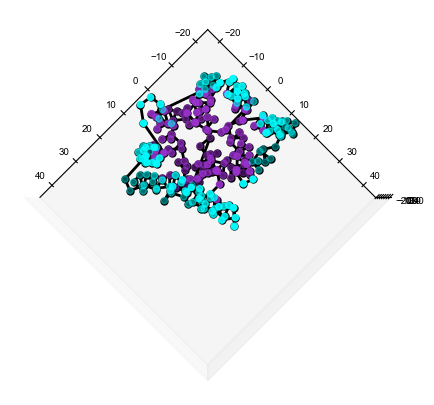

In [76]:
temp_ids = ['P0AGA2']


for uniprot,df in calcs[calcs['uniprot'].isin(temp_ids)].groupby('uniprot'):
    meta = target_df[target_df['Uniprot'] == uniprot]
    df = df[df['z'] < 50]
    df = df[df['membrane_label'] != 'outside']
    print(meta['Uniprot'].iloc[0],meta['Protein names'].iloc[0],df['percent_outside_in'].iloc[0])
#     print(len(df),m(len(df)))
    # plot_all_angles(df,'membrane_label',membrane_dict,figsize=[6,5],x=90,y=45,ax_min=-25,ax_max=45,savefig='Fig5A-structure_shell_labeled')
    plot_all_angles(df,'membrane_label',membrane_dict,figsize=[6,5],x=90,y=45,ax_min=-25,ax_max=45)

In [16]:
calcs.groupby('uniprot').agg(len)['res_id'].describe()

count    4612.000000
mean      360.184302
std       179.135862
min        43.000000
25%       248.000000
50%       304.000000
75%       451.000000
max       993.000000
Name: res_id, dtype: float64

In [77]:
bins = [0, 3, 6, 9, 12, 15, 18, 30]
names = [3, 6, 9, 12, 15, 18, 30]
calcs['depth_label'] = pd.cut(calcs['depth_6'], bins,labels=names)

bins = [-np.inf, -30, -18, -12, -6, 0, 6, 12, 18, 30, np.inf]
names = ['water','polar','interface','outer', 'inner','inner','outer','interface','polar', 'water']

calcs['layer_label'] = pd.cut(calcs['z'], bins, labels=names,ordered=False)


P0AGA2 Protein translocase subunit SecY 30.248306997742663


C:\Users\conar\AppData\Local\Temp\ipykernel_8960\3407492850.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label,temp in df.groupby(groupby):


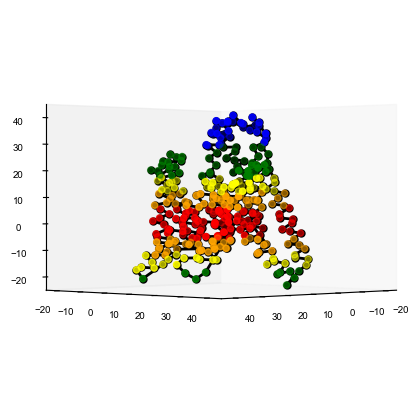

In [78]:
layer_dict = {'water':'blue','polar':'green','interface':'yellow','outer':'orange', 'inner':'red'}

for uniprot,df in calcs[calcs['uniprot'].isin(temp_ids)].groupby('uniprot'):
    meta = target_df[target_df['Uniprot'] == uniprot]
    df = df[df['z'] < 50]
    print(meta['Uniprot'].iloc[0],meta['Protein names'].iloc[0],df['percent_outside_in'].iloc[0])
#     print(len(df),m(len(df)))
    # plot_all_angles(df,'layer_label',layer_dict,figsize=[6,5],ax_min=-25,ax_max=45,savefig='Fig5A-structure_layer_labeled')
    plot_all_angles(df,'layer_label',layer_dict,figsize=[6,5],ax_min=-25,ax_max=45)


In [21]:
calcs.columns

Index(['uniprot', 'res_id', 'res', 'code', 'x', 'y', 'z', 'label', 'score',
       'position_check', 'Correct_inside', 'Correct_outside',
       'Membrane_outside', 'Outside_in_membrane', 'correct', 'incorrect',
       'total', 'percent_correct', 'percent_outside_in', 'mem_dist',
       'neighbors_6', 'neighbors_12', 'depth_6', 'depth_12', 'membrane_label',
       'depth_label', 'layer_label', 'charge', 'hydro'],
      dtype='object')

In [25]:
export = calcs[calcs['uniprot'].isin(temp_ids)]
export = export[['uniprot', 'res_id', 'res', 'x', 'y', 'z', 'mem_dist', 'depth_6', 'depth_12', 'membrane_label',
       'depth_label', 'layer_label', 'charge', 'hydro']].copy()
export.set_index('res_id').to_excel(f'./Figure_5_data/Fig5A-Labeled_structure_data.xlsx')

### Assign the charge and hydrophopbicity to all amino acids
* Used the charge at pH 7.4
* The hydrophobicity scale came from Stephen White's lab looking at the interface scale seen here: https://blanco.biomol.uci.edu/hydrophobicity_scales.html 

In [79]:
charge_mat = {
    'LEU':0,
    'VAL':0,
    'ALA':0,
    'ILE':0,
    'SER':0,
    'PHE':0,
    'GLY':0,
    'THR':0,
    'ARG':1,
    'LYS':1,
    'PRO':0,
    'GLU':-1,
    'TYR':0,
    'ASN':0,
    'ASP':-1,
    'GLN':0,
    'MET':0,
    'CYS':0,
    'HIS':1,
    'TRP':0
}

## The hydrophobicity scale came from Stephen White's lab looking at the interface scale seen here: 
## https://blanco.biomol.uci.edu/hydrophobicity_scales.html 
hydro_mat = {
    'LEU':-0.56,
    'VAL':0.07,
    'ALA':0.17,
    'ILE':-0.31,
    'SER':0.13,
    'PHE':-1.13,
    'GLY':0.01,
    'THR':0.14,
    'ARG':0.81,
    'LYS':0.99,
    'PRO':0.45,
    'GLU':2.02,
    'TYR':-0.94,
    'ASN':0.42,
    'ASP':1.23,
    'GLN':0.58,
    'MET':-0.23,
    'CYS':-0.24,
    'HIS':0.96,
    'TRP':-1.85
}

def assign_val(aa,mat=charge_mat):
    return mat[aa]
    
calcs['charge'] = calcs['res'].apply(assign_val,mat=charge_mat)
calcs['hydrophobicity'] = calcs['res'].apply(assign_val,mat=hydro_mat)

### Calculates the probability of finding a specific amino acid in a specific location bin
* Based on Yarov-Yarovoy et al. 2006 Using rosetta for membrane protein folding
* Identifies a bin as a specific layer-membrane_contact-depth combo
* Looks at how frequently each amino acid occurs in each of those bins compared to finding that amino acid in any bin
* Has been used as a method of gauging energetic favorability based on the assumption that if an amino acid is very rarely seen in a location then it it likely unfavorable

In [83]:
layers = calcs['layer_label'].unique().tolist()
depth = calcs['depth_label'].unique().tolist()
membrane = calcs['membrane_label'].unique().tolist()
res = calcs['res'].unique().tolist()

all_combos = pd.DataFrame(list(itertools.product(*[res,layers,depth,membrane])),columns=['res','layer_label','depth_label','membrane_label'])


In [81]:
all_combos.value_counts('layer_label')

layer_label
inner        420
interface    420
outer        420
polar        420
water        420
Name: count, dtype: int64

In [88]:
counts = calcs[['res','layer_label','depth_label','membrane_label']]
specific = counts.value_counts().reset_index().rename(columns={'count':'category_count'})
total = counts.value_counts(['res']).reset_index().rename(columns={'count':'aa_count'})

aa = specific.set_index(['res']).join(total.set_index(['res'])).reset_index()
aa['prob'] = aa['category_count'] / aa['aa_count']
all_probs = all_combos.set_index(['res','layer_label','depth_label','membrane_label']).join(aa.set_index(['res','layer_label','depth_label','membrane_label']))
all_probs = all_probs.fillna(0)
all_probs

category_count  aa_count      prob
res layer_label depth_label membrane_label                                    
SER water       9           outside                12142.0  114698.0  0.105861
                            membrane                   0.0       0.0  0.000000
                            inside                     0.0       0.0  0.000000
                12          outside                 9727.0  114698.0  0.084805
                            membrane                   0.0       0.0  0.000000
...                                                    ...       ...       ...
PRO inner       3           membrane                   0.0       0.0  0.000000
                            inside                     0.0       0.0  0.000000
                30          outside                    0.0       0.0  0.000000
                            membrane                   1.0   62829.0  0.000016
                            inside                     0.0       0.0  0.000000

[2100 rows x 3 columns]

### Compare probabilities for each amino acid across different bins

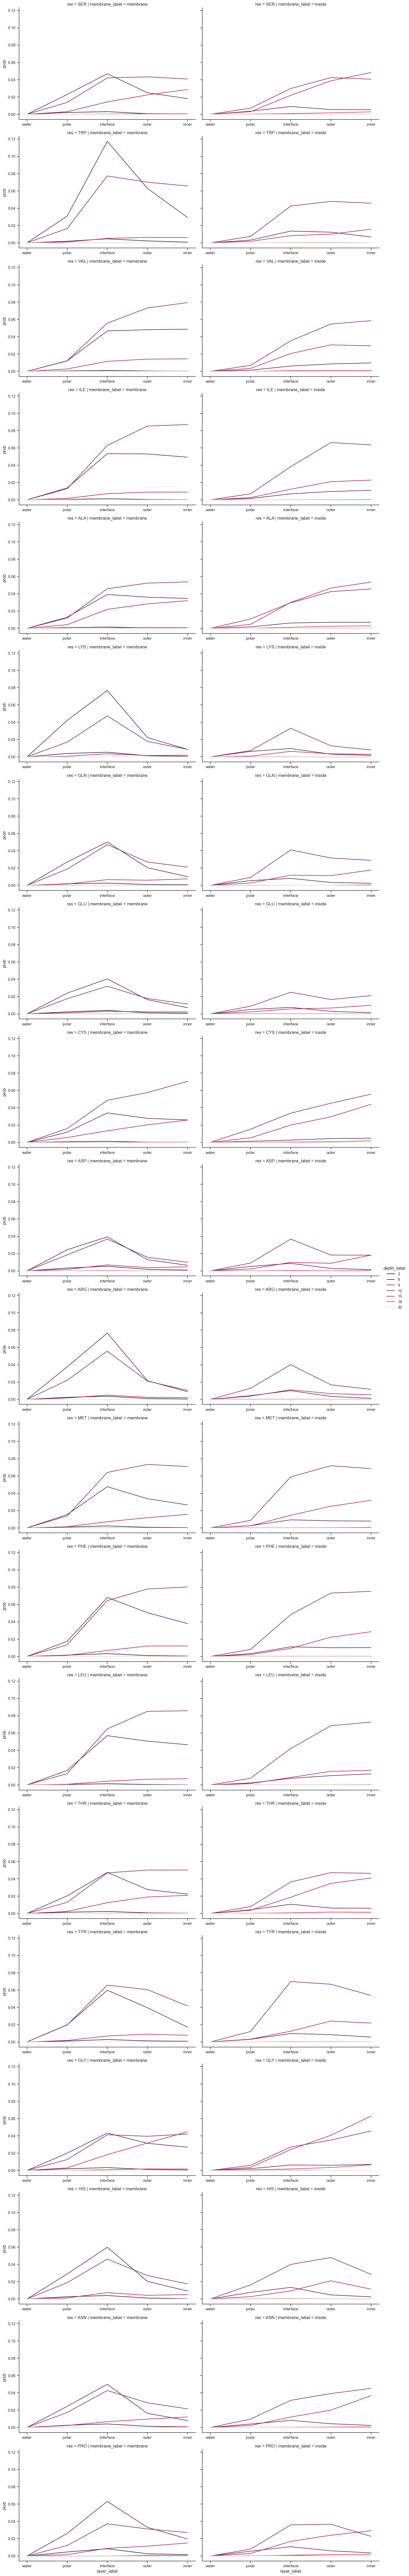

In [89]:
temp = all_probs.reset_index()
temp = temp[temp['membrane_label'] != 'outside']

sns.set(style="ticks")

sns.relplot(x="layer_label", y="prob",
            hue="depth_label", row="res",
            palette='rocket',col='membrane_label',
            height=5, aspect=1.5, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=temp)

In [90]:
energies = all_probs.drop(columns=['category_count','aa_count']).reset_index().set_index(['res','layer_label','membrane_label','depth_label']).copy()
energies['prob'] = -np.log(energies['prob'])
energies = energies.replace([np.inf], 10)

energies.describe()

c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


prob
count  2100.000000
mean      7.955724
std       2.800331
min       1.376413
25%       5.123215
50%      10.000000
75%      10.000000
max      12.301696

In [91]:
analyzed = calcs.set_index(['res','layer_label','membrane_label','depth_label']).join(energies).reset_index()
analyzed

res layer_label membrane_label depth_label     uniprot  res_id code  \
0        SER       water        outside           9  A0A075B734      18    S   
1        TRP       water        outside           9  A0A075B734      19    W   
2        SER       water        outside           9  A0A075B734      20    S   
3        VAL       water        outside           9  A0A075B734      21    V   
4        ILE       water        outside          12  A0A075B734      22    I   
...      ...         ...            ...         ...         ...     ...  ...   
1661165  GLU       polar        outside          12      Q9ZWT3     500    E   
1661166  LEU       polar        outside          12      Q9ZWT3     501    L   
1661167  SER       polar        outside          12      Q9ZWT3     502    S   
1661168  GLY       polar        outside          12      Q9ZWT3     503    G   
1661169  GLU       water        outside          12      Q9ZWT3     504    E   

                 x         y          z  ... percent_outside_in   mem_dist  \
0       -25.467508 -4.060056  47.074069  ...          35.446686  18.673165   
1       -25.755044 -6.276365  43.944878  ...          35.446686  16.338420   
2       -27.709850 -3.357141  42.378125  ...          35.446686  15.246920   
3       -24.612025 -1.086756  42.757269  ...          35.446686  14.166338   
4       -22.320360 -3.764783  41.185582  ...          35.446686  12.195275   
...            ...       ...        ...  ...                ...        ...   
1661165   7.006704  0.343467  28.523219  ...          17.441860   0.000000   
1661166   7.632607  1.429418  24.881362  ...          17.441860   3.851515   
1661167   6.150302  4.938523  25.388613  ...          17.441860   3.848437   
1661168   8.105909  5.432510  28.666119  ...          17.441860   0.000000   
1661169   4.786055  6.215330  30.484440  ...          17.441860   3.865298   

                                               neighbors_6  \
0                      [SER, TRP, ILE, SER, VAL, VAL, MET]   
1                      [TRP, SER, ALA, ILE, SER, VAL, VAL]   
2                      [SER, ALA, TRP, SER, ILE, LYS, VAL]   
3            [SER, ALA, TRP, ILE, SER, LYS, VAL, ILE, VAL]   
4        [GLN, SER, ALA, TRP, ILE, SER, LYS, VAL, ILE, ...   
...                                                    ...   
1661165  [THR, LEU, SER, LYS, GLU, GLU, LEU, SER, GLU, ...   
1661166  [GLU, LEU, SER, GLU, GLU, LYS, LEU, SER, ILE, ...   
1661167  [GLU, LEU, GLU, GLU, LEU, PRO, GLU, SER, GLY, ...   
1661168  [GLU, GLU, THR, LEU, SER, GLU, GLU, GLY, HIS, ...   
1661169  [THR, GLU, ARG, GLU, SER, VAL, GLU, GLY, ASP, ...   

                                              neighbors_12  depth_6  depth_12  \
0        [GLN, TRP, SER, ALA, ILE, SER, LYS, VAL, ILE, ...        7        13   
1        [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        7        13   
2        [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        7        13   
3        [GLN, TRP, SER, ALA, ILE, SER, GLU, LYS, VAL, ...        9        15   
4        [GLN, TRP, SER, ALA, ILE, SER, CYS, GLU, LYS, ...       10        16   
...                                                    ...      ...       ...   
1661165  [ASP, ARG, LEU, LYS, GLU, SER, THR, ARG, LYS, ...       10        39   
1661166  [ASP, ARG, GLU, LEU, THR, ARG, ARG, LYS, GLY, ...       10        43   
1661167  [ARG, GLU, LEU, THR, LYS, LYS, THR, ARG, SER, ...       12        51   
1661168  [GLU, LEU, THR, ARG, LYS, LEU, GLU, ILE, SER, ...       10        40   
1661169  [ARG, LEU, ASP, GLU, THR, ARG, LEU, GLU, ILE, ...       10        41   

         charge  hydro  hydrophobicity      prob  
0             0   0.13            0.13  2.245632  
1             0  -1.85           -1.85  3.127215  
2             0   0.13            0.13  2.245632  
3             0   0.07            0.07  3.064985  
4             0  -0.31           -0.31  2.295028  
...         ...    ...             ...       ...  
1661165      -1   2.02            2.

### Calculate all metrics for every amino acid for every protein in the dataset

In [40]:
metrics = ['hydro','charge','depth_6','prob']

def calc_values(df,metric,layer,mem):
    return [layer,mem,metric,np.mean(df[metric]),np.sum(df[metric]),np.min(df[metric]),np.max(df[metric])]

dfs = []

for i, [uniprot,df] in enumerate(analyzed.groupby('uniprot')):
    data = []
    print(i,':',uniprot)
    
    for [layer,mem],df in df.groupby(['layer_label','membrane_label']):
        vals = [calc_values(df,metric,layer,mem) for metric in metrics]
        data.append(vals)
    data = list(chain.from_iterable(data))
    temp = pd.DataFrame(data,columns=['Layer','Mem','Metric','Mean','Sum','Min','Max'])
    temp['uniprot'] = uniprot
    dfs.append(temp)
all_values = pd.concat(dfs)
all_values

0 : A0A075B734
1 : A0A087WTH1
2 : A0A096LPK9
3 : A0A0X1KG70
4 : A0A1B0GTI8
5 : A0A1B0GVZ9
6 : A0A1W2PS18
7 : A0A494BZU4
8 : A0AV02
9 : A0AVI4
10 : A0FGR9
11 : A0MFS9
12 : A0PJK1
13 : A0PJW6
14 : A0PJX8
15 : A0PK11
16 : A1A5B4
17 : A1L157
18 : A1L3X0
19 : A1L4X0
20 : A1XJK0
21 : A2RU14
22 : A2RVP7
23 : A3KFT3
24 : A4D2G3
25 : A4IF30
26 : A5A605
27 : A5A630
28 : A5D6W6
29 : A5X5Y0
30 : A6NC51
31 : A6NCV1
32 : A6ND48
33 : A6NDH6
34 : A6NDL8
35 : A6NDP7
36 : A6NDV4
37 : A6NET4
38 : A6NF89
39 : A6NFC5
40 : A6NFX1
41 : A6NGA9
42 : A6NGB7
43 : A6NGC4
44 : A6NGY5
45 : A6NH00
46 : A6NH21
47 : A6NH52
48 : A6NHA9
49 : A6NHG9
50 : A6NI61
51 : A6NIJ9
52 : A6NIM6
53 : A6NJY1
54 : A6NJY4
55 : A6NJZ3
56 : A6NK97
57 : A6NKF7
58 : A6NKK0
59 : A6NKX4
60 : A6NL08
61 : A6NL26
62 : A6NL99
63 : A6NM03
64 : A6NM10
65 : A6NM45
66 : A6NM76
67 : A6NMS3
68 : A6NMU1
69 : A6NMZ5
70 : A6NN92
71 : A6NND4
72 : A6NNN8
73 : A7MBM2
74 : A8MPR5
75 : A8MPY1
76 : A8MRV9
77 : A8MRY9
78 : A8MUP6
79 : A8MWK0
80 : A8MWL6
81 : A

Layer       Mem   Metric       Mean         Sum       Min        Max  \
0   hydro    inside    hydro  -0.062000   -3.410000 -1.130000   2.020000   
1   hydro    inside   charge   0.000000    0.000000 -1.000000   1.000000   
2   hydro    inside  depth_6  12.363636  680.000000  9.000000  16.000000   
3   hydro    inside     prob   3.146466  173.055617  2.587075   6.211890   
4   hydro  membrane    hydro  -0.341176   -5.800000 -1.850000   0.960000   
..    ...       ...      ...        ...         ...       ...        ...   
35  polar   outside     prob   2.886355  303.067292  1.743804   5.139476   
36  water   outside    hydro   0.392800   19.640000 -0.940000   2.020000   
37  water   outside   charge  -0.020000   -1.000000 -1.000000   1.000000   
38  water   outside  depth_6   9.880000  494.000000  5.000000  15.000000   
39  water   outside     prob   2.584327  129.216359  1.376413   5.471805   

       uniprot  
0   A0A075B734  
1   A0A075B734  
2   A0A075B734  
3   A0A075B734  
4   A0A075B734  
..         ...  
35      Q9ZWT3  
36      Q9ZWT3  
37      Q9ZWT3  
38      Q9ZWT3  
39      Q9ZWT3  

[174772 rows x 8 columns]

In [41]:
all_values['Group'] = all_values['Layer'] +'-'+ all_values['Mem'] +'-'+ all_values['Metric']
all_values

Layer       Mem   Metric       Mean         Sum       Min        Max  \
0   hydro    inside    hydro  -0.062000   -3.410000 -1.130000   2.020000   
1   hydro    inside   charge   0.000000    0.000000 -1.000000   1.000000   
2   hydro    inside  depth_6  12.363636  680.000000  9.000000  16.000000   
3   hydro    inside     prob   3.146466  173.055617  2.587075   6.211890   
4   hydro  membrane    hydro  -0.341176   -5.800000 -1.850000   0.960000   
..    ...       ...      ...        ...         ...       ...        ...   
35  polar   outside     prob   2.886355  303.067292  1.743804   5.139476   
36  water   outside    hydro   0.392800   19.640000 -0.940000   2.020000   
37  water   outside   charge  -0.020000   -1.000000 -1.000000   1.000000   
38  water   outside  depth_6   9.880000  494.000000  5.000000  15.000000   
39  water   outside     prob   2.584327  129.216359  1.376413   5.471805   

       uniprot                  Group  
0   A0A075B734     hydro-inside-hydro  
1   A0A075B734    hydro-inside-charge  
2   A0A075B734   hydro-inside-depth_6  
3   A0A075B734      hydro-inside-prob  
4   A0A075B734   hydro-membrane-hydro  
..         ...                    ...  
35      Q9ZWT3     polar-outside-prob  
36      Q9ZWT3    water-outside-hydro  
37      Q9ZWT3   water-outside-charge  
38      Q9ZWT3  water-outside-depth_6  
39      Q9ZWT3     water-outside-prob  

[174772 rows x 9 columns]

In [42]:
stacked_data = all_values.copy()
stacked_data.set_index(['uniprot','Group'],inplace=True)
stacked_data.drop(columns=['Layer','Mem','Metric'],axis=0,inplace=True)
stacked_data = stacked_data.stack().reset_index()
stacked_data['Calculation'] = stacked_data['Group'] +'-'+ stacked_data['level_2']
stacked_data.drop(columns=['Group','level_2'],axis=0,inplace=True)
stacked_data.rename(columns={0:'Value'},inplace=True)
stacked_data.set_index(['uniprot','Calculation'],inplace=True)
stacked_data = stacked_data.unstack(level=-1)
stacked_data = stacked_data.fillna(0)
stacked_data

Value                           \
Calculation hydro-inside-charge-Max hydro-inside-charge-Mean   
uniprot                                                        
A0A075B734                      1.0                 0.000000   
A0A087WTH1                      0.0                 0.000000   
A0A096LPK9                      0.0                -0.048780   
A0A0X1KG70                      1.0                -0.021277   
A0A1B0GTI8                      0.0                 0.000000   
...                             ...                      ...   
Q9ZWB9                          1.0                 0.142857   
Q9ZWD1                          0.0                 0.000000   
Q9ZWG1                          1.0                 0.054545   
Q9ZWI7                          1.0                 0.055556   
Q9ZWT3                          0.0                -0.093750   

                                                             \
Calculation hydro-inside-charge-Min hydro-inside-charge-Sum   
uniprot                                                       
A0A075B734                     -1.0                     0.0   
A0A087WTH1                      0.0                     0.0   
A0A096LPK9                     -1.0                    -2.0   
A0A0X1KG70                     -1.0                    -1.0   
A0A1B0GTI8                      0.0                     0.0   
...                             ...                     ...   
Q9ZWB9                         -1.0                     3.0   
Q9ZWD1                          0.0                     0.0   
Q9ZWG1                         -1.0                     3.0   
Q9ZWI7                          0.0                     1.0   
Q9ZWT3                         -1.0                    -3.0   

                                                                \
Calculation hydro-inside-depth_6-Max hydro-inside-depth_6-Mean   
uniprot                                                          
A0A075B734                      16.0                 12.363636   
A0A087WTH1                      10.0                  9.142857   
A0A096LPK9                      16.0                 11.414634   
A0A0X1KG70                      15.0                 11.382979   
A0A1B0GTI8                      14.0                 11.166667   
...                              ...                       ...   
Q9ZWB9                          15.0                 12.095238   
Q9ZWD1                          13.0                 10.277778   
Q9ZWG1                          14.0                 11.018182   
Q9ZWI7                          13.0                 10.555556   
Q9ZWT3                          16.0                 13.281250   

                                                               \
Calculation hydro-inside-depth_6-Min hydro-inside-depth_6-Sum   
uniprot                                                         
A0A075B734                       9.0                    680.0   
A0A087WTH1                       9.0                     64.0   
A0A096LPK9                       9.0                    468.0   
A0A0X1KG70                       9.0                    535.0   
A0A1B0GTI8                       9.0                    201.0   
...                              ...                      ...   
Q9ZWB9                          10.0                    254.0   
Q9ZWD1                           9.0                    185.0   
Q9ZWG1                           9.0                    606.0   
Q9ZWI7                           9.0                    190.0   
Q9ZWT3                          11.0                    425.0   

                                                            ...  \
Calculation hydro-inside-hydro-Max hydro-inside-hydro-Mean  ...   
uniprot                                                     ...   
A0A075B734                    2.02               -0.062000  ...   
A0A087WTH1                    0.17               -0.311429  ...   
A0A096LPK9                    2.02               -0.220244  ...   
A0A0X1KG70  

In [45]:
stacked_data.to_excel('./uniprot_ids_metrics.xlsx')

In [37]:
stacked_data = pd.read_excel('./uniprot_ids_metrics.xlsx')